In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                       | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                               | 1/2604 [00:00<41:26,  1.05it/s]

  0%|                                                                                                                               | 2/2604 [00:01<21:24,  2.03it/s]

  0%|▏                                                                                                                              | 3/2604 [00:01<14:59,  2.89it/s]

  0%|▏                                                                                                                              | 4/2604 [00:01<11:58,  3.62it/s]

  0%|▏                                                                                                                              | 5/2604 [00:01<10:17,  4.21it/s]

  0%|▎                                                                                                                              | 6/2604 [00:01<09:17,  4.66it/s]

  0%|▎                                                                                                                              | 7/2604 [00:01<08:39,  5.00it/s]

  0%|▍                                                                                                                              | 8/2604 [00:02<08:14,  5.25it/s]

  0%|▍                                                                                                                              | 9/2604 [00:02<07:57,  5.44it/s]

  0%|▍                                                                                                                             | 10/2604 [00:02<07:45,  5.57it/s]

  0%|▌                                                                                                                             | 11/2604 [00:02<07:37,  5.66it/s]

  0%|▌                                                                                                                             | 12/2604 [00:02<07:32,  5.73it/s]

  0%|▋                                                                                                                             | 13/2604 [00:02<07:28,  5.78it/s]

  1%|▋                                                                                                                             | 14/2604 [00:03<07:25,  5.81it/s]

  1%|▋                                                                                                                             | 15/2604 [00:03<07:23,  5.83it/s]

  1%|▊                                                                                                                             | 16/2604 [00:03<07:22,  5.85it/s]

  1%|▊                                                                                                                             | 17/2604 [00:03<07:21,  5.86it/s]

  1%|▊                                                                                                                             | 18/2604 [00:03<07:20,  5.87it/s]

  1%|▉                                                                                                                             | 19/2604 [00:04<07:20,  5.87it/s]

  1%|▉                                                                                                                             | 20/2604 [00:04<07:20,  5.87it/s]

  1%|█                                                                                                                             | 21/2604 [00:04<07:19,  5.87it/s]

  1%|█                                                                                                                             | 22/2604 [00:04<07:19,  5.88it/s]

  1%|█                                                                                                                             | 23/2604 [00:04<07:18,  5.88it/s]

  1%|█▏                                                                                                                            | 24/2604 [00:04<07:18,  5.89it/s]

  1%|█▏                                                                                                                            | 25/2604 [00:05<07:18,  5.89it/s]

  1%|█▎                                                                                                                            | 26/2604 [00:05<07:17,  5.89it/s]

  1%|█▎                                                                                                                            | 27/2604 [00:05<07:17,  5.89it/s]

  1%|█▎                                                                                                                            | 28/2604 [00:05<07:17,  5.89it/s]

  1%|█▍                                                                                                                            | 29/2604 [00:05<07:17,  5.89it/s]

  1%|█▍                                                                                                                            | 30/2604 [00:05<07:17,  5.89it/s]

  1%|█▌                                                                                                                            | 31/2604 [00:06<07:17,  5.89it/s]

  1%|█▌                                                                                                                            | 32/2604 [00:06<07:16,  5.89it/s]

  1%|█▌                                                                                                                            | 33/2604 [00:06<07:16,  5.89it/s]

  1%|█▋                                                                                                                            | 34/2604 [00:06<07:17,  5.88it/s]

  1%|█▋                                                                                                                            | 35/2604 [00:06<07:16,  5.88it/s]

  1%|█▋                                                                                                                            | 36/2604 [00:06<07:16,  5.88it/s]

  1%|█▊                                                                                                                            | 37/2604 [00:07<07:16,  5.89it/s]

  1%|█▊                                                                                                                            | 38/2604 [00:07<07:16,  5.88it/s]

  1%|█▉                                                                                                                            | 39/2604 [00:07<07:15,  5.89it/s]

  2%|█▉                                                                                                                            | 40/2604 [00:07<07:15,  5.89it/s]

  2%|█▉                                                                                                                            | 41/2604 [00:07<07:15,  5.88it/s]

  2%|██                                                                                                                            | 42/2604 [00:07<07:15,  5.88it/s]

  2%|██                                                                                                                            | 43/2604 [00:08<07:15,  5.88it/s]

  2%|██▏                                                                                                                           | 44/2604 [00:08<07:15,  5.88it/s]

  2%|██▏                                                                                                                           | 45/2604 [00:08<07:14,  5.88it/s]

  2%|██▏                                                                                                                           | 46/2604 [00:08<07:14,  5.89it/s]

  2%|██▎                                                                                                                           | 47/2604 [00:08<07:14,  5.89it/s]

  2%|██▎                                                                                                                           | 48/2604 [00:08<07:14,  5.88it/s]

  2%|██▎                                                                                                                           | 49/2604 [00:09<07:14,  5.88it/s]

  2%|██▍                                                                                                                           | 50/2604 [00:09<07:14,  5.88it/s]

  2%|██▍                                                                                                                           | 51/2604 [00:09<07:13,  5.88it/s]

  2%|██▌                                                                                                                           | 52/2604 [00:09<07:13,  5.88it/s]

  2%|██▌                                                                                                                           | 53/2604 [00:09<07:13,  5.89it/s]

  2%|██▌                                                                                                                           | 54/2604 [00:09<07:13,  5.89it/s]

  2%|██▋                                                                                                                           | 55/2604 [00:10<07:13,  5.88it/s]

  2%|██▋                                                                                                                           | 56/2604 [00:10<07:13,  5.88it/s]

  2%|██▊                                                                                                                           | 57/2604 [00:10<07:12,  5.89it/s]

  2%|██▊                                                                                                                           | 58/2604 [00:10<07:12,  5.89it/s]

  2%|██▊                                                                                                                           | 59/2604 [00:10<07:12,  5.89it/s]

  2%|██▉                                                                                                                           | 60/2604 [00:10<07:12,  5.89it/s]

  2%|██▉                                                                                                                           | 61/2604 [00:11<07:12,  5.89it/s]

  2%|███                                                                                                                           | 62/2604 [00:11<07:11,  5.88it/s]

  2%|███                                                                                                                           | 63/2604 [00:11<07:10,  5.90it/s]

  2%|███                                                                                                                           | 64/2604 [00:11<07:10,  5.90it/s]

  2%|███▏                                                                                                                          | 65/2604 [00:11<07:09,  5.91it/s]

  3%|███▏                                                                                                                          | 66/2604 [00:11<07:09,  5.91it/s]

  3%|███▏                                                                                                                          | 67/2604 [00:12<07:08,  5.92it/s]

  3%|███▎                                                                                                                          | 68/2604 [00:12<07:08,  5.92it/s]

  3%|███▎                                                                                                                          | 69/2604 [00:12<07:08,  5.91it/s]

  3%|███▍                                                                                                                          | 70/2604 [00:12<07:09,  5.90it/s]

  3%|███▍                                                                                                                          | 71/2604 [00:12<07:09,  5.90it/s]

  3%|███▍                                                                                                                          | 72/2604 [00:13<07:09,  5.89it/s]

  3%|███▌                                                                                                                          | 73/2604 [00:13<07:09,  5.89it/s]

  3%|███▌                                                                                                                          | 74/2604 [00:13<07:09,  5.89it/s]

  3%|███▋                                                                                                                          | 75/2604 [00:13<07:09,  5.89it/s]

  3%|███▋                                                                                                                          | 76/2604 [00:13<07:09,  5.88it/s]

  3%|███▋                                                                                                                          | 77/2604 [00:13<07:09,  5.88it/s]

  3%|███▊                                                                                                                          | 78/2604 [00:14<07:09,  5.88it/s]

  3%|███▊                                                                                                                          | 79/2604 [00:14<07:09,  5.88it/s]

  3%|███▊                                                                                                                          | 80/2604 [00:14<07:08,  5.89it/s]

  3%|███▉                                                                                                                          | 81/2604 [00:14<07:08,  5.89it/s]

  3%|███▉                                                                                                                          | 82/2604 [00:14<07:08,  5.89it/s]

  3%|████                                                                                                                          | 83/2604 [00:14<07:08,  5.88it/s]

  3%|████                                                                                                                          | 84/2604 [00:15<07:08,  5.88it/s]

  3%|████                                                                                                                          | 85/2604 [00:15<07:08,  5.88it/s]

  3%|████▏                                                                                                                         | 86/2604 [00:15<07:08,  5.88it/s]

  3%|████▏                                                                                                                         | 87/2604 [00:15<07:07,  5.88it/s]

  3%|████▎                                                                                                                         | 88/2604 [00:15<07:07,  5.88it/s]

  3%|████▎                                                                                                                         | 89/2604 [00:15<07:07,  5.88it/s]

  3%|████▎                                                                                                                         | 90/2604 [00:16<07:07,  5.88it/s]

  3%|████▍                                                                                                                         | 91/2604 [00:16<07:07,  5.88it/s]

  4%|████▍                                                                                                                         | 92/2604 [00:16<07:07,  5.88it/s]

  4%|████▌                                                                                                                         | 93/2604 [00:16<07:07,  5.88it/s]

  4%|████▌                                                                                                                         | 94/2604 [00:16<07:06,  5.88it/s]

  4%|████▌                                                                                                                         | 95/2604 [00:16<07:06,  5.88it/s]

  4%|████▋                                                                                                                         | 96/2604 [00:17<07:06,  5.88it/s]

  4%|████▋                                                                                                                         | 97/2604 [00:17<07:06,  5.88it/s]

  4%|████▋                                                                                                                         | 98/2604 [00:17<07:06,  5.88it/s]

  4%|████▊                                                                                                                         | 99/2604 [00:17<07:05,  5.88it/s]

  4%|████▊                                                                                                                        | 100/2604 [00:17<07:05,  5.88it/s]

  4%|████▊                                                                                                                        | 101/2604 [00:17<07:05,  5.88it/s]

  4%|████▉                                                                                                                        | 102/2604 [00:18<07:05,  5.88it/s]

  4%|████▉                                                                                                                        | 103/2604 [00:18<07:04,  5.89it/s]

  4%|████▉                                                                                                                        | 104/2604 [00:18<07:05,  5.88it/s]

  4%|█████                                                                                                                        | 105/2604 [00:18<07:05,  5.88it/s]

  4%|█████                                                                                                                        | 106/2604 [00:18<07:04,  5.88it/s]

  4%|█████▏                                                                                                                       | 107/2604 [00:18<07:04,  5.88it/s]

  4%|█████▏                                                                                                                       | 108/2604 [00:19<07:04,  5.88it/s]

  4%|█████▏                                                                                                                       | 109/2604 [00:19<07:04,  5.88it/s]

  4%|█████▎                                                                                                                       | 110/2604 [00:19<07:03,  5.88it/s]

  4%|█████▎                                                                                                                       | 111/2604 [00:19<07:04,  5.88it/s]

  4%|█████▍                                                                                                                       | 112/2604 [00:19<07:03,  5.88it/s]

  4%|█████▍                                                                                                                       | 113/2604 [00:19<07:03,  5.88it/s]

  4%|█████▍                                                                                                                       | 114/2604 [00:20<07:03,  5.88it/s]

  4%|█████▌                                                                                                                       | 115/2604 [00:20<07:03,  5.88it/s]

  4%|█████▌                                                                                                                       | 116/2604 [00:20<07:02,  5.88it/s]

  4%|█████▌                                                                                                                       | 117/2604 [00:20<07:02,  5.88it/s]

  5%|█████▋                                                                                                                       | 118/2604 [00:20<07:02,  5.88it/s]

  5%|█████▋                                                                                                                       | 119/2604 [00:21<07:01,  5.90it/s]

  5%|█████▊                                                                                                                       | 120/2604 [00:21<07:01,  5.89it/s]

  5%|█████▊                                                                                                                       | 121/2604 [00:21<07:00,  5.90it/s]

  5%|█████▊                                                                                                                       | 122/2604 [00:21<07:00,  5.91it/s]

  5%|█████▉                                                                                                                       | 123/2604 [00:21<06:59,  5.91it/s]

  5%|█████▉                                                                                                                       | 124/2604 [00:21<06:59,  5.92it/s]

  5%|██████                                                                                                                       | 125/2604 [00:22<06:59,  5.91it/s]

  5%|██████                                                                                                                       | 126/2604 [00:22<06:59,  5.90it/s]

  5%|██████                                                                                                                       | 127/2604 [00:22<07:00,  5.90it/s]

  5%|██████▏                                                                                                                      | 128/2604 [00:22<07:00,  5.89it/s]

  5%|██████▏                                                                                                                      | 129/2604 [00:22<07:00,  5.89it/s]

  5%|██████▏                                                                                                                      | 130/2604 [00:22<07:00,  5.89it/s]

  5%|██████▎                                                                                                                      | 131/2604 [00:23<06:59,  5.89it/s]

  5%|██████▎                                                                                                                      | 132/2604 [00:23<07:00,  5.88it/s]

  5%|██████▍                                                                                                                      | 133/2604 [00:23<07:00,  5.88it/s]

  5%|██████▍                                                                                                                      | 134/2604 [00:23<07:00,  5.88it/s]

  5%|██████▍                                                                                                                      | 135/2604 [00:23<06:59,  5.88it/s]

  5%|██████▌                                                                                                                      | 136/2604 [00:23<06:59,  5.88it/s]

  5%|██████▌                                                                                                                      | 137/2604 [00:24<06:59,  5.88it/s]

  5%|██████▌                                                                                                                      | 138/2604 [00:24<06:59,  5.88it/s]

  5%|██████▋                                                                                                                      | 139/2604 [00:24<06:59,  5.88it/s]

  5%|██████▋                                                                                                                      | 140/2604 [00:24<06:59,  5.88it/s]

  5%|██████▊                                                                                                                      | 141/2604 [00:24<06:58,  5.88it/s]

  5%|██████▊                                                                                                                      | 142/2604 [00:24<06:58,  5.88it/s]

  5%|██████▊                                                                                                                      | 143/2604 [00:25<06:58,  5.89it/s]

  6%|██████▉                                                                                                                      | 144/2604 [00:25<06:57,  5.89it/s]

  6%|██████▉                                                                                                                      | 145/2604 [00:25<06:57,  5.89it/s]

  6%|███████                                                                                                                      | 146/2604 [00:25<06:58,  5.88it/s]

  6%|███████                                                                                                                      | 147/2604 [00:25<06:57,  5.88it/s]

  6%|███████                                                                                                                      | 148/2604 [00:25<06:57,  5.88it/s]

  6%|███████▏                                                                                                                     | 149/2604 [00:26<06:57,  5.88it/s]

  6%|███████▏                                                                                                                     | 150/2604 [00:26<06:57,  5.88it/s]

  6%|███████▏                                                                                                                     | 151/2604 [00:26<06:56,  5.89it/s]

  6%|███████▎                                                                                                                     | 152/2604 [00:26<06:56,  5.88it/s]

  6%|███████▎                                                                                                                     | 153/2604 [00:26<06:56,  5.88it/s]

  6%|███████▍                                                                                                                     | 154/2604 [00:26<06:56,  5.88it/s]

  6%|███████▍                                                                                                                     | 155/2604 [00:27<06:56,  5.88it/s]

  6%|███████▍                                                                                                                     | 156/2604 [00:27<06:56,  5.88it/s]

  6%|███████▌                                                                                                                     | 157/2604 [00:27<06:55,  5.89it/s]

  6%|███████▌                                                                                                                     | 158/2604 [00:27<06:55,  5.88it/s]

  6%|███████▋                                                                                                                     | 159/2604 [00:27<06:55,  5.89it/s]

  6%|███████▋                                                                                                                     | 160/2604 [00:27<06:55,  5.88it/s]

  6%|███████▋                                                                                                                     | 161/2604 [00:28<06:55,  5.88it/s]

  6%|███████▊                                                                                                                     | 162/2604 [00:28<06:55,  5.88it/s]

  6%|███████▊                                                                                                                     | 163/2604 [00:28<06:54,  5.88it/s]

  6%|███████▊                                                                                                                     | 164/2604 [00:28<06:54,  5.89it/s]

  6%|███████▉                                                                                                                     | 165/2604 [00:28<06:54,  5.88it/s]

  6%|███████▉                                                                                                                     | 166/2604 [00:28<06:54,  5.89it/s]

  6%|████████                                                                                                                     | 167/2604 [00:29<06:54,  5.88it/s]

  6%|████████                                                                                                                     | 168/2604 [00:29<06:54,  5.88it/s]

  6%|████████                                                                                                                     | 169/2604 [00:29<06:53,  5.88it/s]

  7%|████████▏                                                                                                                    | 170/2604 [00:29<06:53,  5.88it/s]

  7%|████████▏                                                                                                                    | 171/2604 [00:29<06:53,  5.89it/s]

  7%|████████▎                                                                                                                    | 172/2604 [00:30<06:53,  5.89it/s]

  7%|████████▎                                                                                                                    | 173/2604 [00:30<06:52,  5.89it/s]

  7%|████████▎                                                                                                                    | 174/2604 [00:30<06:53,  5.88it/s]

  7%|████████▍                                                                                                                    | 175/2604 [00:30<06:51,  5.90it/s]

  7%|████████▍                                                                                                                    | 176/2604 [00:30<06:51,  5.90it/s]

  7%|████████▍                                                                                                                    | 177/2604 [00:30<06:50,  5.91it/s]

  7%|████████▌                                                                                                                    | 178/2604 [00:31<06:50,  5.92it/s]

  7%|████████▌                                                                                                                    | 179/2604 [00:31<06:49,  5.92it/s]

  7%|████████▋                                                                                                                    | 180/2604 [00:31<06:49,  5.92it/s]

  7%|████████▋                                                                                                                    | 181/2604 [00:31<06:49,  5.91it/s]

  7%|████████▋                                                                                                                    | 182/2604 [00:31<06:50,  5.91it/s]

  7%|████████▊                                                                                                                    | 183/2604 [00:31<06:50,  5.90it/s]

  7%|████████▊                                                                                                                    | 184/2604 [00:32<06:50,  5.90it/s]

  7%|████████▉                                                                                                                    | 185/2604 [00:32<06:50,  5.89it/s]

  7%|████████▉                                                                                                                    | 186/2604 [00:32<06:50,  5.89it/s]

  7%|████████▉                                                                                                                    | 187/2604 [00:32<06:50,  5.89it/s]

  7%|█████████                                                                                                                    | 188/2604 [00:32<06:50,  5.88it/s]

  7%|█████████                                                                                                                    | 189/2604 [00:32<06:50,  5.88it/s]

  7%|█████████                                                                                                                    | 190/2604 [00:33<06:50,  5.88it/s]

  7%|█████████▏                                                                                                                   | 191/2604 [00:33<06:50,  5.88it/s]

  7%|█████████▏                                                                                                                   | 192/2604 [00:33<06:49,  5.89it/s]

  7%|█████████▎                                                                                                                   | 193/2604 [00:33<06:49,  5.89it/s]

  7%|█████████▎                                                                                                                   | 194/2604 [00:33<06:49,  5.89it/s]

  7%|█████████▎                                                                                                                   | 195/2604 [00:33<06:49,  5.88it/s]

  8%|█████████▍                                                                                                                   | 196/2604 [00:34<06:49,  5.88it/s]

  8%|█████████▍                                                                                                                   | 197/2604 [00:34<06:49,  5.88it/s]

  8%|█████████▌                                                                                                                   | 198/2604 [00:34<06:48,  5.88it/s]

  8%|█████████▌                                                                                                                   | 199/2604 [00:34<06:48,  5.89it/s]

  8%|█████████▌                                                                                                                   | 200/2604 [00:34<06:48,  5.89it/s]

  8%|█████████▋                                                                                                                   | 201/2604 [00:34<06:48,  5.89it/s]

  8%|█████████▋                                                                                                                   | 202/2604 [00:35<06:48,  5.88it/s]

  8%|█████████▋                                                                                                                   | 203/2604 [00:35<06:48,  5.88it/s]

  8%|█████████▊                                                                                                                   | 204/2604 [00:35<06:47,  5.88it/s]

  8%|█████████▊                                                                                                                   | 205/2604 [00:35<06:47,  5.88it/s]

  8%|█████████▉                                                                                                                   | 206/2604 [00:35<06:47,  5.89it/s]

  8%|█████████▉                                                                                                                   | 207/2604 [00:35<06:47,  5.89it/s]

  8%|█████████▉                                                                                                                   | 208/2604 [00:36<06:47,  5.89it/s]

  8%|██████████                                                                                                                   | 209/2604 [00:36<06:47,  5.88it/s]

  8%|██████████                                                                                                                   | 210/2604 [00:36<06:47,  5.88it/s]

  8%|██████████▏                                                                                                                  | 211/2604 [00:36<06:46,  5.88it/s]

  8%|██████████▏                                                                                                                  | 212/2604 [00:36<06:46,  5.88it/s]

  8%|██████████▏                                                                                                                  | 213/2604 [00:36<06:46,  5.89it/s]

  8%|██████████▎                                                                                                                  | 214/2604 [00:37<06:46,  5.89it/s]

  8%|██████████▎                                                                                                                  | 215/2604 [00:37<06:45,  5.89it/s]

  8%|██████████▎                                                                                                                  | 216/2604 [00:37<06:46,  5.88it/s]

  8%|██████████▍                                                                                                                  | 217/2604 [00:37<06:45,  5.88it/s]

  8%|██████████▍                                                                                                                  | 218/2604 [00:37<06:45,  5.88it/s]

  8%|██████████▌                                                                                                                  | 219/2604 [00:37<06:45,  5.88it/s]

  8%|██████████▌                                                                                                                  | 220/2604 [00:38<06:45,  5.88it/s]

  8%|██████████▌                                                                                                                  | 221/2604 [00:38<06:45,  5.88it/s]

  9%|██████████▋                                                                                                                  | 222/2604 [00:38<06:44,  5.88it/s]

  9%|██████████▋                                                                                                                  | 223/2604 [00:38<06:44,  5.88it/s]

  9%|██████████▊                                                                                                                  | 224/2604 [00:38<06:44,  5.88it/s]

  9%|██████████▊                                                                                                                  | 225/2604 [00:39<06:44,  5.88it/s]

  9%|██████████▊                                                                                                                  | 226/2604 [00:39<06:44,  5.88it/s]

  9%|██████████▉                                                                                                                  | 227/2604 [00:39<06:43,  5.89it/s]

  9%|██████████▉                                                                                                                  | 228/2604 [00:39<06:43,  5.88it/s]

  9%|██████████▉                                                                                                                  | 229/2604 [00:39<06:43,  5.88it/s]

  9%|███████████                                                                                                                  | 230/2604 [00:39<06:43,  5.88it/s]

  9%|███████████                                                                                                                  | 231/2604 [00:40<06:42,  5.90it/s]

  9%|███████████▏                                                                                                                 | 232/2604 [00:40<06:41,  5.90it/s]

  9%|███████████▏                                                                                                                 | 233/2604 [00:40<06:41,  5.91it/s]

  9%|███████████▏                                                                                                                 | 234/2604 [00:40<06:40,  5.91it/s]

  9%|███████████▎                                                                                                                 | 235/2604 [00:40<06:40,  5.92it/s]

  9%|███████████▎                                                                                                                 | 236/2604 [00:40<06:40,  5.92it/s]

  9%|███████████▍                                                                                                                 | 237/2604 [00:41<06:40,  5.91it/s]

  9%|███████████▍                                                                                                                 | 238/2604 [00:41<06:40,  5.90it/s]

  9%|███████████▍                                                                                                                 | 239/2604 [00:41<06:40,  5.90it/s]

  9%|███████████▌                                                                                                                 | 240/2604 [00:41<06:41,  5.89it/s]

  9%|███████████▌                                                                                                                 | 241/2604 [00:41<06:41,  5.89it/s]

  9%|███████████▌                                                                                                                 | 242/2604 [00:41<06:41,  5.89it/s]

  9%|███████████▋                                                                                                                 | 243/2604 [00:42<06:40,  5.89it/s]

  9%|███████████▋                                                                                                                 | 244/2604 [00:42<06:41,  5.88it/s]

  9%|███████████▊                                                                                                                 | 245/2604 [00:42<06:41,  5.88it/s]

  9%|███████████▊                                                                                                                 | 246/2604 [00:42<06:40,  5.88it/s]

  9%|███████████▊                                                                                                                 | 247/2604 [00:42<06:40,  5.88it/s]

 10%|███████████▉                                                                                                                 | 248/2604 [00:42<06:40,  5.89it/s]

 10%|███████████▉                                                                                                                 | 249/2604 [00:43<06:40,  5.88it/s]

 10%|████████████                                                                                                                 | 250/2604 [00:43<06:40,  5.88it/s]

 10%|████████████                                                                                                                 | 251/2604 [00:43<06:40,  5.88it/s]

 10%|████████████                                                                                                                 | 252/2604 [00:43<06:39,  5.88it/s]

 10%|████████████▏                                                                                                                | 253/2604 [00:43<06:40,  5.88it/s]

 10%|████████████▏                                                                                                                | 254/2604 [00:43<06:39,  5.88it/s]

 10%|████████████▏                                                                                                                | 255/2604 [00:44<06:39,  5.88it/s]

 10%|████████████▎                                                                                                                | 256/2604 [00:44<06:39,  5.88it/s]

 10%|████████████▎                                                                                                                | 257/2604 [00:44<06:38,  5.88it/s]

 10%|████████████▍                                                                                                                | 258/2604 [00:44<06:38,  5.88it/s]

 10%|████████████▍                                                                                                                | 259/2604 [00:44<06:38,  5.89it/s]

 10%|████████████▍                                                                                                                | 260/2604 [00:44<06:38,  5.88it/s]

 10%|████████████▌                                                                                                                | 261/2604 [00:45<06:38,  5.88it/s]

 10%|████████████▌                                                                                                                | 262/2604 [00:45<06:38,  5.88it/s]

 10%|████████████▌                                                                                                                | 263/2604 [00:45<06:37,  5.88it/s]

 10%|████████████▋                                                                                                                | 264/2604 [00:45<06:37,  5.88it/s]

 10%|████████████▋                                                                                                                | 265/2604 [00:45<06:37,  5.88it/s]

 10%|████████████▊                                                                                                                | 266/2604 [00:45<06:37,  5.89it/s]

 10%|████████████▊                                                                                                                | 267/2604 [00:46<06:37,  5.88it/s]

 10%|████████████▊                                                                                                                | 268/2604 [00:46<06:37,  5.88it/s]

 10%|████████████▉                                                                                                                | 269/2604 [00:46<06:37,  5.88it/s]

 10%|████████████▉                                                                                                                | 270/2604 [00:46<06:36,  5.88it/s]

 10%|█████████████                                                                                                                | 271/2604 [00:46<06:36,  5.88it/s]

 10%|█████████████                                                                                                                | 272/2604 [00:46<06:36,  5.88it/s]

 10%|█████████████                                                                                                                | 273/2604 [00:47<06:36,  5.89it/s]

 11%|█████████████▏                                                                                                               | 274/2604 [00:47<06:36,  5.88it/s]

 11%|█████████████▏                                                                                                               | 275/2604 [00:47<06:36,  5.88it/s]

 11%|█████████████▏                                                                                                               | 276/2604 [00:47<06:35,  5.88it/s]

 11%|█████████████▎                                                                                                               | 277/2604 [00:47<06:35,  5.88it/s]

 11%|█████████████▎                                                                                                               | 278/2604 [00:48<06:35,  5.88it/s]

 11%|█████████████▍                                                                                                               | 279/2604 [00:48<06:35,  5.88it/s]

 11%|█████████████▍                                                                                                               | 280/2604 [00:48<06:34,  5.88it/s]

 11%|█████████████▍                                                                                                               | 281/2604 [00:48<06:34,  5.88it/s]

 11%|█████████████▌                                                                                                               | 282/2604 [00:48<06:33,  5.90it/s]

 11%|█████████████▌                                                                                                               | 283/2604 [00:48<06:32,  5.91it/s]

 11%|█████████████▋                                                                                                               | 284/2604 [00:49<06:32,  5.91it/s]

 11%|█████████████▋                                                                                                               | 285/2604 [00:49<06:32,  5.91it/s]

 11%|█████████████▋                                                                                                               | 286/2604 [00:49<06:31,  5.92it/s]

 11%|█████████████▊                                                                                                               | 287/2604 [00:49<06:31,  5.91it/s]

 11%|█████████████▊                                                                                                               | 288/2604 [00:49<06:32,  5.90it/s]

 11%|█████████████▊                                                                                                               | 289/2604 [00:49<06:32,  5.90it/s]

 11%|█████████████▉                                                                                                               | 290/2604 [00:50<06:32,  5.89it/s]

 11%|█████████████▉                                                                                                               | 291/2604 [00:50<06:32,  5.89it/s]

 11%|██████████████                                                                                                               | 292/2604 [00:50<06:32,  5.89it/s]

 11%|██████████████                                                                                                               | 293/2604 [00:50<06:32,  5.89it/s]

 11%|██████████████                                                                                                               | 294/2604 [00:50<06:32,  5.88it/s]

 11%|██████████████▏                                                                                                              | 295/2604 [00:50<06:32,  5.88it/s]

 11%|██████████████▏                                                                                                              | 296/2604 [00:51<06:32,  5.88it/s]

 11%|██████████████▎                                                                                                              | 297/2604 [00:51<06:32,  5.88it/s]

 11%|██████████████▎                                                                                                              | 298/2604 [00:51<06:31,  5.88it/s]

 11%|██████████████▎                                                                                                              | 299/2604 [00:51<06:31,  5.88it/s]

 12%|██████████████▍                                                                                                              | 300/2604 [00:51<06:31,  5.88it/s]

 12%|██████████████▍                                                                                                              | 301/2604 [00:51<06:31,  5.88it/s]

 12%|██████████████▍                                                                                                              | 302/2604 [00:52<06:31,  5.88it/s]

 12%|██████████████▌                                                                                                              | 303/2604 [00:52<06:31,  5.88it/s]

 12%|██████████████▌                                                                                                              | 304/2604 [00:52<06:30,  5.88it/s]

 12%|██████████████▋                                                                                                              | 305/2604 [00:52<06:30,  5.89it/s]

 12%|██████████████▋                                                                                                              | 306/2604 [00:52<06:30,  5.88it/s]

 12%|██████████████▋                                                                                                              | 307/2604 [00:52<06:30,  5.89it/s]

 12%|██████████████▊                                                                                                              | 308/2604 [00:53<06:30,  5.88it/s]

 12%|██████████████▊                                                                                                              | 309/2604 [00:53<06:30,  5.88it/s]

 12%|██████████████▉                                                                                                              | 310/2604 [00:53<06:29,  5.88it/s]

 12%|██████████████▉                                                                                                              | 311/2604 [00:53<06:29,  5.88it/s]

 12%|██████████████▉                                                                                                              | 312/2604 [00:53<06:29,  5.88it/s]

 12%|███████████████                                                                                                              | 313/2604 [00:53<06:29,  5.88it/s]

 12%|███████████████                                                                                                              | 314/2604 [00:54<06:29,  5.89it/s]

 12%|███████████████                                                                                                              | 315/2604 [00:54<06:29,  5.88it/s]

 12%|███████████████▏                                                                                                             | 316/2604 [00:54<06:29,  5.88it/s]

 12%|███████████████▏                                                                                                             | 317/2604 [00:54<06:28,  5.88it/s]

 12%|███████████████▎                                                                                                             | 318/2604 [00:54<06:28,  5.88it/s]

 12%|███████████████▎                                                                                                             | 319/2604 [00:54<06:28,  5.88it/s]

 12%|███████████████▎                                                                                                             | 320/2604 [00:55<06:28,  5.88it/s]

 12%|███████████████▍                                                                                                             | 321/2604 [00:55<06:28,  5.88it/s]

 12%|███████████████▍                                                                                                             | 322/2604 [00:55<06:28,  5.88it/s]

 12%|███████████████▌                                                                                                             | 323/2604 [00:55<06:27,  5.88it/s]

 12%|███████████████▌                                                                                                             | 324/2604 [00:55<06:27,  5.88it/s]

 12%|███████████████▌                                                                                                             | 325/2604 [00:55<06:27,  5.88it/s]

 13%|███████████████▋                                                                                                             | 326/2604 [00:56<06:27,  5.88it/s]

 13%|███████████████▋                                                                                                             | 327/2604 [00:56<06:26,  5.89it/s]

 13%|███████████████▋                                                                                                             | 328/2604 [00:56<06:27,  5.88it/s]

 13%|███████████████▊                                                                                                             | 329/2604 [00:56<06:26,  5.88it/s]

 13%|███████████████▊                                                                                                             | 330/2604 [00:56<06:26,  5.88it/s]

 13%|███████████████▉                                                                                                             | 331/2604 [00:57<06:26,  5.88it/s]

 13%|███████████████▉                                                                                                             | 332/2604 [00:57<06:26,  5.88it/s]

 13%|███████████████▉                                                                                                             | 333/2604 [00:57<06:25,  5.88it/s]

 13%|████████████████                                                                                                             | 334/2604 [00:57<06:25,  5.89it/s]

 13%|████████████████                                                                                                             | 335/2604 [00:57<06:25,  5.88it/s]

 13%|████████████████▏                                                                                                            | 336/2604 [00:57<06:24,  5.90it/s]

 13%|████████████████▏                                                                                                            | 337/2604 [00:58<06:23,  5.91it/s]

 13%|████████████████▏                                                                                                            | 338/2604 [00:58<06:23,  5.91it/s]

 13%|████████████████▎                                                                                                            | 339/2604 [00:58<06:22,  5.92it/s]

 13%|████████████████▎                                                                                                            | 340/2604 [00:58<06:22,  5.92it/s]

 13%|████████████████▎                                                                                                            | 341/2604 [00:58<06:22,  5.92it/s]

 13%|████████████████▍                                                                                                            | 342/2604 [00:58<06:22,  5.91it/s]

 13%|████████████████▍                                                                                                            | 343/2604 [00:59<06:23,  5.90it/s]

 13%|████████████████▌                                                                                                            | 344/2604 [00:59<06:23,  5.90it/s]

 13%|████████████████▌                                                                                                            | 345/2604 [00:59<06:23,  5.90it/s]

 13%|████████████████▌                                                                                                            | 346/2604 [00:59<06:23,  5.89it/s]

 13%|████████████████▋                                                                                                            | 347/2604 [00:59<06:23,  5.89it/s]

 13%|████████████████▋                                                                                                            | 348/2604 [00:59<06:23,  5.89it/s]

 13%|████████████████▊                                                                                                            | 349/2604 [01:00<06:23,  5.88it/s]

 13%|████████████████▊                                                                                                            | 350/2604 [01:00<06:23,  5.88it/s]

 13%|████████████████▊                                                                                                            | 351/2604 [01:00<06:22,  5.88it/s]

 14%|████████████████▉                                                                                                            | 352/2604 [01:00<06:22,  5.88it/s]

 14%|████████████████▉                                                                                                            | 353/2604 [01:00<06:22,  5.88it/s]

 14%|████████████████▉                                                                                                            | 354/2604 [01:00<06:22,  5.89it/s]

 14%|█████████████████                                                                                                            | 355/2604 [01:01<06:22,  5.89it/s]

 14%|█████████████████                                                                                                            | 356/2604 [01:01<06:22,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 357/2604 [01:01<06:22,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 358/2604 [01:01<06:21,  5.88it/s]

 14%|█████████████████▏                                                                                                           | 359/2604 [01:01<06:21,  5.88it/s]

 14%|█████████████████▎                                                                                                           | 360/2604 [01:01<06:21,  5.88it/s]

 14%|█████████████████▎                                                                                                           | 361/2604 [01:02<06:21,  5.88it/s]

 14%|█████████████████▍                                                                                                           | 362/2604 [01:02<06:21,  5.88it/s]

 14%|█████████████████▍                                                                                                           | 363/2604 [01:02<06:21,  5.88it/s]

 14%|█████████████████▍                                                                                                           | 364/2604 [01:02<06:20,  5.88it/s]

 14%|█████████████████▌                                                                                                           | 365/2604 [01:02<06:20,  5.88it/s]

 14%|█████████████████▌                                                                                                           | 366/2604 [01:02<06:20,  5.88it/s]

 14%|█████████████████▌                                                                                                           | 367/2604 [01:03<06:20,  5.88it/s]

 14%|█████████████████▋                                                                                                           | 368/2604 [01:03<06:19,  5.89it/s]

 14%|█████████████████▋                                                                                                           | 369/2604 [01:03<06:20,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 370/2604 [01:03<06:19,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 371/2604 [01:03<06:19,  5.88it/s]

 14%|█████████████████▊                                                                                                           | 372/2604 [01:03<06:19,  5.87it/s]

 14%|█████████████████▉                                                                                                           | 373/2604 [01:04<06:19,  5.88it/s]

 14%|█████████████████▉                                                                                                           | 374/2604 [01:04<06:19,  5.88it/s]

 14%|██████████████████                                                                                                           | 375/2604 [01:04<06:18,  5.88it/s]

 14%|██████████████████                                                                                                           | 376/2604 [01:04<06:19,  5.88it/s]

 14%|██████████████████                                                                                                           | 377/2604 [01:04<06:18,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 378/2604 [01:04<06:18,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 379/2604 [01:05<06:18,  5.88it/s]

 15%|██████████████████▏                                                                                                          | 380/2604 [01:05<06:17,  5.88it/s]

 15%|██████████████████▎                                                                                                          | 381/2604 [01:05<06:17,  5.88it/s]

 15%|██████████████████▎                                                                                                          | 382/2604 [01:05<06:17,  5.88it/s]

 15%|██████████████████▍                                                                                                          | 383/2604 [01:05<06:17,  5.88it/s]

 15%|██████████████████▍                                                                                                          | 384/2604 [01:06<06:17,  5.88it/s]

 15%|██████████████████▍                                                                                                          | 385/2604 [01:06<06:17,  5.88it/s]

 15%|██████████████████▌                                                                                                          | 386/2604 [01:06<06:17,  5.88it/s]

 15%|██████████████████▌                                                                                                          | 387/2604 [01:06<06:16,  5.88it/s]

 15%|██████████████████▋                                                                                                          | 388/2604 [01:06<06:16,  5.88it/s]

 15%|██████████████████▋                                                                                                          | 389/2604 [01:06<06:16,  5.88it/s]

 15%|██████████████████▋                                                                                                          | 390/2604 [01:07<06:16,  5.88it/s]

 15%|██████████████████▊                                                                                                          | 391/2604 [01:07<06:16,  5.88it/s]

 15%|██████████████████▊                                                                                                          | 392/2604 [01:07<06:16,  5.88it/s]

 15%|██████████████████▊                                                                                                          | 393/2604 [01:07<06:15,  5.88it/s]

 15%|██████████████████▉                                                                                                          | 394/2604 [01:07<06:15,  5.89it/s]

 15%|██████████████████▉                                                                                                          | 395/2604 [01:07<06:15,  5.89it/s]

 15%|███████████████████                                                                                                          | 396/2604 [01:08<06:15,  5.88it/s]

 15%|███████████████████                                                                                                          | 397/2604 [01:08<06:15,  5.88it/s]

 15%|███████████████████                                                                                                          | 398/2604 [01:08<06:15,  5.88it/s]

 15%|███████████████████▏                                                                                                         | 399/2604 [01:08<06:14,  5.88it/s]

 15%|███████████████████▏                                                                                                         | 400/2604 [01:08<06:14,  5.88it/s]

 15%|███████████████████▏                                                                                                         | 401/2604 [01:08<06:14,  5.88it/s]

 15%|███████████████████▎                                                                                                         | 402/2604 [01:09<06:14,  5.88it/s]

 15%|███████████████████▎                                                                                                         | 403/2604 [01:09<06:14,  5.88it/s]

 16%|███████████████████▍                                                                                                         | 404/2604 [01:09<06:14,  5.88it/s]

 16%|███████████████████▍                                                                                                         | 405/2604 [01:09<06:13,  5.88it/s]

 16%|███████████████████▍                                                                                                         | 406/2604 [01:09<06:13,  5.88it/s]

 16%|███████████████████▌                                                                                                         | 407/2604 [01:09<06:13,  5.89it/s]

 16%|███████████████████▌                                                                                                         | 408/2604 [01:10<06:13,  5.89it/s]

 16%|███████████████████▋                                                                                                         | 409/2604 [01:10<06:12,  5.89it/s]

 16%|███████████████████▋                                                                                                         | 410/2604 [01:10<06:12,  5.89it/s]

 16%|███████████████████▋                                                                                                         | 411/2604 [01:10<06:13,  5.88it/s]

 16%|███████████████████▊                                                                                                         | 412/2604 [01:10<06:12,  5.88it/s]

 16%|███████████████████▊                                                                                                         | 413/2604 [01:10<06:12,  5.88it/s]

 16%|███████████████████▊                                                                                                         | 414/2604 [01:11<06:12,  5.88it/s]

 16%|███████████████████▉                                                                                                         | 415/2604 [01:11<06:11,  5.89it/s]

 16%|███████████████████▉                                                                                                         | 416/2604 [01:11<06:11,  5.89it/s]

 16%|████████████████████                                                                                                         | 417/2604 [01:11<06:11,  5.89it/s]

 16%|████████████████████                                                                                                         | 418/2604 [01:11<06:11,  5.88it/s]

 16%|████████████████████                                                                                                         | 419/2604 [01:11<06:11,  5.88it/s]

 16%|████████████████████▏                                                                                                        | 420/2604 [01:12<06:11,  5.88it/s]

 16%|████████████████████▏                                                                                                        | 421/2604 [01:12<06:10,  5.88it/s]

 16%|████████████████████▎                                                                                                        | 422/2604 [01:12<06:10,  5.89it/s]

 16%|████████████████████▎                                                                                                        | 423/2604 [01:12<06:10,  5.89it/s]

 16%|████████████████████▎                                                                                                        | 424/2604 [01:12<06:10,  5.89it/s]

 16%|████████████████████▍                                                                                                        | 425/2604 [01:12<06:10,  5.88it/s]

 16%|████████████████████▍                                                                                                        | 426/2604 [01:13<06:10,  5.88it/s]

 16%|████████████████████▍                                                                                                        | 427/2604 [01:13<06:10,  5.88it/s]

 16%|████████████████████▌                                                                                                        | 428/2604 [01:13<06:09,  5.88it/s]

 16%|████████████████████▌                                                                                                        | 429/2604 [01:13<06:09,  5.88it/s]

 17%|████████████████████▋                                                                                                        | 430/2604 [01:13<06:09,  5.89it/s]

 17%|████████████████████▋                                                                                                        | 431/2604 [01:14<06:09,  5.89it/s]

 17%|████████████████████▋                                                                                                        | 432/2604 [01:14<06:09,  5.88it/s]

 17%|████████████████████▊                                                                                                        | 433/2604 [01:14<06:09,  5.88it/s]

 17%|████████████████████▊                                                                                                        | 434/2604 [01:14<06:08,  5.88it/s]

 17%|████████████████████▉                                                                                                        | 435/2604 [01:14<06:08,  5.88it/s]

 17%|████████████████████▉                                                                                                        | 436/2604 [01:14<06:08,  5.88it/s]

 17%|████████████████████▉                                                                                                        | 437/2604 [01:15<06:08,  5.89it/s]

 17%|█████████████████████                                                                                                        | 438/2604 [01:15<06:07,  5.89it/s]

 17%|█████████████████████                                                                                                        | 439/2604 [01:15<06:08,  5.88it/s]

 17%|█████████████████████                                                                                                        | 440/2604 [01:15<06:07,  5.88it/s]

 17%|█████████████████████▏                                                                                                       | 441/2604 [01:15<06:07,  5.88it/s]

 17%|█████████████████████▏                                                                                                       | 442/2604 [01:15<06:07,  5.88it/s]

 17%|█████████████████████▎                                                                                                       | 443/2604 [01:16<06:07,  5.89it/s]

 17%|█████████████████████▎                                                                                                       | 444/2604 [01:16<06:07,  5.89it/s]

 17%|█████████████████████▎                                                                                                       | 445/2604 [01:16<06:06,  5.88it/s]

 17%|█████████████████████▍                                                                                                       | 446/2604 [01:16<06:07,  5.88it/s]

 17%|█████████████████████▍                                                                                                       | 447/2604 [01:16<06:06,  5.88it/s]

 17%|█████████████████████▌                                                                                                       | 448/2604 [01:16<06:06,  5.88it/s]

 17%|█████████████████████▌                                                                                                       | 449/2604 [01:17<06:06,  5.88it/s]

 17%|█████████████████████▌                                                                                                       | 450/2604 [01:17<06:06,  5.88it/s]

 17%|█████████████████████▋                                                                                                       | 451/2604 [01:17<06:05,  5.88it/s]

 17%|█████████████████████▋                                                                                                       | 452/2604 [01:17<06:05,  5.88it/s]

 17%|█████████████████████▋                                                                                                       | 453/2604 [01:17<06:06,  5.87it/s]

 17%|█████████████████████▊                                                                                                       | 454/2604 [01:17<06:05,  5.87it/s]

 17%|█████████████████████▊                                                                                                       | 455/2604 [01:18<06:05,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 456/2604 [01:18<06:05,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 457/2604 [01:18<06:05,  5.88it/s]

 18%|█████████████████████▉                                                                                                       | 458/2604 [01:18<06:05,  5.88it/s]

 18%|██████████████████████                                                                                                       | 459/2604 [01:18<06:04,  5.88it/s]

 18%|██████████████████████                                                                                                       | 460/2604 [01:18<06:04,  5.88it/s]

 18%|██████████████████████▏                                                                                                      | 461/2604 [01:19<06:04,  5.88it/s]

 18%|██████████████████████▏                                                                                                      | 462/2604 [01:19<06:03,  5.89it/s]

 18%|██████████████████████▏                                                                                                      | 463/2604 [01:19<06:03,  5.89it/s]

 18%|██████████████████████▎                                                                                                      | 464/2604 [01:19<06:03,  5.89it/s]

 18%|██████████████████████▎                                                                                                      | 465/2604 [01:19<06:03,  5.88it/s]

 18%|██████████████████████▎                                                                                                      | 466/2604 [01:19<06:03,  5.88it/s]

 18%|██████████████████████▍                                                                                                      | 467/2604 [01:20<06:03,  5.88it/s]

 18%|██████████████████████▍                                                                                                      | 468/2604 [01:20<06:02,  5.89it/s]

 18%|██████████████████████▌                                                                                                      | 469/2604 [01:20<06:02,  5.88it/s]

 18%|██████████████████████▌                                                                                                      | 470/2604 [01:20<06:02,  5.88it/s]

 18%|██████████████████████▌                                                                                                      | 471/2604 [01:20<06:02,  5.89it/s]

 18%|██████████████████████▋                                                                                                      | 472/2604 [01:20<06:02,  5.88it/s]

 18%|██████████████████████▋                                                                                                      | 473/2604 [01:21<06:02,  5.88it/s]

 18%|██████████████████████▊                                                                                                      | 474/2604 [01:21<06:01,  5.88it/s]

 18%|██████████████████████▊                                                                                                      | 475/2604 [01:21<06:01,  5.89it/s]

 18%|██████████████████████▊                                                                                                      | 476/2604 [01:21<06:01,  5.89it/s]

 18%|██████████████████████▉                                                                                                      | 477/2604 [01:21<06:01,  5.89it/s]

 18%|██████████████████████▉                                                                                                      | 478/2604 [01:21<06:01,  5.88it/s]

 18%|██████████████████████▉                                                                                                      | 479/2604 [01:22<06:01,  5.88it/s]

 18%|███████████████████████                                                                                                      | 480/2604 [01:22<06:01,  5.88it/s]

 18%|███████████████████████                                                                                                      | 481/2604 [01:22<06:00,  5.88it/s]

 19%|███████████████████████▏                                                                                                     | 482/2604 [01:22<06:00,  5.88it/s]

 19%|███████████████████████▏                                                                                                     | 483/2604 [01:22<06:00,  5.88it/s]

 19%|███████████████████████▏                                                                                                     | 484/2604 [01:23<06:00,  5.88it/s]

 19%|███████████████████████▎                                                                                                     | 485/2604 [01:23<06:01,  5.86it/s]

 19%|███████████████████████▎                                                                                                     | 486/2604 [01:23<06:01,  5.86it/s]

 19%|███████████████████████▍                                                                                                     | 487/2604 [01:23<06:00,  5.87it/s]

 19%|███████████████████████▍                                                                                                     | 488/2604 [01:23<06:00,  5.87it/s]

 19%|███████████████████████▍                                                                                                     | 489/2604 [01:23<05:59,  5.88it/s]

 19%|███████████████████████▌                                                                                                     | 490/2604 [01:24<05:59,  5.88it/s]

 19%|███████████████████████▌                                                                                                     | 491/2604 [01:24<05:59,  5.88it/s]

 19%|███████████████████████▌                                                                                                     | 492/2604 [01:24<05:59,  5.88it/s]

 19%|███████████████████████▋                                                                                                     | 493/2604 [01:24<05:59,  5.87it/s]

 19%|███████████████████████▋                                                                                                     | 494/2604 [01:24<05:59,  5.88it/s]

 19%|███████████████████████▊                                                                                                     | 495/2604 [01:24<05:58,  5.88it/s]

 19%|███████████████████████▊                                                                                                     | 496/2604 [01:25<05:58,  5.88it/s]

 19%|███████████████████████▊                                                                                                     | 497/2604 [01:25<05:58,  5.88it/s]

 19%|███████████████████████▉                                                                                                     | 498/2604 [01:25<05:58,  5.88it/s]

 19%|███████████████████████▉                                                                                                     | 499/2604 [01:25<05:58,  5.88it/s]

 19%|████████████████████████                                                                                                     | 500/2604 [01:25<05:58,  5.87it/s]

 19%|████████████████████████                                                                                                     | 501/2604 [01:25<05:57,  5.88it/s]

 19%|████████████████████████                                                                                                     | 502/2604 [01:26<05:57,  5.88it/s]

 19%|████████████████████████▏                                                                                                    | 503/2604 [01:26<05:57,  5.88it/s]

 19%|████████████████████████▏                                                                                                    | 504/2604 [01:26<05:57,  5.88it/s]

 19%|████████████████████████▏                                                                                                    | 505/2604 [01:26<05:56,  5.88it/s]

 19%|████████████████████████▎                                                                                                    | 506/2604 [01:26<05:56,  5.88it/s]

 19%|████████████████████████▎                                                                                                    | 507/2604 [01:26<05:56,  5.88it/s]

 20%|████████████████████████▍                                                                                                    | 508/2604 [01:27<05:56,  5.88it/s]

 20%|████████████████████████▍                                                                                                    | 509/2604 [01:27<05:56,  5.88it/s]

 20%|████████████████████████▍                                                                                                    | 510/2604 [01:27<05:56,  5.88it/s]

 20%|████████████████████████▌                                                                                                    | 511/2604 [01:27<05:56,  5.88it/s]

 20%|████████████████████████▌                                                                                                    | 512/2604 [01:27<05:56,  5.87it/s]

 20%|████████████████████████▋                                                                                                    | 513/2604 [01:27<05:55,  5.87it/s]

 20%|████████████████████████▋                                                                                                    | 514/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████▋                                                                                                    | 515/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████▊                                                                                                    | 516/2604 [01:28<05:55,  5.88it/s]

 20%|████████████████████████▊                                                                                                    | 517/2604 [01:28<05:54,  5.88it/s]

 20%|████████████████████████▊                                                                                                    | 518/2604 [01:28<05:54,  5.88it/s]

 20%|████████████████████████▉                                                                                                    | 519/2604 [01:28<05:54,  5.88it/s]

 20%|████████████████████████▉                                                                                                    | 520/2604 [01:29<05:54,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 521/2604 [01:29<05:54,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 522/2604 [01:29<05:53,  5.88it/s]

 20%|█████████████████████████                                                                                                    | 523/2604 [01:29<05:53,  5.88it/s]

 20%|█████████████████████████▏                                                                                                   | 524/2604 [01:29<05:53,  5.88it/s]

 20%|█████████████████████████▏                                                                                                   | 525/2604 [01:29<05:53,  5.88it/s]

 20%|█████████████████████████▏                                                                                                   | 526/2604 [01:30<05:53,  5.88it/s]

 20%|█████████████████████████▎                                                                                                   | 527/2604 [01:30<05:53,  5.88it/s]

 20%|█████████████████████████▎                                                                                                   | 528/2604 [01:30<05:53,  5.88it/s]

 20%|█████████████████████████▍                                                                                                   | 529/2604 [01:30<05:52,  5.88it/s]

 20%|█████████████████████████▍                                                                                                   | 530/2604 [01:30<05:52,  5.88it/s]

 20%|█████████████████████████▍                                                                                                   | 531/2604 [01:31<05:52,  5.88it/s]

 20%|█████████████████████████▌                                                                                                   | 532/2604 [01:31<05:52,  5.88it/s]

 20%|█████████████████████████▌                                                                                                   | 533/2604 [01:31<05:52,  5.88it/s]

 21%|█████████████████████████▋                                                                                                   | 534/2604 [01:31<05:52,  5.88it/s]

 21%|█████████████████████████▋                                                                                                   | 535/2604 [01:31<05:51,  5.88it/s]

 21%|█████████████████████████▋                                                                                                   | 536/2604 [01:31<05:51,  5.88it/s]

 21%|█████████████████████████▊                                                                                                   | 537/2604 [01:32<05:51,  5.88it/s]

 21%|█████████████████████████▊                                                                                                   | 538/2604 [01:32<05:51,  5.88it/s]

 21%|█████████████████████████▊                                                                                                   | 539/2604 [01:32<05:50,  5.88it/s]

 21%|█████████████████████████▉                                                                                                   | 540/2604 [01:32<05:51,  5.88it/s]

 21%|█████████████████████████▉                                                                                                   | 541/2604 [01:32<05:50,  5.88it/s]

 21%|██████████████████████████                                                                                                   | 542/2604 [01:32<05:50,  5.88it/s]

 21%|██████████████████████████                                                                                                   | 543/2604 [01:33<05:50,  5.88it/s]

 21%|██████████████████████████                                                                                                   | 544/2604 [01:33<05:50,  5.88it/s]

 21%|██████████████████████████▏                                                                                                  | 545/2604 [01:33<05:49,  5.88it/s]

 21%|██████████████████████████▏                                                                                                  | 546/2604 [01:33<05:49,  5.88it/s]

 21%|██████████████████████████▎                                                                                                  | 547/2604 [01:33<05:49,  5.88it/s]

 21%|██████████████████████████▎                                                                                                  | 548/2604 [01:33<05:49,  5.88it/s]

 21%|██████████████████████████▎                                                                                                  | 549/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████▍                                                                                                  | 550/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████▍                                                                                                  | 551/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████▍                                                                                                  | 552/2604 [01:34<05:49,  5.88it/s]

 21%|██████████████████████████▌                                                                                                  | 553/2604 [01:34<05:48,  5.88it/s]

 21%|██████████████████████████▌                                                                                                  | 554/2604 [01:34<05:48,  5.88it/s]

 21%|██████████████████████████▋                                                                                                  | 555/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████▋                                                                                                  | 556/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████▋                                                                                                  | 557/2604 [01:35<05:48,  5.88it/s]

 21%|██████████████████████████▊                                                                                                  | 558/2604 [01:35<05:47,  5.88it/s]

 21%|██████████████████████████▊                                                                                                  | 559/2604 [01:35<05:47,  5.88it/s]

 22%|██████████████████████████▉                                                                                                  | 560/2604 [01:35<05:47,  5.88it/s]

 22%|██████████████████████████▉                                                                                                  | 561/2604 [01:36<05:47,  5.87it/s]

 22%|██████████████████████████▉                                                                                                  | 562/2604 [01:36<05:47,  5.87it/s]

 22%|███████████████████████████                                                                                                  | 563/2604 [01:36<05:47,  5.88it/s]

 22%|███████████████████████████                                                                                                  | 564/2604 [01:36<05:47,  5.88it/s]

 22%|███████████████████████████                                                                                                  | 565/2604 [01:36<05:46,  5.88it/s]

 22%|███████████████████████████▏                                                                                                 | 566/2604 [01:36<05:46,  5.88it/s]

 22%|███████████████████████████▏                                                                                                 | 567/2604 [01:37<05:46,  5.88it/s]

 22%|███████████████████████████▎                                                                                                 | 568/2604 [01:37<05:46,  5.87it/s]

 22%|███████████████████████████▎                                                                                                 | 569/2604 [01:37<05:46,  5.88it/s]

 22%|███████████████████████████▎                                                                                                 | 570/2604 [01:37<05:45,  5.88it/s]

 22%|███████████████████████████▍                                                                                                 | 571/2604 [01:37<05:45,  5.88it/s]

 22%|███████████████████████████▍                                                                                                 | 572/2604 [01:37<05:45,  5.88it/s]

 22%|███████████████████████████▌                                                                                                 | 573/2604 [01:38<05:45,  5.89it/s]

 22%|███████████████████████████▌                                                                                                 | 574/2604 [01:38<05:45,  5.87it/s]

 22%|███████████████████████████▌                                                                                                 | 575/2604 [01:38<05:45,  5.88it/s]

 22%|███████████████████████████▋                                                                                                 | 576/2604 [01:38<05:44,  5.88it/s]

 22%|███████████████████████████▋                                                                                                 | 577/2604 [01:38<05:44,  5.88it/s]

 22%|███████████████████████████▋                                                                                                 | 578/2604 [01:39<05:44,  5.88it/s]

 22%|███████████████████████████▊                                                                                                 | 579/2604 [01:39<05:44,  5.88it/s]

 22%|███████████████████████████▊                                                                                                 | 580/2604 [01:39<05:44,  5.87it/s]

 22%|███████████████████████████▉                                                                                                 | 581/2604 [01:39<05:44,  5.88it/s]

 22%|███████████████████████████▉                                                                                                 | 582/2604 [01:39<05:43,  5.88it/s]

 22%|███████████████████████████▉                                                                                                 | 583/2604 [01:39<05:43,  5.88it/s]

 22%|████████████████████████████                                                                                                 | 584/2604 [01:40<05:43,  5.88it/s]

 22%|████████████████████████████                                                                                                 | 585/2604 [01:40<05:43,  5.88it/s]

 23%|████████████████████████████▏                                                                                                | 586/2604 [01:40<05:43,  5.88it/s]

 23%|████████████████████████████▏                                                                                                | 587/2604 [01:40<05:43,  5.88it/s]

 23%|████████████████████████████▏                                                                                                | 588/2604 [01:40<05:42,  5.88it/s]

 23%|████████████████████████████▎                                                                                                | 589/2604 [01:40<05:42,  5.88it/s]

 23%|████████████████████████████▎                                                                                                | 590/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████▎                                                                                                | 591/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████▍                                                                                                | 592/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████▍                                                                                                | 593/2604 [01:41<05:41,  5.88it/s]

 23%|████████████████████████████▌                                                                                                | 594/2604 [01:41<05:42,  5.88it/s]

 23%|████████████████████████████▌                                                                                                | 595/2604 [01:41<05:41,  5.88it/s]

 23%|████████████████████████████▌                                                                                                | 596/2604 [01:42<05:41,  5.88it/s]

 23%|████████████████████████████▋                                                                                                | 597/2604 [01:42<05:41,  5.88it/s]

 23%|████████████████████████████▋                                                                                                | 598/2604 [01:42<05:41,  5.88it/s]

 23%|████████████████████████████▊                                                                                                | 599/2604 [01:42<05:40,  5.88it/s]

 23%|████████████████████████████▊                                                                                                | 600/2604 [01:42<05:40,  5.88it/s]

 23%|████████████████████████████▊                                                                                                | 601/2604 [01:42<05:40,  5.88it/s]

 23%|████████████████████████████▉                                                                                                | 602/2604 [01:43<05:40,  5.88it/s]

 23%|████████████████████████████▉                                                                                                | 603/2604 [01:43<05:40,  5.88it/s]

 23%|████████████████████████████▉                                                                                                | 604/2604 [01:43<05:39,  5.88it/s]

 23%|█████████████████████████████                                                                                                | 605/2604 [01:43<05:39,  5.88it/s]

 23%|█████████████████████████████                                                                                                | 606/2604 [01:43<05:39,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 607/2604 [01:43<05:39,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 608/2604 [01:44<05:39,  5.88it/s]

 23%|█████████████████████████████▏                                                                                               | 609/2604 [01:44<05:39,  5.88it/s]

 23%|█████████████████████████████▎                                                                                               | 610/2604 [01:44<05:39,  5.88it/s]

 23%|█████████████████████████████▎                                                                                               | 611/2604 [01:44<05:39,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 612/2604 [01:44<05:38,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 613/2604 [01:44<05:38,  5.88it/s]

 24%|█████████████████████████████▍                                                                                               | 614/2604 [01:45<05:38,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 615/2604 [01:45<05:38,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 616/2604 [01:45<05:38,  5.88it/s]

 24%|█████████████████████████████▌                                                                                               | 617/2604 [01:45<05:37,  5.88it/s]

 24%|█████████████████████████████▋                                                                                               | 618/2604 [01:45<05:37,  5.88it/s]

 24%|█████████████████████████████▋                                                                                               | 619/2604 [01:45<05:37,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 620/2604 [01:46<05:37,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 621/2604 [01:46<05:36,  5.88it/s]

 24%|█████████████████████████████▊                                                                                               | 622/2604 [01:46<05:37,  5.88it/s]

 24%|█████████████████████████████▉                                                                                               | 623/2604 [01:46<05:36,  5.88it/s]

 24%|█████████████████████████████▉                                                                                               | 624/2604 [01:46<05:36,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 625/2604 [01:46<05:36,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 626/2604 [01:47<05:36,  5.88it/s]

 24%|██████████████████████████████                                                                                               | 627/2604 [01:47<05:36,  5.88it/s]

 24%|██████████████████████████████▏                                                                                              | 628/2604 [01:47<05:35,  5.88it/s]

 24%|██████████████████████████████▏                                                                                              | 629/2604 [01:47<05:35,  5.88it/s]

 24%|██████████████████████████████▏                                                                                              | 630/2604 [01:47<05:35,  5.88it/s]

 24%|██████████████████████████████▎                                                                                              | 631/2604 [01:48<05:35,  5.88it/s]

 24%|██████████████████████████████▎                                                                                              | 632/2604 [01:48<05:35,  5.88it/s]

 24%|██████████████████████████████▍                                                                                              | 633/2604 [01:48<05:35,  5.88it/s]

 24%|██████████████████████████████▍                                                                                              | 634/2604 [01:48<05:35,  5.87it/s]

 24%|██████████████████████████████▍                                                                                              | 635/2604 [01:48<05:35,  5.88it/s]

 24%|██████████████████████████████▌                                                                                              | 636/2604 [01:48<05:35,  5.87it/s]

 24%|██████████████████████████████▌                                                                                              | 637/2604 [01:49<05:34,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 638/2604 [01:49<05:34,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 639/2604 [01:49<05:34,  5.88it/s]

 25%|██████████████████████████████▋                                                                                              | 640/2604 [01:49<05:33,  5.88it/s]

 25%|██████████████████████████████▊                                                                                              | 641/2604 [01:49<05:33,  5.88it/s]

 25%|██████████████████████████████▊                                                                                              | 642/2604 [01:49<05:33,  5.88it/s]

 25%|██████████████████████████████▊                                                                                              | 643/2604 [01:50<05:33,  5.88it/s]

 25%|██████████████████████████████▉                                                                                              | 644/2604 [01:50<05:33,  5.88it/s]

 25%|██████████████████████████████▉                                                                                              | 645/2604 [01:50<05:33,  5.88it/s]

 25%|███████████████████████████████                                                                                              | 646/2604 [01:50<05:33,  5.87it/s]

 25%|███████████████████████████████                                                                                              | 647/2604 [01:50<05:33,  5.87it/s]

 25%|███████████████████████████████                                                                                              | 648/2604 [01:50<05:32,  5.88it/s]

 25%|███████████████████████████████▏                                                                                             | 649/2604 [01:51<05:32,  5.88it/s]

 25%|███████████████████████████████▏                                                                                             | 650/2604 [01:51<05:32,  5.88it/s]

 25%|███████████████████████████████▎                                                                                             | 651/2604 [01:51<05:31,  5.88it/s]

 25%|███████████████████████████████▎                                                                                             | 652/2604 [01:51<05:31,  5.88it/s]

 25%|███████████████████████████████▎                                                                                             | 653/2604 [01:51<05:31,  5.88it/s]

 25%|███████████████████████████████▍                                                                                             | 654/2604 [01:51<05:31,  5.88it/s]

 25%|███████████████████████████████▍                                                                                             | 655/2604 [01:52<05:31,  5.88it/s]

 25%|███████████████████████████████▍                                                                                             | 656/2604 [01:52<05:31,  5.88it/s]

 25%|███████████████████████████████▌                                                                                             | 657/2604 [01:52<05:31,  5.88it/s]

 25%|███████████████████████████████▌                                                                                             | 658/2604 [01:52<05:30,  5.88it/s]

 25%|███████████████████████████████▋                                                                                             | 659/2604 [01:52<05:30,  5.88it/s]

 25%|███████████████████████████████▋                                                                                             | 660/2604 [01:52<05:30,  5.88it/s]

 25%|███████████████████████████████▋                                                                                             | 661/2604 [01:53<05:30,  5.88it/s]

 25%|███████████████████████████████▊                                                                                             | 662/2604 [01:53<05:30,  5.88it/s]

 25%|███████████████████████████████▊                                                                                             | 663/2604 [01:53<05:30,  5.88it/s]

 25%|███████████████████████████████▊                                                                                             | 664/2604 [01:53<05:29,  5.88it/s]

 26%|███████████████████████████████▉                                                                                             | 665/2604 [01:53<05:29,  5.88it/s]

 26%|███████████████████████████████▉                                                                                             | 666/2604 [01:53<05:29,  5.88it/s]

 26%|████████████████████████████████                                                                                             | 667/2604 [01:54<05:29,  5.88it/s]

 26%|████████████████████████████████                                                                                             | 668/2604 [01:54<05:29,  5.88it/s]

 26%|████████████████████████████████                                                                                             | 669/2604 [01:54<05:29,  5.88it/s]

 26%|████████████████████████████████▏                                                                                            | 670/2604 [01:54<05:28,  5.88it/s]

 26%|████████████████████████████████▏                                                                                            | 671/2604 [01:54<05:28,  5.88it/s]

 26%|████████████████████████████████▎                                                                                            | 672/2604 [01:54<05:28,  5.88it/s]

 26%|████████████████████████████████▎                                                                                            | 673/2604 [01:55<05:28,  5.88it/s]

 26%|████████████████████████████████▎                                                                                            | 674/2604 [01:55<05:28,  5.88it/s]

 26%|████████████████████████████████▍                                                                                            | 675/2604 [01:55<05:27,  5.89it/s]

 26%|████████████████████████████████▍                                                                                            | 676/2604 [01:55<05:28,  5.88it/s]

 26%|████████████████████████████████▍                                                                                            | 677/2604 [01:55<05:27,  5.88it/s]

 26%|████████████████████████████████▌                                                                                            | 678/2604 [01:56<05:27,  5.88it/s]

 26%|████████████████████████████████▌                                                                                            | 679/2604 [01:56<05:27,  5.88it/s]

 26%|████████████████████████████████▋                                                                                            | 680/2604 [01:56<05:27,  5.88it/s]

 26%|████████████████████████████████▋                                                                                            | 681/2604 [01:56<05:26,  5.88it/s]

 26%|████████████████████████████████▋                                                                                            | 682/2604 [01:56<05:26,  5.88it/s]

 26%|████████████████████████████████▊                                                                                            | 683/2604 [01:56<05:26,  5.88it/s]

 26%|████████████████████████████████▊                                                                                            | 684/2604 [01:57<05:26,  5.88it/s]

 26%|████████████████████████████████▉                                                                                            | 685/2604 [01:57<05:26,  5.88it/s]

 26%|████████████████████████████████▉                                                                                            | 686/2604 [01:57<05:26,  5.88it/s]

 26%|████████████████████████████████▉                                                                                            | 687/2604 [01:57<05:25,  5.88it/s]

 26%|█████████████████████████████████                                                                                            | 688/2604 [01:57<05:25,  5.88it/s]

 26%|█████████████████████████████████                                                                                            | 689/2604 [01:57<05:25,  5.88it/s]

 26%|█████████████████████████████████                                                                                            | 690/2604 [01:58<05:25,  5.88it/s]

 27%|█████████████████████████████████▏                                                                                           | 691/2604 [01:58<05:25,  5.88it/s]

 27%|█████████████████████████████████▏                                                                                           | 692/2604 [01:58<05:25,  5.88it/s]

 27%|█████████████████████████████████▎                                                                                           | 693/2604 [01:58<05:24,  5.88it/s]

 27%|█████████████████████████████████▎                                                                                           | 694/2604 [01:58<05:24,  5.88it/s]

 27%|█████████████████████████████████▎                                                                                           | 695/2604 [01:58<05:24,  5.88it/s]

 27%|█████████████████████████████████▍                                                                                           | 696/2604 [01:59<05:24,  5.88it/s]

 27%|█████████████████████████████████▍                                                                                           | 697/2604 [01:59<05:24,  5.88it/s]

 27%|█████████████████████████████████▌                                                                                           | 698/2604 [01:59<05:24,  5.88it/s]

 27%|█████████████████████████████████▌                                                                                           | 699/2604 [01:59<05:24,  5.88it/s]

 27%|█████████████████████████████████▌                                                                                           | 700/2604 [01:59<05:23,  5.88it/s]

 27%|█████████████████████████████████▋                                                                                           | 701/2604 [01:59<05:23,  5.88it/s]

 27%|█████████████████████████████████▋                                                                                           | 702/2604 [02:00<05:23,  5.88it/s]

 27%|█████████████████████████████████▋                                                                                           | 703/2604 [02:00<05:23,  5.88it/s]

 27%|█████████████████████████████████▊                                                                                           | 704/2604 [02:00<05:23,  5.88it/s]

 27%|█████████████████████████████████▊                                                                                           | 705/2604 [02:00<05:23,  5.88it/s]

 27%|█████████████████████████████████▉                                                                                           | 706/2604 [02:00<05:22,  5.88it/s]

 27%|█████████████████████████████████▉                                                                                           | 707/2604 [02:00<05:22,  5.88it/s]

 27%|█████████████████████████████████▉                                                                                           | 708/2604 [02:01<05:22,  5.88it/s]

 27%|██████████████████████████████████                                                                                           | 709/2604 [02:01<05:22,  5.88it/s]

 27%|██████████████████████████████████                                                                                           | 710/2604 [02:01<05:22,  5.88it/s]

 27%|██████████████████████████████████▏                                                                                          | 711/2604 [02:01<05:22,  5.88it/s]

 27%|██████████████████████████████████▏                                                                                          | 712/2604 [02:01<05:21,  5.88it/s]

 27%|██████████████████████████████████▏                                                                                          | 713/2604 [02:01<05:21,  5.88it/s]

 27%|██████████████████████████████████▎                                                                                          | 714/2604 [02:02<05:21,  5.88it/s]

 27%|██████████████████████████████████▎                                                                                          | 715/2604 [02:02<05:21,  5.88it/s]

 27%|██████████████████████████████████▎                                                                                          | 716/2604 [02:02<05:21,  5.88it/s]

 28%|██████████████████████████████████▍                                                                                          | 717/2604 [02:02<05:20,  5.88it/s]

 28%|██████████████████████████████████▍                                                                                          | 718/2604 [02:02<05:21,  5.88it/s]

 28%|██████████████████████████████████▌                                                                                          | 719/2604 [02:02<05:20,  5.87it/s]

 28%|██████████████████████████████████▌                                                                                          | 720/2604 [02:03<05:20,  5.88it/s]

 28%|██████████████████████████████████▌                                                                                          | 721/2604 [02:03<05:20,  5.88it/s]

 28%|██████████████████████████████████▋                                                                                          | 722/2604 [02:03<05:19,  5.88it/s]

 28%|██████████████████████████████████▋                                                                                          | 723/2604 [02:03<05:19,  5.88it/s]

 28%|██████████████████████████████████▊                                                                                          | 724/2604 [02:03<05:19,  5.88it/s]

 28%|██████████████████████████████████▊                                                                                          | 725/2604 [02:04<05:19,  5.88it/s]

 28%|██████████████████████████████████▊                                                                                          | 726/2604 [02:04<05:18,  5.90it/s]

 28%|██████████████████████████████████▉                                                                                          | 727/2604 [02:04<05:18,  5.88it/s]

 28%|██████████████████████████████████▉                                                                                          | 728/2604 [02:04<05:18,  5.88it/s]

 28%|██████████████████████████████████▉                                                                                          | 729/2604 [02:04<05:18,  5.89it/s]

 28%|███████████████████████████████████                                                                                          | 730/2604 [02:04<05:18,  5.89it/s]

 28%|███████████████████████████████████                                                                                          | 731/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 732/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 733/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▏                                                                                         | 734/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▎                                                                                         | 735/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▎                                                                                         | 736/2604 [02:05<05:17,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 737/2604 [02:06<05:17,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 738/2604 [02:06<05:16,  5.89it/s]

 28%|███████████████████████████████████▍                                                                                         | 739/2604 [02:06<05:16,  5.90it/s]

 28%|███████████████████████████████████▌                                                                                         | 740/2604 [02:06<05:15,  5.90it/s]

 28%|███████████████████████████████████▌                                                                                         | 741/2604 [02:06<05:15,  5.90it/s]

 28%|███████████████████████████████████▌                                                                                         | 742/2604 [02:06<05:15,  5.90it/s]

 29%|███████████████████████████████████▋                                                                                         | 743/2604 [02:07<05:15,  5.91it/s]

 29%|███████████████████████████████████▋                                                                                         | 744/2604 [02:07<05:14,  5.91it/s]

 29%|███████████████████████████████████▊                                                                                         | 745/2604 [02:07<05:14,  5.91it/s]

 29%|███████████████████████████████████▊                                                                                         | 746/2604 [02:07<05:14,  5.91it/s]

 29%|███████████████████████████████████▊                                                                                         | 747/2604 [02:07<05:14,  5.91it/s]

 29%|███████████████████████████████████▉                                                                                         | 748/2604 [02:07<05:14,  5.91it/s]

 29%|███████████████████████████████████▉                                                                                         | 749/2604 [02:08<05:14,  5.91it/s]

 29%|████████████████████████████████████                                                                                         | 750/2604 [02:08<05:13,  5.91it/s]

 29%|████████████████████████████████████                                                                                         | 751/2604 [02:08<05:13,  5.91it/s]

 29%|████████████████████████████████████                                                                                         | 752/2604 [02:08<05:13,  5.91it/s]

 29%|████████████████████████████████████▏                                                                                        | 753/2604 [02:08<05:13,  5.91it/s]

 29%|████████████████████████████████████▏                                                                                        | 754/2604 [02:08<05:13,  5.91it/s]

 29%|████████████████████████████████████▏                                                                                        | 755/2604 [02:09<05:12,  5.91it/s]

 29%|████████████████████████████████████▎                                                                                        | 756/2604 [02:09<05:12,  5.91it/s]

 29%|████████████████████████████████████▎                                                                                        | 757/2604 [02:09<05:12,  5.91it/s]

 29%|████████████████████████████████████▍                                                                                        | 758/2604 [02:09<05:12,  5.91it/s]

 29%|████████████████████████████████████▍                                                                                        | 759/2604 [02:09<05:12,  5.90it/s]

 29%|████████████████████████████████████▍                                                                                        | 760/2604 [02:09<05:12,  5.91it/s]

 29%|████████████████████████████████████▌                                                                                        | 761/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▌                                                                                        | 762/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▋                                                                                        | 763/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▋                                                                                        | 764/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▋                                                                                        | 765/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▊                                                                                        | 766/2604 [02:10<05:11,  5.91it/s]

 29%|████████████████████████████████████▊                                                                                        | 767/2604 [02:11<05:10,  5.91it/s]

 29%|████████████████████████████████████▊                                                                                        | 768/2604 [02:11<05:10,  5.91it/s]

 30%|████████████████████████████████████▉                                                                                        | 769/2604 [02:11<05:10,  5.91it/s]

 30%|████████████████████████████████████▉                                                                                        | 770/2604 [02:11<05:10,  5.91it/s]

 30%|█████████████████████████████████████                                                                                        | 771/2604 [02:11<05:10,  5.91it/s]

 30%|█████████████████████████████████████                                                                                        | 772/2604 [02:11<05:10,  5.91it/s]

 30%|█████████████████████████████████████                                                                                        | 773/2604 [02:12<05:09,  5.91it/s]

 30%|█████████████████████████████████████▏                                                                                       | 774/2604 [02:12<05:09,  5.91it/s]

 30%|█████████████████████████████████████▏                                                                                       | 775/2604 [02:12<05:09,  5.91it/s]

 30%|█████████████████████████████████████▎                                                                                       | 776/2604 [02:12<05:09,  5.91it/s]

 30%|█████████████████████████████████████▎                                                                                       | 777/2604 [02:12<05:09,  5.90it/s]

 30%|█████████████████████████████████████▎                                                                                       | 778/2604 [02:12<05:09,  5.90it/s]

 30%|█████████████████████████████████████▍                                                                                       | 779/2604 [02:13<05:09,  5.90it/s]

 30%|█████████████████████████████████████▍                                                                                       | 780/2604 [02:13<05:08,  5.90it/s]

 30%|█████████████████████████████████████▍                                                                                       | 781/2604 [02:13<05:08,  5.90it/s]

 30%|█████████████████████████████████████▌                                                                                       | 782/2604 [02:13<05:08,  5.90it/s]

 30%|█████████████████████████████████████▌                                                                                       | 783/2604 [02:13<05:08,  5.90it/s]

 30%|█████████████████████████████████████▋                                                                                       | 784/2604 [02:13<05:08,  5.90it/s]

 30%|█████████████████████████████████████▋                                                                                       | 785/2604 [02:14<05:08,  5.90it/s]

 30%|█████████████████████████████████████▋                                                                                       | 786/2604 [02:14<05:07,  5.91it/s]

 30%|█████████████████████████████████████▊                                                                                       | 787/2604 [02:14<05:07,  5.91it/s]

 30%|█████████████████████████████████████▊                                                                                       | 788/2604 [02:14<05:07,  5.91it/s]

 30%|█████████████████████████████████████▊                                                                                       | 789/2604 [02:14<05:07,  5.91it/s]

 30%|█████████████████████████████████████▉                                                                                       | 790/2604 [02:15<05:07,  5.91it/s]

 30%|█████████████████████████████████████▉                                                                                       | 791/2604 [02:15<05:06,  5.91it/s]

 30%|██████████████████████████████████████                                                                                       | 792/2604 [02:15<05:06,  5.91it/s]

 30%|██████████████████████████████████████                                                                                       | 793/2604 [02:15<05:06,  5.91it/s]

 30%|██████████████████████████████████████                                                                                       | 794/2604 [02:15<05:06,  5.91it/s]

 31%|██████████████████████████████████████▏                                                                                      | 795/2604 [02:15<05:06,  5.91it/s]

 31%|██████████████████████████████████████▏                                                                                      | 796/2604 [02:16<05:06,  5.91it/s]

 31%|██████████████████████████████████████▎                                                                                      | 797/2604 [02:16<05:05,  5.91it/s]

 31%|██████████████████████████████████████▎                                                                                      | 798/2604 [02:16<05:05,  5.91it/s]

 31%|██████████████████████████████████████▎                                                                                      | 799/2604 [02:16<05:05,  5.91it/s]

 31%|██████████████████████████████████████▍                                                                                      | 800/2604 [02:16<05:05,  5.91it/s]

 31%|██████████████████████████████████████▍                                                                                      | 801/2604 [02:16<05:05,  5.91it/s]

 31%|██████████████████████████████████████▍                                                                                      | 802/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▌                                                                                      | 803/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▌                                                                                      | 804/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▋                                                                                      | 805/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▋                                                                                      | 806/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▋                                                                                      | 807/2604 [02:17<05:04,  5.91it/s]

 31%|██████████████████████████████████████▊                                                                                      | 808/2604 [02:18<05:03,  5.91it/s]

 31%|██████████████████████████████████████▊                                                                                      | 809/2604 [02:18<05:03,  5.91it/s]

 31%|██████████████████████████████████████▉                                                                                      | 810/2604 [02:18<05:03,  5.91it/s]

 31%|██████████████████████████████████████▉                                                                                      | 811/2604 [02:18<05:03,  5.91it/s]

 31%|██████████████████████████████████████▉                                                                                      | 812/2604 [02:18<05:03,  5.91it/s]

 31%|███████████████████████████████████████                                                                                      | 813/2604 [02:18<05:03,  5.91it/s]

 31%|███████████████████████████████████████                                                                                      | 814/2604 [02:19<05:03,  5.91it/s]

 31%|███████████████████████████████████████                                                                                      | 815/2604 [02:19<05:02,  5.91it/s]

 31%|███████████████████████████████████████▏                                                                                     | 816/2604 [02:19<05:02,  5.91it/s]

 31%|███████████████████████████████████████▏                                                                                     | 817/2604 [02:19<05:02,  5.91it/s]

 31%|███████████████████████████████████████▎                                                                                     | 818/2604 [02:19<05:03,  5.89it/s]

 31%|███████████████████████████████████████▎                                                                                     | 819/2604 [02:19<05:03,  5.89it/s]

 31%|███████████████████████████████████████▎                                                                                     | 820/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▍                                                                                     | 821/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▍                                                                                     | 822/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 823/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 824/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▌                                                                                     | 825/2604 [02:20<05:02,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 826/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 827/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▋                                                                                     | 828/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▊                                                                                     | 829/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▊                                                                                     | 830/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                     | 831/2604 [02:21<05:01,  5.89it/s]

 32%|███████████████████████████████████████▉                                                                                     | 832/2604 [02:22<05:01,  5.88it/s]

 32%|███████████████████████████████████████▉                                                                                     | 833/2604 [02:22<05:00,  5.88it/s]

 32%|████████████████████████████████████████                                                                                     | 834/2604 [02:22<05:00,  5.89it/s]

 32%|████████████████████████████████████████                                                                                     | 835/2604 [02:22<05:00,  5.88it/s]

 32%|████████████████████████████████████████▏                                                                                    | 836/2604 [02:22<05:00,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                    | 837/2604 [02:22<05:00,  5.89it/s]

 32%|████████████████████████████████████████▏                                                                                    | 838/2604 [02:23<04:59,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 839/2604 [02:23<04:59,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 840/2604 [02:23<04:59,  5.89it/s]

 32%|████████████████████████████████████████▎                                                                                    | 841/2604 [02:23<04:59,  5.89it/s]

 32%|████████████████████████████████████████▍                                                                                    | 842/2604 [02:23<04:59,  5.88it/s]

 32%|████████████████████████████████████████▍                                                                                    | 843/2604 [02:24<04:59,  5.88it/s]

 32%|████████████████████████████████████████▌                                                                                    | 844/2604 [02:24<04:59,  5.88it/s]

 32%|████████████████████████████████████████▌                                                                                    | 845/2604 [02:24<04:58,  5.89it/s]

 32%|████████████████████████████████████████▌                                                                                    | 846/2604 [02:24<04:58,  5.89it/s]

 33%|████████████████████████████████████████▋                                                                                    | 847/2604 [02:24<04:58,  5.89it/s]

 33%|████████████████████████████████████████▋                                                                                    | 848/2604 [02:24<04:58,  5.89it/s]

 33%|████████████████████████████████████████▊                                                                                    | 849/2604 [02:25<04:58,  5.89it/s]

 33%|████████████████████████████████████████▊                                                                                    | 850/2604 [02:25<04:58,  5.88it/s]

 33%|████████████████████████████████████████▊                                                                                    | 851/2604 [02:25<04:57,  5.88it/s]

 33%|████████████████████████████████████████▉                                                                                    | 852/2604 [02:25<04:57,  5.88it/s]

 33%|████████████████████████████████████████▉                                                                                    | 853/2604 [02:25<04:57,  5.89it/s]

 33%|████████████████████████████████████████▉                                                                                    | 854/2604 [02:25<04:57,  5.89it/s]

 33%|█████████████████████████████████████████                                                                                    | 855/2604 [02:26<04:57,  5.89it/s]

 33%|█████████████████████████████████████████                                                                                    | 856/2604 [02:26<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 857/2604 [02:26<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 858/2604 [02:26<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▏                                                                                   | 859/2604 [02:26<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▎                                                                                   | 860/2604 [02:26<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▎                                                                                   | 861/2604 [02:27<04:56,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 862/2604 [02:27<04:55,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 863/2604 [02:27<04:55,  5.89it/s]

 33%|█████████████████████████████████████████▍                                                                                   | 864/2604 [02:27<04:55,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 865/2604 [02:27<04:55,  5.89it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 866/2604 [02:27<04:55,  5.88it/s]

 33%|█████████████████████████████████████████▌                                                                                   | 867/2604 [02:28<04:55,  5.88it/s]

 33%|█████████████████████████████████████████▋                                                                                   | 868/2604 [02:28<04:55,  5.88it/s]

 33%|█████████████████████████████████████████▋                                                                                   | 869/2604 [02:28<04:54,  5.88it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 870/2604 [02:28<04:54,  5.88it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 871/2604 [02:28<04:54,  5.88it/s]

 33%|█████████████████████████████████████████▊                                                                                   | 872/2604 [02:28<04:54,  5.88it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 873/2604 [02:29<04:54,  5.88it/s]

 34%|█████████████████████████████████████████▉                                                                                   | 874/2604 [02:29<04:53,  5.89it/s]

 34%|██████████████████████████████████████████                                                                                   | 875/2604 [02:29<04:53,  5.88it/s]

 34%|██████████████████████████████████████████                                                                                   | 876/2604 [02:29<04:53,  5.88it/s]

 34%|██████████████████████████████████████████                                                                                   | 877/2604 [02:29<04:53,  5.88it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 878/2604 [02:29<04:53,  5.88it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 879/2604 [02:30<04:53,  5.88it/s]

 34%|██████████████████████████████████████████▏                                                                                  | 880/2604 [02:30<04:53,  5.88it/s]

 34%|██████████████████████████████████████████▎                                                                                  | 881/2604 [02:30<04:52,  5.88it/s]

 34%|██████████████████████████████████████████▎                                                                                  | 882/2604 [02:30<04:52,  5.89it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 883/2604 [02:30<04:52,  5.88it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 884/2604 [02:30<04:52,  5.88it/s]

 34%|██████████████████████████████████████████▍                                                                                  | 885/2604 [02:31<04:52,  5.88it/s]

 34%|██████████████████████████████████████████▌                                                                                  | 886/2604 [02:31<04:51,  5.88it/s]

 34%|██████████████████████████████████████████▌                                                                                  | 887/2604 [02:31<04:51,  5.88it/s]

 34%|██████████████████████████████████████████▋                                                                                  | 888/2604 [02:31<04:51,  5.89it/s]

 34%|██████████████████████████████████████████▋                                                                                  | 889/2604 [02:31<04:51,  5.88it/s]

 34%|██████████████████████████████████████████▋                                                                                  | 890/2604 [02:31<04:51,  5.89it/s]

 34%|██████████████████████████████████████████▊                                                                                  | 891/2604 [02:32<04:51,  5.87it/s]

 34%|██████████████████████████████████████████▊                                                                                  | 892/2604 [02:32<04:51,  5.88it/s]

 34%|██████████████████████████████████████████▊                                                                                  | 893/2604 [02:32<04:51,  5.88it/s]

 34%|██████████████████████████████████████████▉                                                                                  | 894/2604 [02:32<04:50,  5.88it/s]

 34%|██████████████████████████████████████████▉                                                                                  | 895/2604 [02:32<04:50,  5.88it/s]

 34%|███████████████████████████████████████████                                                                                  | 896/2604 [02:33<04:50,  5.88it/s]

 34%|███████████████████████████████████████████                                                                                  | 897/2604 [02:33<04:50,  5.88it/s]

 34%|███████████████████████████████████████████                                                                                  | 898/2604 [02:33<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▏                                                                                 | 899/2604 [02:33<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▏                                                                                 | 900/2604 [02:33<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▎                                                                                 | 901/2604 [02:33<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▎                                                                                 | 902/2604 [02:34<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▎                                                                                 | 903/2604 [02:34<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▍                                                                                 | 904/2604 [02:34<04:49,  5.88it/s]

 35%|███████████████████████████████████████████▍                                                                                 | 905/2604 [02:34<04:48,  5.88it/s]

 35%|███████████████████████████████████████████▍                                                                                 | 906/2604 [02:34<04:48,  5.88it/s]

 35%|███████████████████████████████████████████▌                                                                                 | 907/2604 [02:34<04:48,  5.88it/s]

 35%|███████████████████████████████████████████▌                                                                                 | 908/2604 [02:35<04:48,  5.88it/s]

 35%|███████████████████████████████████████████▋                                                                                 | 909/2604 [02:35<04:48,  5.88it/s]

 35%|███████████████████████████████████████████▋                                                                                 | 910/2604 [02:35<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▋                                                                                 | 911/2604 [02:35<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▊                                                                                 | 912/2604 [02:35<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▊                                                                                 | 913/2604 [02:35<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▊                                                                                 | 914/2604 [02:36<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▉                                                                                 | 915/2604 [02:36<04:47,  5.88it/s]

 35%|███████████████████████████████████████████▉                                                                                 | 916/2604 [02:36<04:46,  5.88it/s]

 35%|████████████████████████████████████████████                                                                                 | 917/2604 [02:36<04:46,  5.88it/s]

 35%|████████████████████████████████████████████                                                                                 | 918/2604 [02:36<04:46,  5.88it/s]

 35%|████████████████████████████████████████████                                                                                 | 919/2604 [02:36<04:46,  5.88it/s]

 35%|████████████████████████████████████████████▏                                                                                | 920/2604 [02:37<04:46,  5.88it/s]

 35%|████████████████████████████████████████████▏                                                                                | 921/2604 [02:37<04:47,  5.86it/s]

 35%|████████████████████████████████████████████▎                                                                                | 922/2604 [02:37<04:46,  5.87it/s]

 35%|████████████████████████████████████████████▎                                                                                | 923/2604 [02:37<04:46,  5.87it/s]

 35%|████████████████████████████████████████████▎                                                                                | 924/2604 [02:37<04:45,  5.88it/s]

 36%|████████████████████████████████████████████▍                                                                                | 925/2604 [02:37<04:46,  5.87it/s]

 36%|████████████████████████████████████████████▍                                                                                | 926/2604 [02:38<04:45,  5.87it/s]

 36%|████████████████████████████████████████████▍                                                                                | 927/2604 [02:38<04:45,  5.88it/s]

 36%|████████████████████████████████████████████▌                                                                                | 928/2604 [02:38<04:45,  5.88it/s]

 36%|████████████████████████████████████████████▌                                                                                | 929/2604 [02:38<04:44,  5.88it/s]

 36%|████████████████████████████████████████████▋                                                                                | 930/2604 [02:38<04:44,  5.88it/s]

 36%|████████████████████████████████████████████▋                                                                                | 931/2604 [02:38<04:44,  5.88it/s]

 36%|████████████████████████████████████████████▋                                                                                | 932/2604 [02:39<04:44,  5.88it/s]

 36%|████████████████████████████████████████████▊                                                                                | 933/2604 [02:39<04:43,  5.89it/s]

 36%|████████████████████████████████████████████▊                                                                                | 934/2604 [02:39<04:43,  5.88it/s]

 36%|████████████████████████████████████████████▉                                                                                | 935/2604 [02:39<04:43,  5.88it/s]

 36%|████████████████████████████████████████████▉                                                                                | 936/2604 [02:39<04:43,  5.88it/s]

 36%|████████████████████████████████████████████▉                                                                                | 937/2604 [02:39<04:43,  5.88it/s]

 36%|█████████████████████████████████████████████                                                                                | 938/2604 [02:40<04:43,  5.88it/s]

 36%|█████████████████████████████████████████████                                                                                | 939/2604 [02:40<04:42,  5.89it/s]

 36%|█████████████████████████████████████████████                                                                                | 940/2604 [02:40<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▏                                                                               | 941/2604 [02:40<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▏                                                                               | 942/2604 [02:40<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▎                                                                               | 943/2604 [02:41<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▎                                                                               | 944/2604 [02:41<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▎                                                                               | 945/2604 [02:41<04:42,  5.88it/s]

 36%|█████████████████████████████████████████████▍                                                                               | 946/2604 [02:41<04:41,  5.88it/s]

 36%|█████████████████████████████████████████████▍                                                                               | 947/2604 [02:41<04:41,  5.88it/s]

 36%|█████████████████████████████████████████████▌                                                                               | 948/2604 [02:41<04:41,  5.88it/s]

 36%|█████████████████████████████████████████████▌                                                                               | 949/2604 [02:42<04:41,  5.89it/s]

 36%|█████████████████████████████████████████████▌                                                                               | 950/2604 [02:42<04:41,  5.88it/s]

 37%|█████████████████████████████████████████████▋                                                                               | 951/2604 [02:42<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████▋                                                                               | 952/2604 [02:42<04:40,  5.89it/s]

 37%|█████████████████████████████████████████████▋                                                                               | 953/2604 [02:42<04:40,  5.89it/s]

 37%|█████████████████████████████████████████████▊                                                                               | 954/2604 [02:42<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████▊                                                                               | 955/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████▉                                                                               | 956/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████▉                                                                               | 957/2604 [02:43<04:40,  5.88it/s]

 37%|█████████████████████████████████████████████▉                                                                               | 958/2604 [02:43<04:39,  5.88it/s]

 37%|██████████████████████████████████████████████                                                                               | 959/2604 [02:43<04:39,  5.88it/s]

 37%|██████████████████████████████████████████████                                                                               | 960/2604 [02:43<04:39,  5.88it/s]

 37%|██████████████████████████████████████████████▏                                                                              | 961/2604 [02:44<04:39,  5.88it/s]

 37%|██████████████████████████████████████████████▏                                                                              | 962/2604 [02:44<04:39,  5.88it/s]

 37%|██████████████████████████████████████████████▏                                                                              | 963/2604 [02:44<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▎                                                                              | 964/2604 [02:44<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▎                                                                              | 965/2604 [02:44<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▎                                                                              | 966/2604 [02:44<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▍                                                                              | 967/2604 [02:45<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▍                                                                              | 968/2604 [02:45<04:38,  5.88it/s]

 37%|██████████████████████████████████████████████▌                                                                              | 969/2604 [02:45<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▌                                                                              | 970/2604 [02:45<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▌                                                                              | 971/2604 [02:45<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▋                                                                              | 972/2604 [02:45<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▋                                                                              | 973/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▊                                                                              | 974/2604 [02:46<04:37,  5.88it/s]

 37%|██████████████████████████████████████████████▊                                                                              | 975/2604 [02:46<04:36,  5.88it/s]

 37%|██████████████████████████████████████████████▊                                                                              | 976/2604 [02:46<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████▉                                                                              | 977/2604 [02:46<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████▉                                                                              | 978/2604 [02:46<04:36,  5.88it/s]

 38%|██████████████████████████████████████████████▉                                                                              | 979/2604 [02:47<04:36,  5.88it/s]

 38%|███████████████████████████████████████████████                                                                              | 980/2604 [02:47<04:36,  5.88it/s]

 38%|███████████████████████████████████████████████                                                                              | 981/2604 [02:47<04:35,  5.88it/s]

 38%|███████████████████████████████████████████████▏                                                                             | 982/2604 [02:47<04:35,  5.88it/s]

 38%|███████████████████████████████████████████████▏                                                                             | 983/2604 [02:47<04:35,  5.89it/s]

 38%|███████████████████████████████████████████████▏                                                                             | 984/2604 [02:47<04:35,  5.88it/s]

 38%|███████████████████████████████████████████████▎                                                                             | 985/2604 [02:48<04:35,  5.88it/s]

 38%|███████████████████████████████████████████████▎                                                                             | 986/2604 [02:48<04:35,  5.88it/s]

 38%|███████████████████████████████████████████████▍                                                                             | 987/2604 [02:48<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▍                                                                             | 988/2604 [02:48<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▍                                                                             | 989/2604 [02:48<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                             | 990/2604 [02:48<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                             | 991/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                             | 992/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▋                                                                             | 993/2604 [02:49<04:34,  5.88it/s]

 38%|███████████████████████████████████████████████▋                                                                             | 994/2604 [02:49<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████▊                                                                             | 995/2604 [02:49<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████▊                                                                             | 996/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████▊                                                                             | 997/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████▉                                                                             | 998/2604 [02:50<04:33,  5.88it/s]

 38%|███████████████████████████████████████████████▉                                                                             | 999/2604 [02:50<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                            | 1000/2604 [02:50<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████▋                                                                            | 1001/2604 [02:50<04:32,  5.88it/s]

 38%|███████████████████████████████████████████████▋                                                                            | 1002/2604 [02:51<04:32,  5.88it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1003/2604 [02:51<04:32,  5.88it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1004/2604 [02:51<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████▊                                                                            | 1005/2604 [02:51<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████▉                                                                            | 1006/2604 [02:51<04:31,  5.88it/s]

 39%|███████████████████████████████████████████████▉                                                                            | 1007/2604 [02:51<04:31,  5.88it/s]

 39%|████████████████████████████████████████████████                                                                            | 1008/2604 [02:52<04:31,  5.88it/s]

 39%|████████████████████████████████████████████████                                                                            | 1009/2604 [02:52<04:30,  5.89it/s]

 39%|████████████████████████████████████████████████                                                                            | 1010/2604 [02:52<04:30,  5.89it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1011/2604 [02:52<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1012/2604 [02:52<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████▏                                                                           | 1013/2604 [02:52<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████▎                                                                           | 1014/2604 [02:53<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████▎                                                                           | 1015/2604 [02:53<04:30,  5.88it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1016/2604 [02:53<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1017/2604 [02:53<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▍                                                                           | 1018/2604 [02:53<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1019/2604 [02:53<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1020/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▌                                                                           | 1021/2604 [02:54<04:29,  5.88it/s]

 39%|████████████████████████████████████████████████▋                                                                           | 1022/2604 [02:54<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████▋                                                                           | 1023/2604 [02:54<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1024/2604 [02:54<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1025/2604 [02:54<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████▊                                                                           | 1026/2604 [02:55<04:28,  5.88it/s]

 39%|████████████████████████████████████████████████▉                                                                           | 1027/2604 [02:55<04:27,  5.89it/s]

 39%|████████████████████████████████████████████████▉                                                                           | 1028/2604 [02:55<04:27,  5.89it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1029/2604 [02:55<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1030/2604 [02:55<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████                                                                           | 1031/2604 [02:55<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1032/2604 [02:56<04:27,  5.87it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1033/2604 [02:56<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████▏                                                                          | 1034/2604 [02:56<04:27,  5.88it/s]

 40%|█████████████████████████████████████████████████▎                                                                          | 1035/2604 [02:56<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████▎                                                                          | 1036/2604 [02:56<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1037/2604 [02:56<04:27,  5.86it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1038/2604 [02:57<04:26,  5.88it/s]

 40%|█████████████████████████████████████████████████▍                                                                          | 1039/2604 [02:57<04:25,  5.88it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1040/2604 [02:57<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1041/2604 [02:57<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████████▌                                                                          | 1042/2604 [02:57<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████████▋                                                                          | 1043/2604 [02:57<04:25,  5.89it/s]

 40%|█████████████████████████████████████████████████▋                                                                          | 1044/2604 [02:58<04:24,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1045/2604 [02:58<04:24,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1046/2604 [02:58<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████▊                                                                          | 1047/2604 [02:58<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████▉                                                                          | 1048/2604 [02:58<04:24,  5.88it/s]

 40%|█████████████████████████████████████████████████▉                                                                          | 1049/2604 [02:59<04:24,  5.88it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1050/2604 [02:59<04:24,  5.88it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1051/2604 [02:59<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████████                                                                          | 1052/2604 [02:59<04:23,  5.89it/s]

 40%|██████████████████████████████████████████████████▏                                                                         | 1053/2604 [02:59<04:23,  5.88it/s]

 40%|██████████████████████████████████████████████████▏                                                                         | 1054/2604 [02:59<04:23,  5.88it/s]

 41%|██████████████████████████████████████████████████▏                                                                         | 1055/2604 [03:00<04:23,  5.89it/s]

 41%|██████████████████████████████████████████████████▎                                                                         | 1056/2604 [03:00<04:22,  5.89it/s]

 41%|██████████████████████████████████████████████████▎                                                                         | 1057/2604 [03:00<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1058/2604 [03:00<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1059/2604 [03:00<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▍                                                                         | 1060/2604 [03:00<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1061/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1062/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▌                                                                         | 1063/2604 [03:01<04:22,  5.88it/s]

 41%|██████████████████████████████████████████████████▋                                                                         | 1064/2604 [03:01<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████▋                                                                         | 1065/2604 [03:01<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1066/2604 [03:01<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1067/2604 [03:02<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████▊                                                                         | 1068/2604 [03:02<04:21,  5.88it/s]

 41%|██████████████████████████████████████████████████▉                                                                         | 1069/2604 [03:02<04:20,  5.88it/s]

 41%|██████████████████████████████████████████████████▉                                                                         | 1070/2604 [03:02<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1071/2604 [03:02<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1072/2604 [03:02<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████                                                                         | 1073/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1074/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1075/2604 [03:03<04:20,  5.88it/s]

 41%|███████████████████████████████████████████████████▏                                                                        | 1076/2604 [03:03<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████▎                                                                        | 1077/2604 [03:03<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████▎                                                                        | 1078/2604 [03:03<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████▍                                                                        | 1079/2604 [03:04<04:19,  5.88it/s]

 41%|███████████████████████████████████████████████████▍                                                                        | 1080/2604 [03:04<04:19,  5.88it/s]

 42%|███████████████████████████████████████████████████▍                                                                        | 1081/2604 [03:04<04:19,  5.87it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1082/2604 [03:04<04:19,  5.87it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1083/2604 [03:04<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████▌                                                                        | 1084/2604 [03:04<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████▋                                                                        | 1085/2604 [03:05<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████▋                                                                        | 1086/2604 [03:05<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1087/2604 [03:05<04:18,  5.88it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1088/2604 [03:05<04:17,  5.88it/s]

 42%|███████████████████████████████████████████████████▊                                                                        | 1089/2604 [03:05<04:17,  5.88it/s]

 42%|███████████████████████████████████████████████████▉                                                                        | 1090/2604 [03:05<04:17,  5.88it/s]

 42%|███████████████████████████████████████████████████▉                                                                        | 1091/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1092/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1093/2604 [03:06<04:17,  5.88it/s]

 42%|████████████████████████████████████████████████████                                                                        | 1094/2604 [03:06<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1095/2604 [03:06<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1096/2604 [03:07<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████▏                                                                       | 1097/2604 [03:07<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████▎                                                                       | 1098/2604 [03:07<04:16,  5.88it/s]

 42%|████████████████████████████████████████████████████▎                                                                       | 1099/2604 [03:07<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1100/2604 [03:07<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1101/2604 [03:07<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▍                                                                       | 1102/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1103/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1104/2604 [03:08<04:15,  5.88it/s]

 42%|████████████████████████████████████████████████████▌                                                                       | 1105/2604 [03:08<04:14,  5.88it/s]

 42%|████████████████████████████████████████████████████▋                                                                       | 1106/2604 [03:08<04:14,  5.88it/s]

 43%|████████████████████████████████████████████████████▋                                                                       | 1107/2604 [03:08<04:14,  5.88it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1108/2604 [03:09<04:14,  5.88it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1109/2604 [03:09<04:14,  5.88it/s]

 43%|████████████████████████████████████████████████████▊                                                                       | 1110/2604 [03:09<04:14,  5.88it/s]

 43%|████████████████████████████████████████████████████▉                                                                       | 1111/2604 [03:09<04:13,  5.88it/s]

 43%|████████████████████████████████████████████████████▉                                                                       | 1112/2604 [03:09<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1113/2604 [03:09<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1114/2604 [03:10<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████                                                                       | 1115/2604 [03:10<04:13,  5.88it/s]

 43%|█████████████████████████████████████████████████████▏                                                                      | 1116/2604 [03:10<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▏                                                                      | 1117/2604 [03:10<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▏                                                                      | 1118/2604 [03:10<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▎                                                                      | 1119/2604 [03:10<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▎                                                                      | 1120/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1121/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1122/2604 [03:11<04:12,  5.88it/s]

 43%|█████████████████████████████████████████████████████▍                                                                      | 1123/2604 [03:11<04:11,  5.88it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1124/2604 [03:11<04:11,  5.88it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1125/2604 [03:11<04:11,  5.88it/s]

 43%|█████████████████████████████████████████████████████▌                                                                      | 1126/2604 [03:12<04:11,  5.88it/s]

 43%|█████████████████████████████████████████████████████▋                                                                      | 1127/2604 [03:12<04:11,  5.88it/s]

 43%|█████████████████████████████████████████████████████▋                                                                      | 1128/2604 [03:12<04:10,  5.88it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1129/2604 [03:12<04:10,  5.88it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1130/2604 [03:12<04:10,  5.88it/s]

 43%|█████████████████████████████████████████████████████▊                                                                      | 1131/2604 [03:12<04:10,  5.88it/s]

 43%|█████████████████████████████████████████████████████▉                                                                      | 1132/2604 [03:13<04:10,  5.88it/s]

 44%|█████████████████████████████████████████████████████▉                                                                      | 1133/2604 [03:13<04:10,  5.88it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1134/2604 [03:13<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1135/2604 [03:13<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████                                                                      | 1136/2604 [03:13<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1137/2604 [03:13<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1138/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████▏                                                                     | 1139/2604 [03:14<04:09,  5.88it/s]

 44%|██████████████████████████████████████████████████████▎                                                                     | 1140/2604 [03:14<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▎                                                                     | 1141/2604 [03:14<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1142/2604 [03:14<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1143/2604 [03:15<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▍                                                                     | 1144/2604 [03:15<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1145/2604 [03:15<04:08,  5.88it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1146/2604 [03:15<04:07,  5.88it/s]

 44%|██████████████████████████████████████████████████████▌                                                                     | 1147/2604 [03:15<04:07,  5.88it/s]

 44%|██████████████████████████████████████████████████████▋                                                                     | 1148/2604 [03:15<04:07,  5.88it/s]

 44%|██████████████████████████████████████████████████████▋                                                                     | 1149/2604 [03:16<04:07,  5.88it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1150/2604 [03:16<04:07,  5.88it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1151/2604 [03:16<04:06,  5.88it/s]

 44%|██████████████████████████████████████████████████████▊                                                                     | 1152/2604 [03:16<04:06,  5.88it/s]

 44%|██████████████████████████████████████████████████████▉                                                                     | 1153/2604 [03:16<04:06,  5.88it/s]

 44%|██████████████████████████████████████████████████████▉                                                                     | 1154/2604 [03:16<04:06,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1155/2604 [03:17<04:06,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1156/2604 [03:17<04:06,  5.89it/s]

 44%|███████████████████████████████████████████████████████                                                                     | 1157/2604 [03:17<04:05,  5.89it/s]

 44%|███████████████████████████████████████████████████████▏                                                                    | 1158/2604 [03:17<04:05,  5.89it/s]

 45%|███████████████████████████████████████████████████████▏                                                                    | 1159/2604 [03:17<04:05,  5.89it/s]

 45%|███████████████████████████████████████████████████████▏                                                                    | 1160/2604 [03:17<04:05,  5.89it/s]

 45%|███████████████████████████████████████████████████████▎                                                                    | 1161/2604 [03:18<04:05,  5.89it/s]

 45%|███████████████████████████████████████████████████████▎                                                                    | 1162/2604 [03:18<04:04,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1163/2604 [03:18<04:04,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1164/2604 [03:18<04:04,  5.89it/s]

 45%|███████████████████████████████████████████████████████▍                                                                    | 1165/2604 [03:18<04:04,  5.89it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1166/2604 [03:18<04:04,  5.89it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1167/2604 [03:19<04:05,  5.86it/s]

 45%|███████████████████████████████████████████████████████▌                                                                    | 1168/2604 [03:19<04:04,  5.88it/s]

 45%|███████████████████████████████████████████████████████▋                                                                    | 1169/2604 [03:19<04:04,  5.88it/s]

 45%|███████████████████████████████████████████████████████▋                                                                    | 1170/2604 [03:19<04:03,  5.88it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1171/2604 [03:19<04:03,  5.88it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1172/2604 [03:19<04:03,  5.89it/s]

 45%|███████████████████████████████████████████████████████▊                                                                    | 1173/2604 [03:20<04:03,  5.89it/s]

 45%|███████████████████████████████████████████████████████▉                                                                    | 1174/2604 [03:20<04:02,  5.89it/s]

 45%|███████████████████████████████████████████████████████▉                                                                    | 1175/2604 [03:20<04:02,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                    | 1176/2604 [03:20<04:02,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                    | 1177/2604 [03:20<04:02,  5.89it/s]

 45%|████████████████████████████████████████████████████████                                                                    | 1178/2604 [03:20<04:02,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1179/2604 [03:21<04:02,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1180/2604 [03:21<04:01,  5.89it/s]

 45%|████████████████████████████████████████████████████████▏                                                                   | 1181/2604 [03:21<04:01,  5.89it/s]

 45%|████████████████████████████████████████████████████████▎                                                                   | 1182/2604 [03:21<04:01,  5.89it/s]

 45%|████████████████████████████████████████████████████████▎                                                                   | 1183/2604 [03:21<04:01,  5.89it/s]

 45%|████████████████████████████████████████████████████████▍                                                                   | 1184/2604 [03:21<04:01,  5.89it/s]

 46%|████████████████████████████████████████████████████████▍                                                                   | 1185/2604 [03:22<04:01,  5.89it/s]

 46%|████████████████████████████████████████████████████████▍                                                                   | 1186/2604 [03:22<04:00,  5.89it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1187/2604 [03:22<04:00,  5.89it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1188/2604 [03:22<04:00,  5.88it/s]

 46%|████████████████████████████████████████████████████████▌                                                                   | 1189/2604 [03:22<04:00,  5.88it/s]

 46%|████████████████████████████████████████████████████████▋                                                                   | 1190/2604 [03:22<04:00,  5.89it/s]

 46%|████████████████████████████████████████████████████████▋                                                                   | 1191/2604 [03:23<04:00,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1192/2604 [03:23<03:59,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1193/2604 [03:23<03:59,  5.89it/s]

 46%|████████████████████████████████████████████████████████▊                                                                   | 1194/2604 [03:23<03:59,  5.89it/s]

 46%|████████████████████████████████████████████████████████▉                                                                   | 1195/2604 [03:23<03:59,  5.89it/s]

 46%|████████████████████████████████████████████████████████▉                                                                   | 1196/2604 [03:24<03:59,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1197/2604 [03:24<03:59,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1198/2604 [03:24<03:58,  5.89it/s]

 46%|█████████████████████████████████████████████████████████                                                                   | 1199/2604 [03:24<03:58,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1200/2604 [03:24<03:58,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1201/2604 [03:24<03:58,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▏                                                                  | 1202/2604 [03:25<03:58,  5.88it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                  | 1203/2604 [03:25<03:58,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▎                                                                  | 1204/2604 [03:25<03:57,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1205/2604 [03:25<03:57,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1206/2604 [03:25<03:57,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                  | 1207/2604 [03:25<03:57,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1208/2604 [03:26<03:57,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1209/2604 [03:26<03:56,  5.89it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                  | 1210/2604 [03:26<03:56,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▋                                                                  | 1211/2604 [03:26<03:56,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▋                                                                  | 1212/2604 [03:26<03:56,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1213/2604 [03:26<03:56,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1214/2604 [03:27<03:56,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▊                                                                  | 1215/2604 [03:27<03:55,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▉                                                                  | 1216/2604 [03:27<03:55,  5.89it/s]

 47%|█████████████████████████████████████████████████████████▉                                                                  | 1217/2604 [03:27<03:55,  5.89it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1218/2604 [03:27<03:55,  5.89it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1219/2604 [03:27<03:55,  5.88it/s]

 47%|██████████████████████████████████████████████████████████                                                                  | 1220/2604 [03:28<03:55,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1221/2604 [03:28<03:55,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1222/2604 [03:28<03:54,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▏                                                                 | 1223/2604 [03:28<03:54,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 1224/2604 [03:28<03:54,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▎                                                                 | 1225/2604 [03:28<03:54,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1226/2604 [03:29<03:54,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1227/2604 [03:29<03:53,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▍                                                                 | 1228/2604 [03:29<03:53,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1229/2604 [03:29<03:53,  5.88it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1230/2604 [03:29<03:53,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▌                                                                 | 1231/2604 [03:29<03:53,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                 | 1232/2604 [03:30<03:53,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                 | 1233/2604 [03:30<03:52,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1234/2604 [03:30<03:52,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1235/2604 [03:30<03:52,  5.89it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                 | 1236/2604 [03:30<03:52,  5.89it/s]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 1237/2604 [03:30<03:52,  5.88it/s]

 48%|██████████████████████████████████████████████████████████▉                                                                 | 1238/2604 [03:31<03:52,  5.89it/s]

 48%|███████████████████████████████████████████████████████████                                                                 | 1239/2604 [03:31<03:51,  5.89it/s]

 48%|███████████████████████████████████████████████████████████                                                                 | 1240/2604 [03:31<03:51,  5.89it/s]

 48%|███████████████████████████████████████████████████████████                                                                 | 1241/2604 [03:31<03:51,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1242/2604 [03:31<03:51,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1243/2604 [03:31<03:51,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▏                                                                | 1244/2604 [03:32<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▎                                                                | 1245/2604 [03:32<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▎                                                                | 1246/2604 [03:32<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1247/2604 [03:32<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1248/2604 [03:32<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▍                                                                | 1249/2604 [03:33<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1250/2604 [03:33<03:50,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1251/2604 [03:33<03:49,  5.88it/s]

 48%|███████████████████████████████████████████████████████████▌                                                                | 1252/2604 [03:33<03:49,  5.88it/s]

 48%|███████████████████████████████████████████████████████████▋                                                                | 1253/2604 [03:33<03:49,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▋                                                                | 1254/2604 [03:33<03:49,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1255/2604 [03:34<03:49,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1256/2604 [03:34<03:48,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▊                                                                | 1257/2604 [03:34<03:48,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                | 1258/2604 [03:34<03:48,  5.89it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                | 1259/2604 [03:34<03:48,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1260/2604 [03:34<03:48,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1261/2604 [03:35<03:48,  5.89it/s]

 48%|████████████████████████████████████████████████████████████                                                                | 1262/2604 [03:35<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1263/2604 [03:35<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1264/2604 [03:35<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▏                                                               | 1265/2604 [03:35<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▎                                                               | 1266/2604 [03:35<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▎                                                               | 1267/2604 [03:36<03:47,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1268/2604 [03:36<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1269/2604 [03:36<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▍                                                               | 1270/2604 [03:36<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1271/2604 [03:36<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1272/2604 [03:36<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▌                                                               | 1273/2604 [03:37<03:46,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▋                                                               | 1274/2604 [03:37<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▋                                                               | 1275/2604 [03:37<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1276/2604 [03:37<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1277/2604 [03:37<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▊                                                               | 1278/2604 [03:37<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▉                                                               | 1279/2604 [03:38<03:45,  5.89it/s]

 49%|████████████████████████████████████████████████████████████▉                                                               | 1280/2604 [03:38<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1281/2604 [03:38<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1282/2604 [03:38<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████                                                               | 1283/2604 [03:38<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1284/2604 [03:38<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1285/2604 [03:39<03:44,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                              | 1286/2604 [03:39<03:43,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                              | 1287/2604 [03:39<03:43,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                              | 1288/2604 [03:39<03:43,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1289/2604 [03:39<03:43,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1290/2604 [03:39<03:43,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▍                                                              | 1291/2604 [03:40<03:43,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1292/2604 [03:40<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1293/2604 [03:40<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▌                                                              | 1294/2604 [03:40<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▋                                                              | 1295/2604 [03:40<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▋                                                              | 1296/2604 [03:40<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1297/2604 [03:41<03:42,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1298/2604 [03:41<03:41,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▊                                                              | 1299/2604 [03:41<03:41,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▉                                                              | 1300/2604 [03:41<03:41,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████▉                                                              | 1301/2604 [03:41<03:41,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1302/2604 [03:42<03:41,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1303/2604 [03:42<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████                                                              | 1304/2604 [03:42<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1305/2604 [03:42<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1306/2604 [03:42<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▏                                                             | 1307/2604 [03:42<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▎                                                             | 1308/2604 [03:43<03:40,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▎                                                             | 1309/2604 [03:43<03:39,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1310/2604 [03:43<03:39,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1311/2604 [03:43<03:39,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                             | 1312/2604 [03:43<03:39,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1313/2604 [03:43<03:40,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1314/2604 [03:44<03:39,  5.86it/s]

 50%|██████████████████████████████████████████████████████████████▌                                                             | 1315/2604 [03:44<03:39,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                             | 1316/2604 [03:44<03:38,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▋                                                             | 1317/2604 [03:44<03:38,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1318/2604 [03:44<03:38,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1319/2604 [03:44<03:38,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████▊                                                             | 1320/2604 [03:45<03:38,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▉                                                             | 1321/2604 [03:45<03:37,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████▉                                                             | 1322/2604 [03:45<03:37,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1323/2604 [03:45<03:37,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1324/2604 [03:45<03:37,  5.90it/s]

 51%|███████████████████████████████████████████████████████████████                                                             | 1325/2604 [03:45<03:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1326/2604 [03:46<03:37,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1327/2604 [03:46<03:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▏                                                            | 1328/2604 [03:46<03:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▎                                                            | 1329/2604 [03:46<03:36,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▎                                                            | 1330/2604 [03:46<03:36,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1331/2604 [03:46<03:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1332/2604 [03:47<03:36,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▍                                                            | 1333/2604 [03:47<03:35,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1334/2604 [03:47<03:35,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1335/2604 [03:47<03:35,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▌                                                            | 1336/2604 [03:47<03:35,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                            | 1337/2604 [03:47<03:35,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                            | 1338/2604 [03:48<03:35,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1339/2604 [03:48<03:34,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1340/2604 [03:48<03:34,  5.88it/s]

 51%|███████████████████████████████████████████████████████████████▊                                                            | 1341/2604 [03:48<03:34,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                            | 1342/2604 [03:48<03:34,  5.89it/s]

 52%|███████████████████████████████████████████████████████████████▉                                                            | 1343/2604 [03:48<03:34,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1344/2604 [03:49<03:34,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1345/2604 [03:49<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████                                                            | 1346/2604 [03:49<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1347/2604 [03:49<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1348/2604 [03:49<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▏                                                           | 1349/2604 [03:50<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▎                                                           | 1350/2604 [03:50<03:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▎                                                           | 1351/2604 [03:50<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1352/2604 [03:50<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1353/2604 [03:50<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▍                                                           | 1354/2604 [03:50<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1355/2604 [03:51<03:32,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1356/2604 [03:51<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▌                                                           | 1357/2604 [03:51<03:32,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▋                                                           | 1358/2604 [03:51<03:31,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▋                                                           | 1359/2604 [03:51<03:31,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1360/2604 [03:51<03:31,  5.89it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1361/2604 [03:52<03:31,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▊                                                           | 1362/2604 [03:52<03:31,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                           | 1363/2604 [03:52<03:30,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████▉                                                           | 1364/2604 [03:52<03:30,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1365/2604 [03:52<03:30,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1366/2604 [03:52<03:30,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████                                                           | 1367/2604 [03:53<03:30,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1368/2604 [03:53<03:30,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1369/2604 [03:53<03:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▏                                                          | 1370/2604 [03:53<03:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                          | 1371/2604 [03:53<03:29,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▎                                                          | 1372/2604 [03:53<03:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1373/2604 [03:54<03:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1374/2604 [03:54<03:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▍                                                          | 1375/2604 [03:54<03:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1376/2604 [03:54<03:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1377/2604 [03:54<03:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▌                                                          | 1378/2604 [03:54<03:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▋                                                          | 1379/2604 [03:55<03:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▋                                                          | 1380/2604 [03:55<03:27,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1381/2604 [03:55<03:27,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1382/2604 [03:55<03:27,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▊                                                          | 1383/2604 [03:55<03:27,  5.89it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                          | 1384/2604 [03:55<03:27,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████▉                                                          | 1385/2604 [03:56<03:27,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1386/2604 [03:56<03:26,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1387/2604 [03:56<03:26,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████                                                          | 1388/2604 [03:56<03:26,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1389/2604 [03:56<03:26,  5.88it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1390/2604 [03:56<03:26,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                         | 1391/2604 [03:57<03:26,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                         | 1392/2604 [03:57<03:25,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                         | 1393/2604 [03:57<03:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1394/2604 [03:57<03:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1395/2604 [03:57<03:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▍                                                         | 1396/2604 [03:57<03:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1397/2604 [03:58<03:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1398/2604 [03:58<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▌                                                         | 1399/2604 [03:58<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▋                                                         | 1400/2604 [03:58<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▋                                                         | 1401/2604 [03:58<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1402/2604 [03:59<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1403/2604 [03:59<03:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▊                                                         | 1404/2604 [03:59<03:23,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                         | 1405/2604 [03:59<03:23,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████▉                                                         | 1406/2604 [03:59<03:23,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1407/2604 [03:59<03:23,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1408/2604 [04:00<03:23,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████                                                         | 1409/2604 [04:00<03:23,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1410/2604 [04:00<03:22,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1411/2604 [04:00<03:22,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▏                                                        | 1412/2604 [04:00<03:22,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▎                                                        | 1413/2604 [04:00<03:22,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▎                                                        | 1414/2604 [04:01<03:22,  5.88it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1415/2604 [04:01<03:22,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1416/2604 [04:01<03:21,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                        | 1417/2604 [04:01<03:21,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                        | 1418/2604 [04:01<03:21,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▌                                                        | 1419/2604 [04:01<03:21,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▌                                                        | 1420/2604 [04:02<03:21,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                        | 1421/2604 [04:02<03:21,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████▋                                                        | 1422/2604 [04:02<03:20,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1423/2604 [04:02<03:20,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1424/2604 [04:02<03:20,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▊                                                        | 1425/2604 [04:02<03:20,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▉                                                        | 1426/2604 [04:03<03:20,  5.89it/s]

 55%|███████████████████████████████████████████████████████████████████▉                                                        | 1427/2604 [04:03<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1428/2604 [04:03<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1429/2604 [04:03<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████                                                        | 1430/2604 [04:03<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1431/2604 [04:03<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1432/2604 [04:04<03:19,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▏                                                       | 1433/2604 [04:04<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▎                                                       | 1434/2604 [04:04<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▎                                                       | 1435/2604 [04:04<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1436/2604 [04:04<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1437/2604 [04:04<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▍                                                       | 1438/2604 [04:05<03:18,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1439/2604 [04:05<03:17,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1440/2604 [04:05<03:17,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▌                                                       | 1441/2604 [04:05<03:17,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                       | 1442/2604 [04:05<03:17,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████▋                                                       | 1443/2604 [04:05<03:17,  5.88it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                       | 1444/2604 [04:06<03:17,  5.88it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                       | 1445/2604 [04:06<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████▊                                                       | 1446/2604 [04:06<03:16,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████████▉                                                       | 1447/2604 [04:06<03:16,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████▉                                                       | 1448/2604 [04:06<03:16,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1449/2604 [04:06<03:16,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1450/2604 [04:07<03:16,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████                                                       | 1451/2604 [04:07<03:15,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1452/2604 [04:07<03:15,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1453/2604 [04:07<03:15,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▏                                                      | 1454/2604 [04:07<03:15,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▎                                                      | 1455/2604 [04:08<03:15,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▎                                                      | 1456/2604 [04:08<03:15,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1457/2604 [04:08<03:14,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1458/2604 [04:08<03:14,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 1459/2604 [04:08<03:14,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1460/2604 [04:08<03:14,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1461/2604 [04:09<03:14,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▌                                                      | 1462/2604 [04:09<03:13,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▋                                                      | 1463/2604 [04:09<03:13,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▋                                                      | 1464/2604 [04:09<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1465/2604 [04:09<03:13,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1466/2604 [04:09<03:13,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 1467/2604 [04:10<03:13,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                      | 1468/2604 [04:10<03:13,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████████▉                                                      | 1469/2604 [04:10<03:12,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                      | 1470/2604 [04:10<03:12,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                      | 1471/2604 [04:10<03:12,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████                                                      | 1472/2604 [04:10<03:12,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1473/2604 [04:11<03:12,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1474/2604 [04:11<03:12,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▏                                                     | 1475/2604 [04:11<03:12,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 1476/2604 [04:11<03:11,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 1477/2604 [04:11<03:11,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1478/2604 [04:11<03:12,  5.85it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1479/2604 [04:12<03:11,  5.86it/s]

 57%|██████████████████████████████████████████████████████████████████████▍                                                     | 1480/2604 [04:12<03:11,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1481/2604 [04:12<03:11,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1482/2604 [04:12<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▌                                                     | 1483/2604 [04:12<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 1484/2604 [04:12<03:10,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 1485/2604 [04:13<03:10,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 1486/2604 [04:13<03:09,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 1487/2604 [04:13<03:09,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▊                                                     | 1488/2604 [04:13<03:09,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                     | 1489/2604 [04:13<03:09,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████▉                                                     | 1490/2604 [04:13<03:09,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1491/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1492/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████                                                     | 1493/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1494/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1495/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▏                                                    | 1496/2604 [04:14<03:08,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                    | 1497/2604 [04:15<03:08,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▎                                                    | 1498/2604 [04:15<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1499/2604 [04:15<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1500/2604 [04:15<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▍                                                    | 1501/2604 [04:15<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1502/2604 [04:16<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1503/2604 [04:16<03:07,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 1504/2604 [04:16<03:06,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 1505/2604 [04:16<03:06,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 1506/2604 [04:16<03:06,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1507/2604 [04:16<03:06,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1508/2604 [04:17<03:06,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 1509/2604 [04:17<03:05,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 1510/2604 [04:17<03:05,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 1511/2604 [04:17<03:05,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1512/2604 [04:17<03:05,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1513/2604 [04:17<03:05,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████                                                    | 1514/2604 [04:18<03:05,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1515/2604 [04:18<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1516/2604 [04:18<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 1517/2604 [04:18<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 1518/2604 [04:18<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 1519/2604 [04:18<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1520/2604 [04:19<03:04,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1521/2604 [04:19<03:03,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 1522/2604 [04:19<03:03,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▌                                                   | 1523/2604 [04:19<03:03,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 1524/2604 [04:19<03:03,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 1525/2604 [04:19<03:03,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 1526/2604 [04:20<03:03,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 1527/2604 [04:20<03:02,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1528/2604 [04:20<03:02,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1529/2604 [04:20<03:02,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 1530/2604 [04:20<03:02,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 1531/2604 [04:20<03:02,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 1532/2604 [04:21<03:02,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1533/2604 [04:21<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1534/2604 [04:21<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 1535/2604 [04:21<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1536/2604 [04:21<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1537/2604 [04:21<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 1538/2604 [04:22<03:01,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 1539/2604 [04:22<03:00,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 1540/2604 [04:22<03:00,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1541/2604 [04:22<03:00,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1542/2604 [04:22<03:00,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 1543/2604 [04:22<03:00,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1544/2604 [04:23<03:00,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1545/2604 [04:23<02:59,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 1546/2604 [04:23<02:59,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 1547/2604 [04:23<02:59,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 1548/2604 [04:23<02:59,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▊                                                  | 1549/2604 [04:23<02:59,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 1550/2604 [04:24<02:59,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 1551/2604 [04:24<02:58,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 1552/2604 [04:24<02:58,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 1553/2604 [04:24<02:58,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1554/2604 [04:24<02:58,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1555/2604 [04:25<02:58,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 1556/2604 [04:25<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1557/2604 [04:25<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1558/2604 [04:25<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 1559/2604 [04:25<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 1560/2604 [04:25<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 1561/2604 [04:26<02:57,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1562/2604 [04:26<02:56,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1563/2604 [04:26<02:57,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 1564/2604 [04:26<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1565/2604 [04:26<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1566/2604 [04:26<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 1567/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 1568/2604 [04:27<02:56,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 1569/2604 [04:27<02:55,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1570/2604 [04:27<02:55,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1571/2604 [04:27<02:55,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 1572/2604 [04:27<02:55,  5.89it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 1573/2604 [04:28<02:55,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 1574/2604 [04:28<02:55,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████                                                 | 1575/2604 [04:28<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 1576/2604 [04:28<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 1577/2604 [04:28<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1578/2604 [04:28<02:54,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1579/2604 [04:29<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 1580/2604 [04:29<02:54,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 1581/2604 [04:29<02:53,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 1582/2604 [04:29<02:53,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1583/2604 [04:29<02:53,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1584/2604 [04:29<02:53,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 1585/2604 [04:30<02:53,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1586/2604 [04:30<02:52,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1587/2604 [04:30<02:52,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 1588/2604 [04:30<02:52,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 1589/2604 [04:30<02:52,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 1590/2604 [04:30<02:52,  5.89it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1591/2604 [04:31<02:52,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1592/2604 [04:31<02:52,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 1593/2604 [04:31<02:51,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 1594/2604 [04:31<02:51,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 1595/2604 [04:31<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1596/2604 [04:31<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1597/2604 [04:32<02:51,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████                                                | 1598/2604 [04:32<02:50,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1599/2604 [04:32<02:50,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1600/2604 [04:32<02:50,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 1601/2604 [04:32<02:50,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 1602/2604 [04:32<02:50,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 1603/2604 [04:33<02:50,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1604/2604 [04:33<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1605/2604 [04:33<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 1606/2604 [04:33<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1607/2604 [04:33<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1608/2604 [04:34<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 1609/2604 [04:34<02:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 1610/2604 [04:34<02:48,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 1611/2604 [04:34<02:48,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 1612/2604 [04:34<02:48,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 1613/2604 [04:34<02:48,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 1614/2604 [04:35<02:48,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 1615/2604 [04:35<02:48,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 1616/2604 [04:35<02:47,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1617/2604 [04:35<02:47,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1618/2604 [04:35<02:47,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 1619/2604 [04:35<02:47,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1620/2604 [04:36<02:47,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1621/2604 [04:36<02:47,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 1622/2604 [04:36<02:46,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 1623/2604 [04:36<02:46,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 1624/2604 [04:36<02:46,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1625/2604 [04:36<02:46,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1626/2604 [04:37<02:46,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 1627/2604 [04:37<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1628/2604 [04:37<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1629/2604 [04:37<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 1630/2604 [04:37<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 1631/2604 [04:37<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 1632/2604 [04:38<02:45,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1633/2604 [04:38<02:44,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1634/2604 [04:38<02:44,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 1635/2604 [04:38<02:44,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 1636/2604 [04:38<02:44,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 1637/2604 [04:38<02:44,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1638/2604 [04:39<02:44,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1639/2604 [04:39<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 1640/2604 [04:39<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1641/2604 [04:39<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1642/2604 [04:39<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 1643/2604 [04:39<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 1644/2604 [04:40<02:43,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 1645/2604 [04:40<02:42,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1646/2604 [04:40<02:42,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1647/2604 [04:40<02:42,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 1648/2604 [04:40<02:42,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1649/2604 [04:40<02:42,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1650/2604 [04:41<02:42,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 1651/2604 [04:41<02:41,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 1652/2604 [04:41<02:41,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 1653/2604 [04:41<02:41,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1654/2604 [04:41<02:41,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1655/2604 [04:41<02:41,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 1656/2604 [04:42<02:41,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 1657/2604 [04:42<02:40,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 1658/2604 [04:42<02:40,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1659/2604 [04:42<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1660/2604 [04:42<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 1661/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1662/2604 [04:43<02:40,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1663/2604 [04:43<02:40,  5.85it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 1664/2604 [04:43<02:40,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 1665/2604 [04:43<02:39,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 1666/2604 [04:43<02:39,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1667/2604 [04:44<02:39,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1668/2604 [04:44<02:39,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 1669/2604 [04:44<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1670/2604 [04:44<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1671/2604 [04:44<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 1672/2604 [04:44<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 1673/2604 [04:45<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 1674/2604 [04:45<02:38,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1675/2604 [04:45<02:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1676/2604 [04:45<02:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 1677/2604 [04:45<02:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 1678/2604 [04:45<02:37,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 1679/2604 [04:46<02:37,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1680/2604 [04:46<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1681/2604 [04:46<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 1682/2604 [04:46<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1683/2604 [04:46<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1684/2604 [04:46<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 1685/2604 [04:47<02:36,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 1686/2604 [04:47<02:35,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 1687/2604 [04:47<02:35,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1688/2604 [04:47<02:35,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1689/2604 [04:47<02:35,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 1690/2604 [04:47<02:35,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1691/2604 [04:48<02:35,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1692/2604 [04:48<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 1693/2604 [04:48<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 1694/2604 [04:48<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 1695/2604 [04:48<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1696/2604 [04:48<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1697/2604 [04:49<02:34,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 1698/2604 [04:49<02:33,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 1699/2604 [04:49<02:33,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 1700/2604 [04:49<02:33,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1701/2604 [04:49<02:33,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1702/2604 [04:49<02:33,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 1703/2604 [04:50<02:33,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1704/2604 [04:50<02:32,  5.89it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1705/2604 [04:50<02:32,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 1706/2604 [04:50<02:32,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 1707/2604 [04:50<02:32,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 1708/2604 [04:51<02:32,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1709/2604 [04:51<02:32,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1710/2604 [04:51<02:31,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 1711/2604 [04:51<02:31,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1712/2604 [04:51<02:31,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1713/2604 [04:51<02:31,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 1714/2604 [04:52<02:31,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 1715/2604 [04:52<02:31,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 1716/2604 [04:52<02:31,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1717/2604 [04:52<02:30,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1718/2604 [04:52<02:30,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 1719/2604 [04:52<02:30,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 1720/2604 [04:53<02:30,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 1721/2604 [04:53<02:30,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1722/2604 [04:53<02:29,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1723/2604 [04:53<02:29,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 1724/2604 [04:53<02:29,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1725/2604 [04:53<02:29,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1726/2604 [04:54<02:29,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 1727/2604 [04:54<02:29,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 1728/2604 [04:54<02:28,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 1729/2604 [04:54<02:28,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1730/2604 [04:54<02:28,  5.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1731/2604 [04:54<02:28,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 1732/2604 [04:55<02:28,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1733/2604 [04:55<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1734/2604 [04:55<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 1735/2604 [04:55<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 1736/2604 [04:55<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 1737/2604 [04:55<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1738/2604 [04:56<02:27,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1739/2604 [04:56<02:26,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 1740/2604 [04:56<02:26,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 1741/2604 [04:56<02:26,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 1742/2604 [04:56<02:26,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1743/2604 [04:56<02:26,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1744/2604 [04:57<02:26,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 1745/2604 [04:57<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1746/2604 [04:57<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1747/2604 [04:57<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 1748/2604 [04:57<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 1749/2604 [04:57<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 1750/2604 [04:58<02:25,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1751/2604 [04:58<02:24,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1752/2604 [04:58<02:24,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 1753/2604 [04:58<02:24,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1754/2604 [04:58<02:24,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1755/2604 [04:58<02:24,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 1756/2604 [04:59<02:24,  5.89it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 1757/2604 [04:59<02:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 1758/2604 [04:59<02:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1759/2604 [04:59<02:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1760/2604 [04:59<02:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 1761/2604 [05:00<02:23,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 1762/2604 [05:00<02:23,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 1763/2604 [05:00<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1764/2604 [05:00<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1765/2604 [05:00<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 1766/2604 [05:00<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1767/2604 [05:01<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1768/2604 [05:01<02:22,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 1769/2604 [05:01<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 1770/2604 [05:01<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 1771/2604 [05:01<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1772/2604 [05:01<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1773/2604 [05:02<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 1774/2604 [05:02<02:21,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 1775/2604 [05:02<02:20,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 1776/2604 [05:02<02:20,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 1777/2604 [05:02<02:20,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 1778/2604 [05:02<02:20,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 1779/2604 [05:03<02:20,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 1780/2604 [05:03<02:20,  5.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 1781/2604 [05:03<02:19,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 1782/2604 [05:03<02:19,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 1783/2604 [05:03<02:19,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 1784/2604 [05:03<02:19,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 1785/2604 [05:04<02:19,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 1786/2604 [05:04<02:19,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 1787/2604 [05:04<02:18,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 1788/2604 [05:04<02:18,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 1789/2604 [05:04<02:18,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 1790/2604 [05:04<02:18,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 1791/2604 [05:05<02:18,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 1792/2604 [05:05<02:17,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 1793/2604 [05:05<02:17,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 1794/2604 [05:05<02:17,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 1795/2604 [05:05<02:17,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 1796/2604 [05:05<02:17,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 1797/2604 [05:06<02:17,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 1798/2604 [05:06<02:16,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 1799/2604 [05:06<02:16,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 1800/2604 [05:06<02:16,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 1801/2604 [05:06<02:16,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 1802/2604 [05:06<02:16,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 1803/2604 [05:07<02:16,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 1804/2604 [05:07<02:15,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 1805/2604 [05:07<02:15,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 1806/2604 [05:07<02:15,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 1807/2604 [05:07<02:15,  5.89it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 1808/2604 [05:07<02:15,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 1809/2604 [05:08<02:15,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 1810/2604 [05:08<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 1811/2604 [05:08<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 1812/2604 [05:08<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 1813/2604 [05:08<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 1814/2604 [05:09<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 1815/2604 [05:09<02:14,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 1816/2604 [05:09<02:13,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 1817/2604 [05:09<02:13,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 1818/2604 [05:09<02:13,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 1819/2604 [05:09<02:13,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 1820/2604 [05:10<02:13,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 1821/2604 [05:10<02:13,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 1822/2604 [05:10<02:12,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 1823/2604 [05:10<02:12,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 1824/2604 [05:10<02:12,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 1825/2604 [05:10<02:12,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 1826/2604 [05:11<02:12,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 1827/2604 [05:11<02:11,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 1828/2604 [05:11<02:11,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 1829/2604 [05:11<02:11,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 1830/2604 [05:11<02:11,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 1831/2604 [05:11<02:11,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 1832/2604 [05:12<02:11,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 1833/2604 [05:12<02:10,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 1834/2604 [05:12<02:10,  5.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 1835/2604 [05:12<02:10,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 1836/2604 [05:12<02:10,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 1837/2604 [05:12<02:10,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 1838/2604 [05:13<02:10,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 1839/2604 [05:13<02:10,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 1840/2604 [05:13<02:09,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 1841/2604 [05:13<02:09,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 1842/2604 [05:13<02:09,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 1843/2604 [05:13<02:09,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 1844/2604 [05:14<02:09,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 1845/2604 [05:14<02:08,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 1846/2604 [05:14<02:08,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 1847/2604 [05:14<02:08,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 1848/2604 [05:14<02:08,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 1849/2604 [05:14<02:08,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 1850/2604 [05:15<02:08,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1851/2604 [05:15<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1852/2604 [05:15<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1853/2604 [05:15<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1854/2604 [05:15<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1855/2604 [05:15<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1856/2604 [05:16<02:07,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1857/2604 [05:16<02:06,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1858/2604 [05:16<02:06,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1859/2604 [05:16<02:06,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1860/2604 [05:16<02:06,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1861/2604 [05:17<02:06,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1862/2604 [05:17<02:06,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1863/2604 [05:17<02:05,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1864/2604 [05:17<02:05,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1865/2604 [05:17<02:05,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1866/2604 [05:17<02:05,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1867/2604 [05:18<02:05,  5.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1868/2604 [05:18<02:05,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 1869/2604 [05:18<02:04,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 1870/2604 [05:18<02:04,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 1871/2604 [05:18<02:05,  5.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1872/2604 [05:18<02:04,  5.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1873/2604 [05:19<02:04,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1874/2604 [05:19<02:04,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1875/2604 [05:19<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1876/2604 [05:19<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1877/2604 [05:19<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1878/2604 [05:19<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1879/2604 [05:20<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1880/2604 [05:20<02:03,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1881/2604 [05:20<02:02,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1882/2604 [05:20<02:02,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1883/2604 [05:20<02:02,  5.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1884/2604 [05:20<02:02,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1885/2604 [05:21<02:02,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1886/2604 [05:21<02:02,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1887/2604 [05:21<02:01,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1888/2604 [05:21<02:01,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1889/2604 [05:21<02:01,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 1890/2604 [05:21<02:01,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 1891/2604 [05:22<02:01,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 1892/2604 [05:22<02:00,  5.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1893/2604 [05:22<02:00,  5.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1894/2604 [05:22<02:00,  5.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1895/2604 [05:22<01:59,  5.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1896/2604 [05:22<01:59,  5.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1897/2604 [05:23<01:59,  5.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1898/2604 [05:23<01:59,  5.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1899/2604 [05:23<01:59,  5.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1900/2604 [05:23<01:59,  5.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1901/2604 [05:23<01:59,  5.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1902/2604 [05:23<01:59,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1903/2604 [05:24<01:58,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1904/2604 [05:24<01:58,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1905/2604 [05:24<01:58,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1906/2604 [05:24<01:58,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1907/2604 [05:24<01:58,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1908/2604 [05:24<01:58,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1909/2604 [05:25<01:58,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1910/2604 [05:25<01:57,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 1911/2604 [05:25<01:57,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 1912/2604 [05:25<01:57,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 1913/2604 [05:25<01:57,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 1914/2604 [05:26<01:57,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 1915/2604 [05:26<01:57,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 1916/2604 [05:26<01:56,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 1917/2604 [05:26<01:56,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 1918/2604 [05:26<01:56,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 1919/2604 [05:26<01:56,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 1920/2604 [05:27<01:56,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 1921/2604 [05:27<01:56,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 1922/2604 [05:27<01:55,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 1923/2604 [05:27<01:55,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 1924/2604 [05:27<01:55,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 1925/2604 [05:27<01:55,  5.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 1926/2604 [05:28<01:55,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 1927/2604 [05:28<01:55,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 1928/2604 [05:28<01:54,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 1929/2604 [05:28<01:54,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 1930/2604 [05:28<01:54,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 1931/2604 [05:28<01:54,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 1932/2604 [05:29<01:54,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 1933/2604 [05:29<01:54,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 1934/2604 [05:29<01:53,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1935/2604 [05:29<01:53,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1936/2604 [05:29<01:53,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1937/2604 [05:29<01:53,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1938/2604 [05:30<01:53,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1939/2604 [05:30<01:53,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1940/2604 [05:30<01:52,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1941/2604 [05:30<01:52,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1942/2604 [05:30<01:52,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1943/2604 [05:30<01:52,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1944/2604 [05:31<01:52,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1945/2604 [05:31<01:51,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1946/2604 [05:31<01:51,  5.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1947/2604 [05:31<01:51,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1948/2604 [05:31<01:51,  5.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1949/2604 [05:31<01:50,  5.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1950/2604 [05:32<01:50,  5.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1951/2604 [05:32<01:50,  5.92it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1952/2604 [05:32<01:50,  5.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 1953/2604 [05:32<01:50,  5.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 1954/2604 [05:32<01:50,  5.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 1955/2604 [05:32<01:50,  5.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1956/2604 [05:33<01:49,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1957/2604 [05:33<01:49,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1958/2604 [05:33<01:49,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1959/2604 [05:33<01:49,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1960/2604 [05:33<01:49,  5.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1961/2604 [05:33<01:49,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1962/2604 [05:34<01:49,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1963/2604 [05:34<01:48,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1964/2604 [05:34<01:48,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1965/2604 [05:34<01:48,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1966/2604 [05:34<01:48,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1967/2604 [05:35<01:48,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1968/2604 [05:35<01:48,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1969/2604 [05:35<01:47,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1970/2604 [05:35<01:47,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1971/2604 [05:35<01:47,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1972/2604 [05:35<01:47,  5.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1973/2604 [05:36<01:47,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 1974/2604 [05:36<01:47,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 1975/2604 [05:36<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 1976/2604 [05:36<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1977/2604 [05:36<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1978/2604 [05:36<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1979/2604 [05:37<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1980/2604 [05:37<01:46,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1981/2604 [05:37<01:45,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1982/2604 [05:37<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1983/2604 [05:37<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1984/2604 [05:37<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1985/2604 [05:38<01:45,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1986/2604 [05:38<01:45,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1987/2604 [05:38<01:44,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1988/2604 [05:38<01:44,  5.89it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1989/2604 [05:38<01:44,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1990/2604 [05:38<01:44,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1991/2604 [05:39<01:44,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1992/2604 [05:39<01:44,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1993/2604 [05:39<01:43,  5.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1994/2604 [05:39<01:43,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 1995/2604 [05:39<01:43,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 1996/2604 [05:39<01:43,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 1997/2604 [05:40<01:43,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1998/2604 [05:40<01:42,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1999/2604 [05:40<01:42,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2000/2604 [05:40<01:42,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2001/2604 [05:40<01:42,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2002/2604 [05:40<01:42,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2003/2604 [05:41<01:42,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2004/2604 [05:41<01:41,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2005/2604 [05:41<01:41,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2006/2604 [05:41<01:41,  5.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2007/2604 [05:41<01:40,  5.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2008/2604 [05:41<01:40,  5.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2009/2604 [05:42<01:40,  5.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2010/2604 [05:42<01:40,  5.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2011/2604 [05:42<01:40,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2012/2604 [05:42<01:40,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2013/2604 [05:42<01:40,  5.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2014/2604 [05:42<01:40,  5.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2015/2604 [05:43<01:40,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2016/2604 [05:43<01:39,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2017/2604 [05:43<01:39,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 2018/2604 [05:43<01:39,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2019/2604 [05:43<01:39,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2020/2604 [05:44<01:39,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2021/2604 [05:44<01:39,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2022/2604 [05:44<01:39,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2023/2604 [05:44<01:38,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2024/2604 [05:44<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2025/2604 [05:44<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2026/2604 [05:45<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2027/2604 [05:45<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2028/2604 [05:45<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2029/2604 [05:45<01:38,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2030/2604 [05:45<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2031/2604 [05:45<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2032/2604 [05:46<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2033/2604 [05:46<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2034/2604 [05:46<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2035/2604 [05:46<01:37,  5.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2036/2604 [05:46<01:36,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2037/2604 [05:46<01:36,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2038/2604 [05:47<01:36,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 2039/2604 [05:47<01:36,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2040/2604 [05:47<01:36,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2041/2604 [05:47<01:35,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2042/2604 [05:47<01:35,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2043/2604 [05:47<01:35,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2044/2604 [05:48<01:35,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2045/2604 [05:48<01:35,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2046/2604 [05:48<01:35,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2047/2604 [05:48<01:35,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2048/2604 [05:48<01:34,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2049/2604 [05:48<01:34,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2050/2604 [05:49<01:34,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2051/2604 [05:49<01:34,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2052/2604 [05:49<01:34,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2053/2604 [05:49<01:33,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2054/2604 [05:49<01:33,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2055/2604 [05:49<01:33,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2056/2604 [05:50<01:33,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2057/2604 [05:50<01:33,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2058/2604 [05:50<01:33,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2059/2604 [05:50<01:32,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 2060/2604 [05:50<01:32,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2061/2604 [05:50<01:32,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2062/2604 [05:51<01:31,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2063/2604 [05:51<01:31,  5.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2064/2604 [05:51<01:31,  5.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2065/2604 [05:51<01:31,  5.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2066/2604 [05:51<01:31,  5.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2067/2604 [05:52<01:30,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2068/2604 [05:52<01:30,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2069/2604 [05:52<01:30,  5.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2070/2604 [05:52<01:30,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2071/2604 [05:52<01:30,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2072/2604 [05:52<01:30,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2073/2604 [05:53<01:30,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2074/2604 [05:53<01:30,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2075/2604 [05:53<01:29,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2076/2604 [05:53<01:29,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2077/2604 [05:53<01:29,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2078/2604 [05:53<01:29,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2079/2604 [05:54<01:29,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2080/2604 [05:54<01:29,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 2081/2604 [05:54<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2082/2604 [05:54<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2083/2604 [05:54<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2084/2604 [05:54<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2085/2604 [05:55<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2086/2604 [05:55<01:28,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2087/2604 [05:55<01:28,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2088/2604 [05:55<01:27,  5.87it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2089/2604 [05:55<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2090/2604 [05:55<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2091/2604 [05:56<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2092/2604 [05:56<01:27,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2093/2604 [05:56<01:26,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2094/2604 [05:56<01:26,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2095/2604 [05:56<01:26,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2096/2604 [05:56<01:26,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2097/2604 [05:57<01:26,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2098/2604 [05:57<01:26,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2099/2604 [05:57<01:25,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2100/2604 [05:57<01:25,  5.89it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2101/2604 [05:57<01:25,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2102/2604 [05:57<01:25,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2103/2604 [05:58<01:25,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2104/2604 [05:58<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2105/2604 [05:58<01:25,  5.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2106/2604 [05:58<01:25,  5.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2107/2604 [05:58<01:24,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2108/2604 [05:58<01:24,  5.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2109/2604 [05:59<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2110/2604 [05:59<01:24,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2111/2604 [05:59<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2112/2604 [05:59<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2113/2604 [05:59<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2114/2604 [06:00<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2115/2604 [06:00<01:23,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2116/2604 [06:00<01:22,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2117/2604 [06:00<01:22,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2118/2604 [06:00<01:22,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2119/2604 [06:00<01:22,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2120/2604 [06:01<01:22,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2121/2604 [06:01<01:22,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2122/2604 [06:01<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2123/2604 [06:01<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2124/2604 [06:01<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2125/2604 [06:01<01:21,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2126/2604 [06:02<01:21,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2127/2604 [06:02<01:21,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2128/2604 [06:02<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2129/2604 [06:02<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2130/2604 [06:02<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2131/2604 [06:02<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2132/2604 [06:03<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2133/2604 [06:03<01:20,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2134/2604 [06:03<01:19,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2135/2604 [06:03<01:19,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2136/2604 [06:03<01:19,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2137/2604 [06:03<01:19,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2138/2604 [06:04<01:19,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2139/2604 [06:04<01:18,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2140/2604 [06:04<01:18,  5.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2141/2604 [06:04<01:18,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2142/2604 [06:04<01:18,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2143/2604 [06:04<01:18,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2144/2604 [06:05<01:18,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2145/2604 [06:05<01:17,  5.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2146/2604 [06:05<01:17,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2147/2604 [06:05<01:17,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2148/2604 [06:05<01:17,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2149/2604 [06:05<01:17,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2150/2604 [06:06<01:16,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2151/2604 [06:06<01:16,  5.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2152/2604 [06:06<01:16,  5.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2153/2604 [06:06<01:16,  5.92it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2154/2604 [06:06<01:16,  5.92it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2155/2604 [06:06<01:15,  5.92it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2156/2604 [06:07<01:15,  5.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2157/2604 [06:07<01:15,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2158/2604 [06:07<01:15,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2159/2604 [06:07<01:15,  5.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2160/2604 [06:07<01:15,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2161/2604 [06:07<01:15,  5.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2162/2604 [06:08<01:15,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2163/2604 [06:08<01:14,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2164/2604 [06:08<01:14,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2165/2604 [06:08<01:14,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2166/2604 [06:08<01:14,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2167/2604 [06:09<01:14,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2168/2604 [06:09<01:14,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2169/2604 [06:09<01:13,  5.89it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2170/2604 [06:09<01:13,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2171/2604 [06:09<01:13,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2172/2604 [06:09<01:13,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2173/2604 [06:10<01:13,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2174/2604 [06:10<01:13,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2175/2604 [06:10<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2176/2604 [06:10<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2177/2604 [06:10<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2178/2604 [06:10<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2179/2604 [06:11<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2180/2604 [06:11<01:12,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2181/2604 [06:11<01:11,  5.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2182/2604 [06:11<01:11,  5.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2183/2604 [06:11<01:11,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2184/2604 [06:11<01:11,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2185/2604 [06:12<01:11,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2186/2604 [06:12<01:11,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2187/2604 [06:12<01:10,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2188/2604 [06:12<01:10,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2189/2604 [06:12<01:10,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2190/2604 [06:12<01:10,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2191/2604 [06:13<01:10,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2192/2604 [06:13<01:10,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2193/2604 [06:13<01:09,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2194/2604 [06:13<01:09,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2195/2604 [06:13<01:09,  5.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2196/2604 [06:13<01:09,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2197/2604 [06:14<01:09,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2198/2604 [06:14<01:09,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2199/2604 [06:14<01:08,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2200/2604 [06:14<01:08,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2201/2604 [06:14<01:08,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2202/2604 [06:14<01:08,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2203/2604 [06:15<01:08,  5.88it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2204/2604 [06:15<01:07,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2205/2604 [06:15<01:07,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2206/2604 [06:15<01:07,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2207/2604 [06:15<01:07,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2208/2604 [06:15<01:07,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2209/2604 [06:16<01:06,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2210/2604 [06:16<01:06,  5.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2211/2604 [06:16<01:06,  5.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2212/2604 [06:16<01:06,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2213/2604 [06:16<01:06,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2214/2604 [06:16<01:06,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2604 [06:17<01:05,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2216/2604 [06:17<01:05,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2217/2604 [06:17<01:05,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2218/2604 [06:17<01:05,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2219/2604 [06:17<01:05,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2220/2604 [06:18<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2221/2604 [06:18<01:05,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2222/2604 [06:18<01:05,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2223/2604 [06:18<01:04,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2224/2604 [06:18<01:04,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2225/2604 [06:18<01:04,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2226/2604 [06:19<01:04,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2227/2604 [06:19<01:04,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2228/2604 [06:19<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2229/2604 [06:19<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2230/2604 [06:19<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2231/2604 [06:19<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2232/2604 [06:20<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2233/2604 [06:20<01:03,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2234/2604 [06:20<01:02,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2235/2604 [06:20<01:02,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2236/2604 [06:20<01:02,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2237/2604 [06:20<01:02,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2238/2604 [06:21<01:02,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2239/2604 [06:21<01:02,  5.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2240/2604 [06:21<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2241/2604 [06:21<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2242/2604 [06:21<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2243/2604 [06:21<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2244/2604 [06:22<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2245/2604 [06:22<01:01,  5.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2246/2604 [06:22<01:00,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2247/2604 [06:22<01:00,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2248/2604 [06:22<01:00,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2249/2604 [06:22<01:00,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2250/2604 [06:23<01:00,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2251/2604 [06:23<00:59,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2252/2604 [06:23<00:59,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2253/2604 [06:23<00:59,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2254/2604 [06:23<00:59,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2255/2604 [06:23<00:59,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2256/2604 [06:24<00:59,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2257/2604 [06:24<00:58,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2258/2604 [06:24<00:58,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2259/2604 [06:24<00:58,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2260/2604 [06:24<00:58,  5.89it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2261/2604 [06:24<00:58,  5.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2262/2604 [06:25<00:57,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2263/2604 [06:25<00:57,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2264/2604 [06:25<00:57,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2265/2604 [06:25<00:57,  5.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2266/2604 [06:25<00:57,  5.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2267/2604 [06:25<00:56,  5.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2268/2604 [06:26<00:56,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2269/2604 [06:26<00:56,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2270/2604 [06:26<00:56,  5.90it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2271/2604 [06:26<00:56,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2272/2604 [06:26<00:56,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2273/2604 [06:27<00:56,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2274/2604 [06:27<00:56,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2275/2604 [06:27<00:55,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2276/2604 [06:27<00:55,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2277/2604 [06:27<00:55,  5.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2278/2604 [06:27<00:55,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2279/2604 [06:28<00:55,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2280/2604 [06:28<00:55,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2281/2604 [06:28<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2282/2604 [06:28<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2283/2604 [06:28<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2284/2604 [06:28<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2285/2604 [06:29<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2286/2604 [06:29<00:54,  5.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2287/2604 [06:29<00:53,  5.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2288/2604 [06:29<00:53,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2289/2604 [06:29<00:53,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2290/2604 [06:29<00:53,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2291/2604 [06:30<00:53,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2292/2604 [06:30<00:53,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2293/2604 [06:30<00:52,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2294/2604 [06:30<00:52,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2295/2604 [06:30<00:52,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2296/2604 [06:30<00:52,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2297/2604 [06:31<00:52,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2298/2604 [06:31<00:52,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2299/2604 [06:31<00:51,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2300/2604 [06:31<00:51,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2301/2604 [06:31<00:51,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2302/2604 [06:31<00:51,  5.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2303/2604 [06:32<00:51,  5.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2304/2604 [06:32<00:51,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2305/2604 [06:32<00:50,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2306/2604 [06:32<00:50,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2307/2604 [06:32<00:50,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2308/2604 [06:32<00:50,  5.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2309/2604 [06:33<00:50,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2310/2604 [06:33<00:50,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2311/2604 [06:33<00:49,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2312/2604 [06:33<00:49,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2313/2604 [06:33<00:49,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2314/2604 [06:33<00:49,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2315/2604 [06:34<00:49,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2316/2604 [06:34<00:48,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2317/2604 [06:34<00:48,  5.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2318/2604 [06:34<00:48,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2319/2604 [06:34<00:48,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2320/2604 [06:35<00:48,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2321/2604 [06:35<00:47,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2322/2604 [06:35<00:47,  5.92it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2323/2604 [06:35<00:47,  5.92it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2324/2604 [06:35<00:47,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2325/2604 [06:35<00:47,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2326/2604 [06:36<00:47,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2327/2604 [06:36<00:46,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2328/2604 [06:36<00:46,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2329/2604 [06:36<00:46,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2330/2604 [06:36<00:46,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2331/2604 [06:36<00:46,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2332/2604 [06:37<00:46,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2333/2604 [06:37<00:46,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2334/2604 [06:37<00:45,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2335/2604 [06:37<00:45,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2336/2604 [06:37<00:45,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2337/2604 [06:37<00:45,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2338/2604 [06:38<00:45,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2339/2604 [06:38<00:45,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2340/2604 [06:38<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2341/2604 [06:38<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2342/2604 [06:38<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2343/2604 [06:38<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2344/2604 [06:39<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2345/2604 [06:39<00:44,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2346/2604 [06:39<00:43,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2347/2604 [06:39<00:43,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2348/2604 [06:39<00:43,  5.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2349/2604 [06:39<00:43,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2350/2604 [06:40<00:43,  5.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2351/2604 [06:40<00:42,  5.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2352/2604 [06:40<00:42,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2353/2604 [06:40<00:42,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2354/2604 [06:40<00:42,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2355/2604 [06:40<00:42,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2356/2604 [06:41<00:42,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2357/2604 [06:41<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2358/2604 [06:41<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2359/2604 [06:41<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2360/2604 [06:41<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2361/2604 [06:41<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2362/2604 [06:42<00:41,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2363/2604 [06:42<00:40,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2364/2604 [06:42<00:40,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2365/2604 [06:42<00:40,  5.89it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2366/2604 [06:42<00:40,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2367/2604 [06:42<00:40,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2368/2604 [06:43<00:40,  5.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2369/2604 [06:43<00:40,  5.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2370/2604 [06:43<00:39,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2371/2604 [06:43<00:39,  5.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2372/2604 [06:43<00:39,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2373/2604 [06:44<00:39,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2374/2604 [06:44<00:39,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2375/2604 [06:44<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2376/2604 [06:44<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2377/2604 [06:44<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2378/2604 [06:44<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2379/2604 [06:45<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2380/2604 [06:45<00:38,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2381/2604 [06:45<00:37,  5.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2382/2604 [06:45<00:37,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2383/2604 [06:45<00:37,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2384/2604 [06:45<00:37,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2385/2604 [06:46<00:37,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2386/2604 [06:46<00:37,  5.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2387/2604 [06:46<00:36,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2388/2604 [06:46<00:36,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2389/2604 [06:46<00:36,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2390/2604 [06:46<00:36,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2391/2604 [06:47<00:36,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2392/2604 [06:47<00:35,  5.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2393/2604 [06:47<00:35,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2394/2604 [06:47<00:35,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2395/2604 [06:47<00:35,  5.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2396/2604 [06:47<00:35,  5.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2397/2604 [06:48<00:34,  5.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2398/2604 [06:48<00:34,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2399/2604 [06:48<00:34,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2400/2604 [06:48<00:34,  5.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2401/2604 [06:48<00:34,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2402/2604 [06:48<00:34,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2403/2604 [06:49<00:34,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2404/2604 [06:49<00:33,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2405/2604 [06:49<00:33,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2406/2604 [06:49<00:33,  5.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2407/2604 [06:49<00:33,  5.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2408/2604 [06:49<00:33,  5.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2409/2604 [06:50<00:33,  5.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2410/2604 [06:50<00:32,  5.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2411/2604 [06:50<00:32,  5.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2412/2604 [06:50<00:32,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2413/2604 [06:50<00:32,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2414/2604 [06:50<00:32,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2415/2604 [06:51<00:32,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2416/2604 [06:51<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2417/2604 [06:51<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2418/2604 [06:51<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2419/2604 [06:51<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2420/2604 [06:51<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2421/2604 [06:52<00:31,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2422/2604 [06:52<00:30,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2423/2604 [06:52<00:30,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2424/2604 [06:52<00:30,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2425/2604 [06:52<00:30,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2426/2604 [06:53<00:30,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2427/2604 [06:53<00:30,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2428/2604 [06:53<00:29,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2429/2604 [06:53<00:29,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2430/2604 [06:53<00:29,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2431/2604 [06:53<00:29,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2432/2604 [06:54<00:29,  5.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2433/2604 [06:54<00:29,  5.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2434/2604 [06:54<00:28,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2435/2604 [06:54<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2436/2604 [06:54<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2437/2604 [06:54<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2438/2604 [06:55<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2439/2604 [06:55<00:28,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2440/2604 [06:55<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2441/2604 [06:55<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2442/2604 [06:55<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2443/2604 [06:55<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2444/2604 [06:56<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2445/2604 [06:56<00:27,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2446/2604 [06:56<00:26,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2447/2604 [06:56<00:26,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2448/2604 [06:56<00:26,  5.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2449/2604 [06:56<00:26,  5.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2450/2604 [06:57<00:26,  5.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2451/2604 [06:57<00:25,  5.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2452/2604 [06:57<00:25,  5.92it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2453/2604 [06:57<00:25,  5.92it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2454/2604 [06:57<00:25,  5.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2455/2604 [06:57<00:25,  5.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2456/2604 [06:58<00:25,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2457/2604 [06:58<00:25,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2458/2604 [06:58<00:24,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2459/2604 [06:58<00:24,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2460/2604 [06:58<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2461/2604 [06:58<00:24,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2462/2604 [06:59<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2463/2604 [06:59<00:24,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2464/2604 [06:59<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2465/2604 [06:59<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2466/2604 [06:59<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2467/2604 [06:59<00:23,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2468/2604 [07:00<00:23,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2469/2604 [07:00<00:22,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2470/2604 [07:00<00:22,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2471/2604 [07:00<00:22,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2472/2604 [07:00<00:22,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2473/2604 [07:01<00:22,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2474/2604 [07:01<00:22,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2475/2604 [07:01<00:21,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2476/2604 [07:01<00:21,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2477/2604 [07:01<00:21,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2478/2604 [07:01<00:21,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2479/2604 [07:02<00:21,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2480/2604 [07:02<00:21,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2481/2604 [07:02<00:20,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2482/2604 [07:02<00:20,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2483/2604 [07:02<00:20,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2484/2604 [07:02<00:20,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2485/2604 [07:03<00:20,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2486/2604 [07:03<00:20,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2487/2604 [07:03<00:19,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2488/2604 [07:03<00:19,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2489/2604 [07:03<00:19,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2490/2604 [07:03<00:19,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2491/2604 [07:04<00:19,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2492/2604 [07:04<00:19,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2493/2604 [07:04<00:18,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2494/2604 [07:04<00:18,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2495/2604 [07:04<00:18,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2496/2604 [07:04<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2497/2604 [07:05<00:18,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2498/2604 [07:05<00:18,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2499/2604 [07:05<00:17,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2500/2604 [07:05<00:17,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2501/2604 [07:05<00:17,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2502/2604 [07:05<00:17,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2503/2604 [07:06<00:17,  5.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2504/2604 [07:06<00:16,  5.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2505/2604 [07:06<00:16,  5.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2506/2604 [07:06<00:16,  5.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2507/2604 [07:06<00:16,  5.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2508/2604 [07:06<00:16,  5.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2509/2604 [07:07<00:16,  5.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2510/2604 [07:07<00:15,  5.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2511/2604 [07:07<00:15,  5.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2512/2604 [07:07<00:15,  5.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2513/2604 [07:07<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2514/2604 [07:07<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2515/2604 [07:08<00:15,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2516/2604 [07:08<00:14,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2517/2604 [07:08<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2518/2604 [07:08<00:14,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2519/2604 [07:08<00:14,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2520/2604 [07:08<00:14,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2521/2604 [07:09<00:14,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2522/2604 [07:09<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2523/2604 [07:09<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2524/2604 [07:09<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2525/2604 [07:09<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2526/2604 [07:10<00:13,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2527/2604 [07:10<00:13,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2528/2604 [07:10<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2529/2604 [07:10<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2530/2604 [07:10<00:12,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2531/2604 [07:10<00:12,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2532/2604 [07:11<00:12,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2533/2604 [07:11<00:12,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2534/2604 [07:11<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2535/2604 [07:11<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2536/2604 [07:11<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2537/2604 [07:11<00:11,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2538/2604 [07:12<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2539/2604 [07:12<00:11,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2540/2604 [07:12<00:10,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2541/2604 [07:12<00:10,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2542/2604 [07:12<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2543/2604 [07:12<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2544/2604 [07:13<00:10,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2545/2604 [07:13<00:10,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2546/2604 [07:13<00:09,  5.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2547/2604 [07:13<00:09,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2548/2604 [07:13<00:09,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2549/2604 [07:13<00:09,  5.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2550/2604 [07:14<00:09,  5.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2551/2604 [07:14<00:09,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2552/2604 [07:14<00:08,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2553/2604 [07:14<00:08,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2554/2604 [07:14<00:08,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2555/2604 [07:14<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2556/2604 [07:15<00:08,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2557/2604 [07:15<00:08,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2558/2604 [07:15<00:07,  5.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2559/2604 [07:15<00:07,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2560/2604 [07:15<00:07,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2561/2604 [07:15<00:07,  5.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2562/2604 [07:16<00:07,  5.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2563/2604 [07:16<00:06,  5.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2564/2604 [07:16<00:06,  5.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2565/2604 [07:16<00:06,  5.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2566/2604 [07:16<00:06,  5.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2567/2604 [07:16<00:06,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2568/2604 [07:17<00:06,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2569/2604 [07:17<00:05,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2570/2604 [07:17<00:05,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2571/2604 [07:17<00:05,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2572/2604 [07:17<00:05,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2573/2604 [07:18<00:05,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2574/2604 [07:18<00:05,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2575/2604 [07:18<00:04,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2576/2604 [07:18<00:04,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2577/2604 [07:18<00:04,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2578/2604 [07:18<00:04,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2579/2604 [07:19<00:04,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2580/2604 [07:19<00:04,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2581/2604 [07:19<00:03,  5.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2582/2604 [07:19<00:03,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2583/2604 [07:19<00:03,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2584/2604 [07:19<00:03,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2585/2604 [07:20<00:03,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2586/2604 [07:20<00:03,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2587/2604 [07:20<00:02,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2588/2604 [07:20<00:02,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2589/2604 [07:20<00:02,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2590/2604 [07:20<00:02,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2591/2604 [07:21<00:02,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2592/2604 [07:21<00:02,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2593/2604 [07:21<00:01,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2594/2604 [07:21<00:01,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2595/2604 [07:21<00:01,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [07:21<00:01,  5.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2597/2604 [07:22<00:01,  5.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2598/2604 [07:22<00:01,  5.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2599/2604 [07:22<00:00,  5.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [07:22<00:00,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [07:22<00:00,  5.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [07:22<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [07:23<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:23<00:00,  5.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:23<00:00,  5.87it/s]

train - OK


  0%|                                                                                                                                        | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/339 [00:00<03:17,  1.71it/s]

  1%|▊                                                                                                                               | 2/339 [00:00<01:54,  2.93it/s]

  1%|█▏                                                                                                                              | 3/339 [00:00<01:28,  3.79it/s]

  1%|█▌                                                                                                                              | 4/339 [00:01<01:16,  4.41it/s]

  1%|█▉                                                                                                                              | 5/339 [00:01<01:09,  4.83it/s]

  2%|██▎                                                                                                                             | 6/339 [00:01<01:04,  5.14it/s]

  2%|██▋                                                                                                                             | 7/339 [00:01<01:02,  5.35it/s]

  2%|███                                                                                                                             | 8/339 [00:01<01:00,  5.50it/s]

  3%|███▍                                                                                                                            | 9/339 [00:01<00:58,  5.61it/s]

  3%|███▋                                                                                                                           | 10/339 [00:02<00:57,  5.68it/s]

  3%|████                                                                                                                           | 11/339 [00:02<00:57,  5.71it/s]

  4%|████▍                                                                                                                          | 12/339 [00:02<00:56,  5.74it/s]

  4%|████▊                                                                                                                          | 13/339 [00:02<00:56,  5.78it/s]

  4%|█████▏                                                                                                                         | 14/339 [00:02<00:55,  5.81it/s]

  4%|█████▌                                                                                                                         | 15/339 [00:02<00:55,  5.84it/s]

  5%|█████▉                                                                                                                         | 16/339 [00:03<00:55,  5.85it/s]

  5%|██████▎                                                                                                                        | 17/339 [00:03<00:54,  5.86it/s]

  5%|██████▋                                                                                                                        | 18/339 [00:03<00:54,  5.87it/s]

  6%|███████                                                                                                                        | 19/339 [00:03<00:54,  5.88it/s]

  6%|███████▍                                                                                                                       | 20/339 [00:03<00:54,  5.88it/s]

  6%|███████▊                                                                                                                       | 21/339 [00:03<00:54,  5.89it/s]

  6%|████████▏                                                                                                                      | 22/339 [00:04<00:53,  5.89it/s]

  7%|████████▌                                                                                                                      | 23/339 [00:04<00:53,  5.89it/s]

  7%|████████▉                                                                                                                      | 24/339 [00:04<00:53,  5.88it/s]

  7%|█████████▎                                                                                                                     | 25/339 [00:04<00:53,  5.89it/s]

  8%|█████████▋                                                                                                                     | 26/339 [00:04<00:53,  5.88it/s]

  8%|██████████                                                                                                                     | 27/339 [00:05<00:53,  5.87it/s]

  8%|██████████▍                                                                                                                    | 28/339 [00:05<00:53,  5.86it/s]

  9%|██████████▊                                                                                                                    | 29/339 [00:05<00:52,  5.85it/s]

  9%|███████████▏                                                                                                                   | 30/339 [00:05<00:52,  5.86it/s]

  9%|███████████▌                                                                                                                   | 31/339 [00:05<00:52,  5.85it/s]

  9%|███████████▉                                                                                                                   | 32/339 [00:05<00:52,  5.86it/s]

 10%|████████████▎                                                                                                                  | 33/339 [00:06<00:52,  5.85it/s]

 10%|████████████▋                                                                                                                  | 34/339 [00:06<00:52,  5.85it/s]

 10%|█████████████                                                                                                                  | 35/339 [00:06<00:51,  5.85it/s]

 11%|█████████████▍                                                                                                                 | 36/339 [00:06<00:51,  5.85it/s]

 11%|█████████████▊                                                                                                                 | 37/339 [00:06<00:51,  5.86it/s]

 11%|██████████████▏                                                                                                                | 38/339 [00:06<00:51,  5.85it/s]

 12%|██████████████▌                                                                                                                | 39/339 [00:07<00:51,  5.84it/s]

 12%|██████████████▉                                                                                                                | 40/339 [00:07<00:51,  5.83it/s]

 12%|███████████████▎                                                                                                               | 41/339 [00:07<00:51,  5.83it/s]

 12%|███████████████▋                                                                                                               | 42/339 [00:07<00:50,  5.84it/s]

 13%|████████████████                                                                                                               | 43/339 [00:07<00:50,  5.85it/s]

 13%|████████████████▍                                                                                                              | 44/339 [00:07<00:50,  5.85it/s]

 13%|████████████████▊                                                                                                              | 45/339 [00:08<00:50,  5.85it/s]

 14%|█████████████████▏                                                                                                             | 46/339 [00:08<00:50,  5.85it/s]

 14%|█████████████████▌                                                                                                             | 47/339 [00:08<00:49,  5.85it/s]

 14%|█████████████████▉                                                                                                             | 48/339 [00:08<00:49,  5.85it/s]

 14%|██████████████████▎                                                                                                            | 49/339 [00:08<00:49,  5.85it/s]

 15%|██████████████████▋                                                                                                            | 50/339 [00:08<00:49,  5.85it/s]

 15%|███████████████████                                                                                                            | 51/339 [00:09<00:49,  5.84it/s]

 15%|███████████████████▍                                                                                                           | 52/339 [00:09<00:49,  5.84it/s]

 16%|███████████████████▊                                                                                                           | 53/339 [00:09<00:48,  5.84it/s]

 16%|████████████████████▏                                                                                                          | 54/339 [00:09<00:48,  5.84it/s]

 16%|████████████████████▌                                                                                                          | 55/339 [00:09<00:48,  5.85it/s]

 17%|████████████████████▉                                                                                                          | 56/339 [00:09<00:48,  5.84it/s]

 17%|█████████████████████▎                                                                                                         | 57/339 [00:10<00:48,  5.84it/s]

 17%|█████████████████████▋                                                                                                         | 58/339 [00:10<00:48,  5.84it/s]

 17%|██████████████████████                                                                                                         | 59/339 [00:10<00:47,  5.84it/s]

 18%|██████████████████████▍                                                                                                        | 60/339 [00:10<00:47,  5.84it/s]

 18%|██████████████████████▊                                                                                                        | 61/339 [00:10<00:47,  5.84it/s]

 18%|███████████████████████▏                                                                                                       | 62/339 [00:11<00:47,  5.84it/s]

 19%|███████████████████████▌                                                                                                       | 63/339 [00:11<00:47,  5.84it/s]

 19%|███████████████████████▉                                                                                                       | 64/339 [00:11<00:47,  5.85it/s]

 19%|████████████████████████▎                                                                                                      | 65/339 [00:11<00:46,  5.85it/s]

 19%|████████████████████████▋                                                                                                      | 66/339 [00:11<00:46,  5.84it/s]

 20%|█████████████████████████                                                                                                      | 67/339 [00:11<00:46,  5.84it/s]

 20%|█████████████████████████▍                                                                                                     | 68/339 [00:12<00:46,  5.85it/s]

 20%|█████████████████████████▊                                                                                                     | 69/339 [00:12<00:46,  5.85it/s]

 21%|██████████████████████████▏                                                                                                    | 70/339 [00:12<00:46,  5.85it/s]

 21%|██████████████████████████▌                                                                                                    | 71/339 [00:12<00:45,  5.85it/s]

 21%|██████████████████████████▉                                                                                                    | 72/339 [00:12<00:45,  5.85it/s]

 22%|███████████████████████████▎                                                                                                   | 73/339 [00:12<00:45,  5.85it/s]

 22%|███████████████████████████▋                                                                                                   | 74/339 [00:13<00:45,  5.85it/s]

 22%|████████████████████████████                                                                                                   | 75/339 [00:13<00:45,  5.85it/s]

 22%|████████████████████████████▍                                                                                                  | 76/339 [00:13<00:44,  5.85it/s]

 23%|████████████████████████████▊                                                                                                  | 77/339 [00:13<00:44,  5.85it/s]

 23%|█████████████████████████████▏                                                                                                 | 78/339 [00:13<00:44,  5.85it/s]

 23%|█████████████████████████████▌                                                                                                 | 79/339 [00:13<00:44,  5.86it/s]

 24%|█████████████████████████████▉                                                                                                 | 80/339 [00:14<00:44,  5.85it/s]

 24%|██████████████████████████████▎                                                                                                | 81/339 [00:14<00:44,  5.85it/s]

 24%|██████████████████████████████▋                                                                                                | 82/339 [00:14<00:43,  5.85it/s]

 24%|███████████████████████████████                                                                                                | 83/339 [00:14<00:43,  5.85it/s]

 25%|███████████████████████████████▍                                                                                               | 84/339 [00:14<00:43,  5.85it/s]

 25%|███████████████████████████████▊                                                                                               | 85/339 [00:14<00:43,  5.86it/s]

 25%|████████████████████████████████▏                                                                                              | 86/339 [00:15<00:43,  5.86it/s]

 26%|████████████████████████████████▌                                                                                              | 87/339 [00:15<00:43,  5.86it/s]

 26%|████████████████████████████████▉                                                                                              | 88/339 [00:15<00:42,  5.86it/s]

 26%|█████████████████████████████████▎                                                                                             | 89/339 [00:15<00:42,  5.86it/s]

 27%|█████████████████████████████████▋                                                                                             | 90/339 [00:15<00:42,  5.86it/s]

 27%|██████████████████████████████████                                                                                             | 91/339 [00:15<00:42,  5.86it/s]

 27%|██████████████████████████████████▍                                                                                            | 92/339 [00:16<00:42,  5.86it/s]

 27%|██████████████████████████████████▊                                                                                            | 93/339 [00:16<00:41,  5.86it/s]

 28%|███████████████████████████████████▏                                                                                           | 94/339 [00:16<00:41,  5.86it/s]

 28%|███████████████████████████████████▌                                                                                           | 95/339 [00:16<00:41,  5.86it/s]

 28%|███████████████████████████████████▉                                                                                           | 96/339 [00:16<00:41,  5.87it/s]

 29%|████████████████████████████████████▎                                                                                          | 97/339 [00:16<00:41,  5.86it/s]

 29%|████████████████████████████████████▋                                                                                          | 98/339 [00:17<00:41,  5.86it/s]

 29%|█████████████████████████████████████                                                                                          | 99/339 [00:17<00:40,  5.86it/s]

 29%|█████████████████████████████████████▏                                                                                        | 100/339 [00:17<00:40,  5.86it/s]

 30%|█████████████████████████████████████▌                                                                                        | 101/339 [00:17<00:40,  5.85it/s]

 30%|█████████████████████████████████████▉                                                                                        | 102/339 [00:17<00:40,  5.85it/s]

 30%|██████████████████████████████████████▎                                                                                       | 103/339 [00:18<00:40,  5.86it/s]

 31%|██████████████████████████████████████▋                                                                                       | 104/339 [00:18<00:40,  5.86it/s]

 31%|███████████████████████████████████████                                                                                       | 105/339 [00:18<00:39,  5.87it/s]

 31%|███████████████████████████████████████▍                                                                                      | 106/339 [00:18<00:39,  5.87it/s]

 32%|███████████████████████████████████████▊                                                                                      | 107/339 [00:18<00:39,  5.87it/s]

 32%|████████████████████████████████████████▏                                                                                     | 108/339 [00:18<00:39,  5.87it/s]

 32%|████████████████████████████████████████▌                                                                                     | 109/339 [00:19<00:39,  5.87it/s]

 32%|████████████████████████████████████████▉                                                                                     | 110/339 [00:19<00:39,  5.87it/s]

 33%|█████████████████████████████████████████▎                                                                                    | 111/339 [00:19<00:38,  5.87it/s]

 33%|█████████████████████████████████████████▋                                                                                    | 112/339 [00:19<00:38,  5.87it/s]

 33%|██████████████████████████████████████████                                                                                    | 113/339 [00:19<00:38,  5.87it/s]

 34%|██████████████████████████████████████████▎                                                                                   | 114/339 [00:19<00:38,  5.87it/s]

 34%|██████████████████████████████████████████▋                                                                                   | 115/339 [00:20<00:38,  5.86it/s]

 34%|███████████████████████████████████████████                                                                                   | 116/339 [00:20<00:37,  5.87it/s]

 35%|███████████████████████████████████████████▍                                                                                  | 117/339 [00:20<00:37,  5.88it/s]

 35%|███████████████████████████████████████████▊                                                                                  | 118/339 [00:20<00:37,  5.88it/s]

 35%|████████████████████████████████████████████▏                                                                                 | 119/339 [00:20<00:37,  5.88it/s]

 35%|████████████████████████████████████████████▌                                                                                 | 120/339 [00:20<00:37,  5.88it/s]

 36%|████████████████████████████████████████████▉                                                                                 | 121/339 [00:21<00:37,  5.88it/s]

 36%|█████████████████████████████████████████████▎                                                                                | 122/339 [00:21<00:36,  5.88it/s]

 36%|█████████████████████████████████████████████▋                                                                                | 123/339 [00:21<00:36,  5.88it/s]

 37%|██████████████████████████████████████████████                                                                                | 124/339 [00:21<00:36,  5.88it/s]

 37%|██████████████████████████████████████████████▍                                                                               | 125/339 [00:21<00:36,  5.88it/s]

 37%|██████████████████████████████████████████████▊                                                                               | 126/339 [00:21<00:36,  5.88it/s]

 37%|███████████████████████████████████████████████▏                                                                              | 127/339 [00:22<00:36,  5.88it/s]

 38%|███████████████████████████████████████████████▌                                                                              | 128/339 [00:22<00:35,  5.89it/s]

 38%|███████████████████████████████████████████████▉                                                                              | 129/339 [00:22<00:35,  5.89it/s]

 38%|████████████████████████████████████████████████▎                                                                             | 130/339 [00:22<00:35,  5.88it/s]

 39%|████████████████████████████████████████████████▋                                                                             | 131/339 [00:22<00:35,  5.89it/s]

 39%|█████████████████████████████████████████████████                                                                             | 132/339 [00:22<00:35,  5.89it/s]

 39%|█████████████████████████████████████████████████▍                                                                            | 133/339 [00:23<00:34,  5.89it/s]

 40%|█████████████████████████████████████████████████▊                                                                            | 134/339 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████▏                                                                           | 135/339 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████▌                                                                           | 136/339 [00:23<00:34,  5.88it/s]

 40%|██████████████████████████████████████████████████▉                                                                           | 137/339 [00:23<00:34,  5.88it/s]

 41%|███████████████████████████████████████████████████▎                                                                          | 138/339 [00:23<00:34,  5.87it/s]

 41%|███████████████████████████████████████████████████▋                                                                          | 139/339 [00:24<00:34,  5.87it/s]

 41%|████████████████████████████████████████████████████                                                                          | 140/339 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▍                                                                         | 141/339 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▊                                                                         | 142/339 [00:24<00:33,  5.87it/s]

 42%|█████████████████████████████████████████████████████▏                                                                        | 143/339 [00:24<00:33,  5.87it/s]

 42%|█████████████████████████████████████████████████████▌                                                                        | 144/339 [00:24<00:33,  5.87it/s]

 43%|█████████████████████████████████████████████████████▉                                                                        | 145/339 [00:25<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████▎                                                                       | 146/339 [00:25<00:32,  5.87it/s]

 43%|██████████████████████████████████████████████████████▋                                                                       | 147/339 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████                                                                       | 148/339 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████▍                                                                      | 149/339 [00:25<00:32,  5.87it/s]

 44%|███████████████████████████████████████████████████████▊                                                                      | 150/339 [00:26<00:32,  5.87it/s]

 45%|████████████████████████████████████████████████████████                                                                      | 151/339 [00:26<00:32,  5.87it/s]

 45%|████████████████████████████████████████████████████████▍                                                                     | 152/339 [00:26<00:31,  5.87it/s]

 45%|████████████████████████████████████████████████████████▊                                                                     | 153/339 [00:26<00:31,  5.87it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                    | 154/339 [00:26<00:31,  5.87it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                    | 155/339 [00:26<00:31,  5.87it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                    | 156/339 [00:27<00:31,  5.87it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                   | 157/339 [00:27<00:31,  5.86it/s]

 47%|██████████████████████████████████████████████████████████▋                                                                   | 158/339 [00:27<00:30,  5.87it/s]

 47%|███████████████████████████████████████████████████████████                                                                   | 159/339 [00:27<00:30,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▍                                                                  | 160/339 [00:27<00:30,  5.87it/s]

 47%|███████████████████████████████████████████████████████████▊                                                                  | 161/339 [00:27<00:30,  5.87it/s]

 48%|████████████████████████████████████████████████████████████▏                                                                 | 162/339 [00:28<00:30,  5.88it/s]

 48%|████████████████████████████████████████████████████████████▌                                                                 | 163/339 [00:28<00:29,  5.89it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                 | 164/339 [00:28<00:29,  5.88it/s]

 49%|█████████████████████████████████████████████████████████████▎                                                                | 165/339 [00:28<00:29,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                | 166/339 [00:28<00:29,  5.89it/s]

 49%|██████████████████████████████████████████████████████████████                                                                | 167/339 [00:28<00:29,  5.90it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                               | 168/339 [00:29<00:29,  5.89it/s]

 50%|██████████████████████████████████████████████████████████████▊                                                               | 169/339 [00:29<00:28,  5.89it/s]

 50%|███████████████████████████████████████████████████████████████▏                                                              | 170/339 [00:29<00:28,  5.89it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                              | 171/339 [00:29<00:28,  5.89it/s]

 51%|███████████████████████████████████████████████████████████████▉                                                              | 172/339 [00:29<00:28,  5.89it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                             | 173/339 [00:29<00:28,  5.90it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                             | 174/339 [00:30<00:28,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████                                                             | 175/339 [00:30<00:27,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                            | 176/339 [00:30<00:27,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████▊                                                            | 177/339 [00:30<00:27,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████████▏                                                           | 178/339 [00:30<00:27,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████▌                                                           | 179/339 [00:30<00:27,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                           | 180/339 [00:31<00:27,  5.87it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                          | 181/339 [00:31<00:26,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████▋                                                          | 182/339 [00:31<00:26,  5.88it/s]

 54%|████████████████████████████████████████████████████████████████████                                                          | 183/339 [00:31<00:26,  5.88it/s]

 54%|████████████████████████████████████████████████████████████████████▍                                                         | 184/339 [00:31<00:26,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                         | 185/339 [00:31<00:26,  5.88it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                        | 186/339 [00:32<00:26,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                        | 187/339 [00:32<00:25,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▉                                                        | 188/339 [00:32<00:25,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████▏                                                       | 189/339 [00:32<00:25,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████▌                                                       | 190/339 [00:32<00:25,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 191/339 [00:32<00:25,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                      | 192/339 [00:33<00:24,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▋                                                      | 193/339 [00:33<00:24,  5.89it/s]

 57%|████████████████████████████████████████████████████████████████████████                                                      | 194/339 [00:33<00:24,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                     | 195/339 [00:33<00:24,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▊                                                     | 196/339 [00:33<00:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████▏                                                    | 197/339 [00:33<00:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                    | 198/339 [00:34<00:23,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████▉                                                    | 199/339 [00:34<00:23,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▎                                                   | 200/339 [00:34<00:23,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▋                                                   | 201/339 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████                                                   | 202/339 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▍                                                  | 203/339 [00:35<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▊                                                  | 204/339 [00:35<00:22,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                 | 205/339 [00:35<00:22,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████▌                                                 | 206/339 [00:35<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 207/339 [00:35<00:22,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                | 208/339 [00:35<00:22,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▋                                                | 209/339 [00:36<00:22,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████                                                | 210/339 [00:36<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 211/339 [00:36<00:21,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▊                                               | 212/339 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▏                                              | 213/339 [00:36<00:21,  5.86it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▌                                              | 214/339 [00:36<00:21,  5.86it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▉                                              | 215/339 [00:37<00:21,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▎                                             | 216/339 [00:37<00:20,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▋                                             | 217/339 [00:37<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████                                             | 218/339 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                            | 219/339 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                            | 220/339 [00:37<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                           | 221/339 [00:38<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                           | 222/339 [00:38<00:19,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                           | 223/339 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 224/339 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                          | 225/339 [00:38<00:19,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 226/339 [00:38<00:19,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                         | 227/339 [00:39<00:19,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                         | 228/339 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████                                         | 229/339 [00:39<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                        | 230/339 [00:39<00:18,  5.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                        | 231/339 [00:39<00:18,  5.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                       | 232/339 [00:39<00:18,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 233/339 [00:40<00:18,  5.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▉                                       | 234/339 [00:40<00:17,  5.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                      | 235/339 [00:40<00:17,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                      | 236/339 [00:40<00:17,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████                                      | 237/339 [00:40<00:17,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                     | 238/339 [00:40<00:17,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                     | 239/339 [00:41<00:17,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                    | 240/339 [00:41<00:16,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                    | 241/339 [00:41<00:16,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                    | 242/339 [00:41<00:16,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                   | 243/339 [00:41<00:16,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▋                                   | 244/339 [00:42<00:16,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                   | 245/339 [00:42<00:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 246/339 [00:42<00:15,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                  | 247/339 [00:42<00:15,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 248/339 [00:42<00:15,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 249/339 [00:42<00:15,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 250/339 [00:43<00:15,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                | 251/339 [00:43<00:14,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                | 252/339 [00:43<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                                | 253/339 [00:43<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▍                               | 254/339 [00:43<00:14,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                               | 255/339 [00:43<00:14,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 256/339 [00:44<00:14,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 257/339 [00:44<00:13,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 258/339 [00:44<00:13,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 259/339 [00:44<00:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 260/339 [00:44<00:13,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 261/339 [00:44<00:13,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 262/339 [00:45<00:13,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 263/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                            | 264/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 265/339 [00:45<00:12,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 266/339 [00:45<00:12,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 267/339 [00:45<00:12,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 268/339 [00:46<00:12,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 269/339 [00:46<00:11,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 270/339 [00:46<00:11,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/339 [00:46<00:11,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 272/339 [00:46<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 273/339 [00:46<00:11,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 274/339 [00:47<00:11,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 275/339 [00:47<00:10,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 276/339 [00:47<00:10,  5.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 277/339 [00:47<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 278/339 [00:47<00:10,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 279/339 [00:47<00:10,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 280/339 [00:48<00:10,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 281/339 [00:48<00:09,  5.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 282/339 [00:48<00:09,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 283/339 [00:48<00:09,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 284/339 [00:48<00:09,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 285/339 [00:48<00:09,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 286/339 [00:49<00:09,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 287/339 [00:49<00:08,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 288/339 [00:49<00:08,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 289/339 [00:49<00:08,  5.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 290/339 [00:49<00:08,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 291/339 [00:50<00:08,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 292/339 [00:50<00:08,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 293/339 [00:50<00:07,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 294/339 [00:50<00:07,  5.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 295/339 [00:50<00:07,  5.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 296/339 [00:50<00:07,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 297/339 [00:51<00:07,  5.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 298/339 [00:51<00:06,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 299/339 [00:51<00:06,  5.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 300/339 [00:51<00:06,  5.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 301/339 [00:51<00:06,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 302/339 [00:51<00:06,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 303/339 [00:52<00:06,  5.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 304/339 [00:52<00:05,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 305/339 [00:52<00:05,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 306/339 [00:52<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 307/339 [00:52<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 308/339 [00:52<00:05,  5.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 309/339 [00:53<00:05,  5.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 310/339 [00:53<00:04,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 311/339 [00:53<00:04,  5.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 312/339 [00:53<00:04,  5.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 313/339 [00:53<00:04,  5.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 314/339 [00:53<00:04,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 315/339 [00:54<00:04,  5.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 316/339 [00:54<00:03,  5.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 317/339 [00:54<00:03,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 318/339 [00:54<00:03,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 319/339 [00:54<00:03,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 320/339 [00:54<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 321/339 [00:55<00:03,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 322/339 [00:55<00:02,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 323/339 [00:55<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 324/339 [00:55<00:02,  5.88it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 325/339 [00:55<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 326/339 [00:55<00:02,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 327/339 [00:56<00:02,  5.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 328/339 [00:56<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 329/339 [00:56<00:01,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 330/339 [00:56<00:01,  5.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 331/339 [00:56<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 332/339 [00:56<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 333/339 [00:57<00:01,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 334/339 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 335/339 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 336/339 [00:57<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 337/339 [00:57<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 338/339 [00:58<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:58<00:00,  5.82it/s]

val - OK


  0%|                                                                                                                                        | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/340 [00:00<03:27,  1.63it/s]

  1%|▊                                                                                                                               | 2/340 [00:00<01:59,  2.84it/s]

  1%|█▏                                                                                                                              | 3/340 [00:00<01:30,  3.71it/s]

  1%|█▌                                                                                                                              | 4/340 [00:01<01:17,  4.34it/s]

  1%|█▉                                                                                                                              | 5/340 [00:01<01:09,  4.79it/s]

  2%|██▎                                                                                                                             | 6/340 [00:01<01:05,  5.11it/s]

  2%|██▋                                                                                                                             | 7/340 [00:01<01:02,  5.34it/s]

  2%|███                                                                                                                             | 8/340 [00:01<01:00,  5.50it/s]

  3%|███▍                                                                                                                            | 9/340 [00:01<00:58,  5.61it/s]

  3%|███▋                                                                                                                           | 10/340 [00:02<00:57,  5.69it/s]

  3%|████                                                                                                                           | 11/340 [00:02<00:57,  5.75it/s]

  4%|████▍                                                                                                                          | 12/340 [00:02<00:56,  5.79it/s]

  4%|████▊                                                                                                                          | 13/340 [00:02<00:56,  5.82it/s]

  4%|█████▏                                                                                                                         | 14/340 [00:02<00:55,  5.84it/s]

  4%|█████▌                                                                                                                         | 15/340 [00:02<00:55,  5.86it/s]

  5%|█████▉                                                                                                                         | 16/340 [00:03<00:55,  5.87it/s]

  5%|██████▎                                                                                                                        | 17/340 [00:03<00:54,  5.88it/s]

  5%|██████▋                                                                                                                        | 18/340 [00:03<00:54,  5.89it/s]

  6%|███████                                                                                                                        | 19/340 [00:03<00:54,  5.89it/s]

  6%|███████▍                                                                                                                       | 20/340 [00:03<00:54,  5.89it/s]

  6%|███████▊                                                                                                                       | 21/340 [00:04<00:54,  5.89it/s]

  6%|████████▏                                                                                                                      | 22/340 [00:04<00:53,  5.89it/s]

  7%|████████▌                                                                                                                      | 23/340 [00:04<00:53,  5.90it/s]

  7%|████████▉                                                                                                                      | 24/340 [00:04<00:53,  5.90it/s]

  7%|█████████▎                                                                                                                     | 25/340 [00:04<00:53,  5.90it/s]

  8%|█████████▋                                                                                                                     | 26/340 [00:04<00:53,  5.89it/s]

  8%|██████████                                                                                                                     | 27/340 [00:05<00:53,  5.89it/s]

  8%|██████████▍                                                                                                                    | 28/340 [00:05<00:53,  5.88it/s]

  9%|██████████▊                                                                                                                    | 29/340 [00:05<00:52,  5.88it/s]

  9%|███████████▏                                                                                                                   | 30/340 [00:05<00:52,  5.88it/s]

  9%|███████████▌                                                                                                                   | 31/340 [00:05<00:52,  5.88it/s]

  9%|███████████▉                                                                                                                   | 32/340 [00:05<00:52,  5.88it/s]

 10%|████████████▎                                                                                                                  | 33/340 [00:06<00:52,  5.88it/s]

 10%|████████████▋                                                                                                                  | 34/340 [00:06<00:52,  5.88it/s]

 10%|█████████████                                                                                                                  | 35/340 [00:06<00:51,  5.88it/s]

 11%|█████████████▍                                                                                                                 | 36/340 [00:06<00:51,  5.88it/s]

 11%|█████████████▊                                                                                                                 | 37/340 [00:06<00:51,  5.88it/s]

 11%|██████████████▏                                                                                                                | 38/340 [00:06<00:51,  5.87it/s]

 11%|██████████████▌                                                                                                                | 39/340 [00:07<00:51,  5.88it/s]

 12%|██████████████▉                                                                                                                | 40/340 [00:07<00:51,  5.87it/s]

 12%|███████████████▎                                                                                                               | 41/340 [00:07<00:50,  5.88it/s]

 12%|███████████████▋                                                                                                               | 42/340 [00:07<00:50,  5.88it/s]

 13%|████████████████                                                                                                               | 43/340 [00:07<00:50,  5.87it/s]

 13%|████████████████▍                                                                                                              | 44/340 [00:07<00:50,  5.87it/s]

 13%|████████████████▊                                                                                                              | 45/340 [00:08<00:50,  5.87it/s]

 14%|█████████████████▏                                                                                                             | 46/340 [00:08<00:50,  5.87it/s]

 14%|█████████████████▌                                                                                                             | 47/340 [00:08<00:49,  5.88it/s]

 14%|█████████████████▉                                                                                                             | 48/340 [00:08<00:49,  5.88it/s]

 14%|██████████████████▎                                                                                                            | 49/340 [00:08<00:49,  5.87it/s]

 15%|██████████████████▋                                                                                                            | 50/340 [00:08<00:49,  5.87it/s]

 15%|███████████████████                                                                                                            | 51/340 [00:09<00:49,  5.87it/s]

 15%|███████████████████▍                                                                                                           | 52/340 [00:09<00:49,  5.87it/s]

 16%|███████████████████▊                                                                                                           | 53/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▏                                                                                                          | 54/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▌                                                                                                          | 55/340 [00:09<00:48,  5.87it/s]

 16%|████████████████████▉                                                                                                          | 56/340 [00:09<00:48,  5.87it/s]

 17%|█████████████████████▎                                                                                                         | 57/340 [00:10<00:48,  5.87it/s]

 17%|█████████████████████▋                                                                                                         | 58/340 [00:10<00:48,  5.87it/s]

 17%|██████████████████████                                                                                                         | 59/340 [00:10<00:47,  5.87it/s]

 18%|██████████████████████▍                                                                                                        | 60/340 [00:10<00:47,  5.87it/s]

 18%|██████████████████████▊                                                                                                        | 61/340 [00:10<00:47,  5.87it/s]

 18%|███████████████████████▏                                                                                                       | 62/340 [00:10<00:47,  5.87it/s]

 19%|███████████████████████▌                                                                                                       | 63/340 [00:11<00:47,  5.87it/s]

 19%|███████████████████████▉                                                                                                       | 64/340 [00:11<00:47,  5.87it/s]

 19%|████████████████████████▎                                                                                                      | 65/340 [00:11<00:46,  5.87it/s]

 19%|████████████████████████▋                                                                                                      | 66/340 [00:11<00:46,  5.87it/s]

 20%|█████████████████████████                                                                                                      | 67/340 [00:11<00:46,  5.86it/s]

 20%|█████████████████████████▍                                                                                                     | 68/340 [00:12<00:46,  5.86it/s]

 20%|█████████████████████████▊                                                                                                     | 69/340 [00:12<00:46,  5.86it/s]

 21%|██████████████████████████▏                                                                                                    | 70/340 [00:12<00:46,  5.86it/s]

 21%|██████████████████████████▌                                                                                                    | 71/340 [00:12<00:45,  5.87it/s]

 21%|██████████████████████████▉                                                                                                    | 72/340 [00:12<00:45,  5.87it/s]

 21%|███████████████████████████▎                                                                                                   | 73/340 [00:12<00:45,  5.87it/s]

 22%|███████████████████████████▋                                                                                                   | 74/340 [00:13<00:45,  5.87it/s]

 22%|████████████████████████████                                                                                                   | 75/340 [00:13<00:45,  5.87it/s]

 22%|████████████████████████████▍                                                                                                  | 76/340 [00:13<00:44,  5.87it/s]

 23%|████████████████████████████▊                                                                                                  | 77/340 [00:13<00:44,  5.88it/s]

 23%|█████████████████████████████▏                                                                                                 | 78/340 [00:13<00:44,  5.88it/s]

 23%|█████████████████████████████▌                                                                                                 | 79/340 [00:13<00:44,  5.89it/s]

 24%|█████████████████████████████▉                                                                                                 | 80/340 [00:14<00:44,  5.89it/s]

 24%|██████████████████████████████▎                                                                                                | 81/340 [00:14<00:43,  5.89it/s]

 24%|██████████████████████████████▋                                                                                                | 82/340 [00:14<00:43,  5.89it/s]

 24%|███████████████████████████████                                                                                                | 83/340 [00:14<00:43,  5.89it/s]

 25%|███████████████████████████████▍                                                                                               | 84/340 [00:14<00:43,  5.89it/s]

 25%|███████████████████████████████▊                                                                                               | 85/340 [00:14<00:43,  5.89it/s]

 25%|████████████████████████████████                                                                                               | 86/340 [00:15<00:43,  5.89it/s]

 26%|████████████████████████████████▍                                                                                              | 87/340 [00:15<00:42,  5.89it/s]

 26%|████████████████████████████████▊                                                                                              | 88/340 [00:15<00:42,  5.90it/s]

 26%|█████████████████████████████████▏                                                                                             | 89/340 [00:15<00:42,  5.90it/s]

 26%|█████████████████████████████████▌                                                                                             | 90/340 [00:15<00:42,  5.90it/s]

 27%|█████████████████████████████████▉                                                                                             | 91/340 [00:15<00:42,  5.90it/s]

 27%|██████████████████████████████████▎                                                                                            | 92/340 [00:16<00:42,  5.90it/s]

 27%|██████████████████████████████████▋                                                                                            | 93/340 [00:16<00:41,  5.90it/s]

 28%|███████████████████████████████████                                                                                            | 94/340 [00:16<00:41,  5.90it/s]

 28%|███████████████████████████████████▍                                                                                           | 95/340 [00:16<00:41,  5.90it/s]

 28%|███████████████████████████████████▊                                                                                           | 96/340 [00:16<00:41,  5.90it/s]

 29%|████████████████████████████████████▏                                                                                          | 97/340 [00:16<00:41,  5.90it/s]

 29%|████████████████████████████████████▌                                                                                          | 98/340 [00:17<00:41,  5.90it/s]

 29%|████████████████████████████████████▉                                                                                          | 99/340 [00:17<00:40,  5.90it/s]

 29%|█████████████████████████████████████                                                                                         | 100/340 [00:17<00:40,  5.89it/s]

 30%|█████████████████████████████████████▍                                                                                        | 101/340 [00:17<00:40,  5.89it/s]

 30%|█████████████████████████████████████▊                                                                                        | 102/340 [00:17<00:40,  5.89it/s]

 30%|██████████████████████████████████████▏                                                                                       | 103/340 [00:17<00:40,  5.89it/s]

 31%|██████████████████████████████████████▌                                                                                       | 104/340 [00:18<00:40,  5.89it/s]

 31%|██████████████████████████████████████▉                                                                                       | 105/340 [00:18<00:39,  5.89it/s]

 31%|███████████████████████████████████████▎                                                                                      | 106/340 [00:18<00:39,  5.88it/s]

 31%|███████████████████████████████████████▋                                                                                      | 107/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████                                                                                      | 108/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████▍                                                                                     | 109/340 [00:18<00:39,  5.88it/s]

 32%|████████████████████████████████████████▊                                                                                     | 110/340 [00:19<00:39,  5.88it/s]

 33%|█████████████████████████████████████████▏                                                                                    | 111/340 [00:19<00:38,  5.88it/s]

 33%|█████████████████████████████████████████▌                                                                                    | 112/340 [00:19<00:38,  5.88it/s]

 33%|█████████████████████████████████████████▉                                                                                    | 113/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▏                                                                                   | 114/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▌                                                                                   | 115/340 [00:19<00:38,  5.88it/s]

 34%|██████████████████████████████████████████▉                                                                                   | 116/340 [00:20<00:38,  5.88it/s]

 34%|███████████████████████████████████████████▎                                                                                  | 117/340 [00:20<00:37,  5.88it/s]

 35%|███████████████████████████████████████████▋                                                                                  | 118/340 [00:20<00:37,  5.89it/s]

 35%|████████████████████████████████████████████                                                                                  | 119/340 [00:20<00:37,  5.89it/s]

 35%|████████████████████████████████████████████▍                                                                                 | 120/340 [00:20<00:37,  5.88it/s]

 36%|████████████████████████████████████████████▊                                                                                 | 121/340 [00:21<00:37,  5.88it/s]

 36%|█████████████████████████████████████████████▏                                                                                | 122/340 [00:21<00:37,  5.89it/s]

 36%|█████████████████████████████████████████████▌                                                                                | 123/340 [00:21<00:36,  5.88it/s]

 36%|█████████████████████████████████████████████▉                                                                                | 124/340 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████▎                                                                               | 125/340 [00:21<00:36,  5.89it/s]

 37%|██████████████████████████████████████████████▋                                                                               | 126/340 [00:21<00:36,  5.88it/s]

 37%|███████████████████████████████████████████████                                                                               | 127/340 [00:22<00:36,  5.89it/s]

 38%|███████████████████████████████████████████████▍                                                                              | 128/340 [00:22<00:35,  5.90it/s]

 38%|███████████████████████████████████████████████▊                                                                              | 129/340 [00:22<00:35,  5.90it/s]

 38%|████████████████████████████████████████████████▏                                                                             | 130/340 [00:22<00:35,  5.89it/s]

 39%|████████████████████████████████████████████████▌                                                                             | 131/340 [00:22<00:35,  5.90it/s]

 39%|████████████████████████████████████████████████▉                                                                             | 132/340 [00:22<00:35,  5.90it/s]

 39%|█████████████████████████████████████████████████▎                                                                            | 133/340 [00:23<00:35,  5.90it/s]

 39%|█████████████████████████████████████████████████▋                                                                            | 134/340 [00:23<00:34,  5.90it/s]

 40%|██████████████████████████████████████████████████                                                                            | 135/340 [00:23<00:34,  5.89it/s]

 40%|██████████████████████████████████████████████████▍                                                                           | 136/340 [00:23<00:34,  5.88it/s]

 40%|██████████████████████████████████████████████████▊                                                                           | 137/340 [00:23<00:34,  5.87it/s]

 41%|███████████████████████████████████████████████████▏                                                                          | 138/340 [00:23<00:34,  5.87it/s]

 41%|███████████████████████████████████████████████████▌                                                                          | 139/340 [00:24<00:34,  5.87it/s]

 41%|███████████████████████████████████████████████████▉                                                                          | 140/340 [00:24<00:34,  5.87it/s]

 41%|████████████████████████████████████████████████████▎                                                                         | 141/340 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▌                                                                         | 142/340 [00:24<00:33,  5.87it/s]

 42%|████████████████████████████████████████████████████▉                                                                         | 143/340 [00:24<00:33,  5.87it/s]

 42%|█████████████████████████████████████████████████████▎                                                                        | 144/340 [00:24<00:33,  5.87it/s]

 43%|█████████████████████████████████████████████████████▋                                                                        | 145/340 [00:25<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████                                                                        | 146/340 [00:25<00:33,  5.87it/s]

 43%|██████████████████████████████████████████████████████▍                                                                       | 147/340 [00:25<00:32,  5.87it/s]

 44%|██████████████████████████████████████████████████████▊                                                                       | 148/340 [00:25<00:32,  5.86it/s]

 44%|███████████████████████████████████████████████████████▏                                                                      | 149/340 [00:25<00:32,  5.86it/s]

 44%|███████████████████████████████████████████████████████▌                                                                      | 150/340 [00:25<00:32,  5.86it/s]

 44%|███████████████████████████████████████████████████████▉                                                                      | 151/340 [00:26<00:32,  5.86it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 152/340 [00:26<00:32,  5.86it/s]

 45%|████████████████████████████████████████████████████████▋                                                                     | 153/340 [00:26<00:31,  5.86it/s]

 45%|█████████████████████████████████████████████████████████                                                                     | 154/340 [00:26<00:31,  5.85it/s]

 46%|█████████████████████████████████████████████████████████▍                                                                    | 155/340 [00:26<00:31,  5.85it/s]

 46%|█████████████████████████████████████████████████████████▊                                                                    | 156/340 [00:26<00:31,  5.85it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                   | 157/340 [00:27<00:31,  5.86it/s]

 46%|██████████████████████████████████████████████████████████▌                                                                   | 158/340 [00:27<00:31,  5.86it/s]

 47%|██████████████████████████████████████████████████████████▉                                                                   | 159/340 [00:27<00:30,  5.85it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                  | 160/340 [00:27<00:30,  5.85it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                  | 161/340 [00:27<00:30,  5.85it/s]

 48%|████████████████████████████████████████████████████████████                                                                  | 162/340 [00:28<00:30,  5.86it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                 | 163/340 [00:28<00:30,  5.86it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                 | 164/340 [00:28<00:30,  5.86it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                                | 165/340 [00:28<00:29,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▌                                                                | 166/340 [00:28<00:29,  5.87it/s]

 49%|█████████████████████████████████████████████████████████████▉                                                                | 167/340 [00:28<00:29,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                               | 168/340 [00:29<00:29,  5.88it/s]

 50%|██████████████████████████████████████████████████████████████▋                                                               | 169/340 [00:29<00:29,  5.88it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 170/340 [00:29<00:28,  5.87it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                              | 171/340 [00:29<00:28,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████▋                                                              | 172/340 [00:29<00:28,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████                                                              | 173/340 [00:29<00:28,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                             | 174/340 [00:30<00:28,  5.88it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                             | 175/340 [00:30<00:28,  5.88it/s]

 52%|█████████████████████████████████████████████████████████████████▏                                                            | 176/340 [00:30<00:27,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                            | 177/340 [00:30<00:27,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                            | 178/340 [00:30<00:27,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▎                                                           | 179/340 [00:30<00:27,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████████▋                                                           | 180/340 [00:31<00:27,  5.89it/s]

 53%|███████████████████████████████████████████████████████████████████                                                           | 181/340 [00:31<00:26,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▍                                                          | 182/340 [00:31<00:26,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████████▊                                                          | 183/340 [00:31<00:26,  5.88it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                         | 184/340 [00:31<00:26,  5.88it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                         | 185/340 [00:31<00:26,  5.88it/s]

 55%|████████████████████████████████████████████████████████████████████▉                                                         | 186/340 [00:32<00:26,  5.88it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                        | 187/340 [00:32<00:26,  5.88it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 188/340 [00:32<00:25,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                        | 189/340 [00:32<00:25,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████▍                                                       | 190/340 [00:32<00:25,  5.89it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                       | 191/340 [00:32<00:25,  5.89it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                      | 192/340 [00:33<00:25,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▌                                                      | 193/340 [00:33<00:24,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                      | 194/340 [00:33<00:24,  5.89it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                     | 195/340 [00:33<00:24,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████▋                                                     | 196/340 [00:33<00:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████                                                     | 197/340 [00:33<00:24,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                    | 198/340 [00:34<00:24,  5.90it/s]

 59%|█████████████████████████████████████████████████████████████████████████▋                                                    | 199/340 [00:34<00:23,  5.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████                                                    | 200/340 [00:34<00:23,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                   | 201/340 [00:34<00:23,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████▊                                                   | 202/340 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▏                                                  | 203/340 [00:34<00:23,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 204/340 [00:35<00:23,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████▉                                                  | 205/340 [00:35<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▎                                                 | 206/340 [00:35<00:22,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▋                                                 | 207/340 [00:35<00:22,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████                                                 | 208/340 [00:35<00:22,  5.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                | 209/340 [00:35<00:22,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▊                                                | 210/340 [00:36<00:22,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                               | 211/340 [00:36<00:21,  5.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                               | 212/340 [00:36<00:21,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 213/340 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▎                                              | 214/340 [00:36<00:21,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 215/340 [00:37<00:21,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████                                              | 216/340 [00:37<00:21,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▍                                             | 217/340 [00:37<00:20,  5.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▊                                             | 218/340 [00:37<00:20,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                            | 219/340 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                            | 220/340 [00:37<00:20,  5.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                            | 221/340 [00:38<00:20,  5.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                           | 222/340 [00:38<00:20,  5.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                           | 223/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████                                           | 224/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                          | 225/340 [00:38<00:19,  5.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                          | 226/340 [00:38<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 227/340 [00:39<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▍                                         | 228/340 [00:39<00:19,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                         | 229/340 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                        | 230/340 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                        | 231/340 [00:39<00:18,  5.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                        | 232/340 [00:39<00:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                       | 233/340 [00:40<00:18,  5.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                       | 234/340 [00:40<00:18,  5.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                       | 235/340 [00:40<00:17,  5.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                      | 236/340 [00:40<00:17,  5.84it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 237/340 [00:40<00:17,  5.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 238/340 [00:40<00:17,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 239/340 [00:41<00:17,  5.85it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 240/340 [00:41<00:17,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                    | 241/340 [00:41<00:16,  5.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                    | 242/340 [00:41<00:16,  5.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                    | 243/340 [00:41<00:16,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                   | 244/340 [00:41<00:16,  5.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                   | 245/340 [00:42<00:16,  5.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                  | 246/340 [00:42<00:16,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                  | 247/340 [00:42<00:15,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▉                                  | 248/340 [00:42<00:15,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 249/340 [00:42<00:15,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 250/340 [00:42<00:15,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                 | 251/340 [00:43<00:15,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                | 252/340 [00:43<00:15,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 253/340 [00:43<00:14,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                               | 254/340 [00:43<00:14,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 255/340 [00:43<00:14,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                               | 256/340 [00:44<00:14,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                              | 257/340 [00:44<00:14,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                              | 258/340 [00:44<00:13,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                              | 259/340 [00:44<00:13,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 260/340 [00:44<00:13,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 261/340 [00:44<00:13,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 262/340 [00:45<00:13,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 263/340 [00:45<00:13,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 264/340 [00:45<00:12,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 265/340 [00:45<00:12,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 266/340 [00:45<00:12,  5.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 267/340 [00:45<00:12,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 268/340 [00:46<00:12,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 269/340 [00:46<00:12,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                          | 270/340 [00:46<00:11,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 271/340 [00:46<00:11,  5.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 272/340 [00:46<00:11,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 273/340 [00:46<00:11,  5.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 274/340 [00:47<00:11,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 275/340 [00:47<00:11,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 276/340 [00:47<00:10,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 277/340 [00:47<00:10,  5.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 278/340 [00:47<00:10,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 279/340 [00:47<00:10,  5.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 280/340 [00:48<00:10,  5.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 281/340 [00:48<00:10,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 282/340 [00:48<00:09,  5.84it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 283/340 [00:48<00:09,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 284/340 [00:48<00:09,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 285/340 [00:48<00:09,  5.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 286/340 [00:49<00:09,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 287/340 [00:49<00:09,  5.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 288/340 [00:49<00:08,  5.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 289/340 [00:49<00:08,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 290/340 [00:49<00:08,  5.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 291/340 [00:49<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 292/340 [00:50<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 293/340 [00:50<00:08,  5.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 294/340 [00:50<00:07,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 295/340 [00:50<00:07,  5.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 296/340 [00:50<00:07,  5.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 297/340 [00:51<00:07,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 298/340 [00:51<00:07,  5.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 299/340 [00:51<00:07,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 300/340 [00:51<00:06,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 301/340 [00:51<00:06,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 302/340 [00:51<00:06,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 303/340 [00:52<00:06,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 304/340 [00:52<00:06,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 305/340 [00:52<00:05,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 306/340 [00:52<00:05,  5.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 307/340 [00:52<00:05,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 308/340 [00:52<00:05,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 309/340 [00:53<00:05,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 310/340 [00:53<00:05,  5.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 311/340 [00:53<00:04,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 312/340 [00:53<00:04,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 313/340 [00:53<00:04,  5.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 314/340 [00:53<00:04,  5.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 315/340 [00:54<00:04,  5.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 316/340 [00:54<00:04,  5.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 317/340 [00:54<00:03,  5.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 318/340 [00:54<00:03,  5.85it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 319/340 [00:54<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 320/340 [00:54<00:03,  5.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 321/340 [00:55<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 322/340 [00:55<00:03,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 323/340 [00:55<00:02,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 324/340 [00:55<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 325/340 [00:55<00:02,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 326/340 [00:55<00:02,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 327/340 [00:56<00:02,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 328/340 [00:56<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 329/340 [00:56<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 330/340 [00:56<00:01,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 331/340 [00:56<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 332/340 [00:56<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 333/340 [00:57<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 334/340 [00:57<00:01,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 335/340 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 336/340 [00:57<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 337/340 [00:57<00:00,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 338/340 [00:58<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [00:58<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:58<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:58<00:00,  5.81it/s]

test InD - OK


  0%|                                                                                                                                         | 0/42 [00:00<?, ?it/s]

  2%|███                                                                                                                              | 1/42 [00:00<00:27,  1.51it/s]

  5%|██████▏                                                                                                                          | 2/42 [00:00<00:14,  2.68it/s]

  7%|█████████▏                                                                                                                       | 3/42 [00:01<00:10,  3.57it/s]

 10%|████████████▎                                                                                                                    | 4/42 [00:01<00:08,  4.22it/s]

 12%|███████████████▎                                                                                                                 | 5/42 [00:01<00:07,  4.70it/s]

 14%|██████████████████▍                                                                                                              | 6/42 [00:01<00:07,  5.05it/s]

 17%|█████████████████████▌                                                                                                           | 7/42 [00:01<00:06,  5.29it/s]

 19%|████████████████████████▌                                                                                                        | 8/42 [00:01<00:06,  5.47it/s]

 21%|███████████████████████████▋                                                                                                     | 9/42 [00:02<00:05,  5.59it/s]

 24%|██████████████████████████████▍                                                                                                 | 10/42 [00:02<00:05,  5.68it/s]

 26%|█████████████████████████████████▌                                                                                              | 11/42 [00:02<00:05,  5.74it/s]

 29%|████████████████████████████████████▌                                                                                           | 12/42 [00:02<00:05,  5.78it/s]

 31%|███████████████████████████████████████▌                                                                                        | 13/42 [00:02<00:04,  5.80it/s]

 33%|██████████████████████████████████████████▋                                                                                     | 14/42 [00:02<00:04,  5.82it/s]

 36%|█████████████████████████████████████████████▋                                                                                  | 15/42 [00:03<00:04,  5.83it/s]

 38%|████████████████████████████████████████████████▊                                                                               | 16/42 [00:03<00:04,  5.84it/s]

 40%|███████████████████████████████████████████████████▊                                                                            | 17/42 [00:03<00:04,  5.85it/s]

 43%|██████████████████████████████████████████████████████▊                                                                         | 18/42 [00:03<00:04,  5.85it/s]

 45%|█████████████████████████████████████████████████████████▉                                                                      | 19/42 [00:03<00:03,  5.85it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                   | 20/42 [00:03<00:03,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████                                                                | 21/42 [00:04<00:03,  5.86it/s]

 52%|███████████████████████████████████████████████████████████████████                                                             | 22/42 [00:04<00:03,  5.86it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                          | 23/42 [00:04<00:03,  5.86it/s]

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 24/42 [00:04<00:03,  5.86it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 25/42 [00:04<00:02,  5.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 26/42 [00:04<00:02,  5.86it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 27/42 [00:05<00:02,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 28/42 [00:05<00:02,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 29/42 [00:05<00:02,  5.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 30/42 [00:05<00:02,  5.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 31/42 [00:05<00:01,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 32/42 [00:05<00:01,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 33/42 [00:06<00:01,  5.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 34/42 [00:06<00:01,  5.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 35/42 [00:06<00:01,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 36/42 [00:06<00:01,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 37/42 [00:06<00:00,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38/42 [00:06<00:00,  5.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39/42 [00:07<00:00,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40/42 [00:07<00:00,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41/42 [00:07<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.41it/s]

test OoD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:14,  6.84it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:14,  6.86it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:14,  6.87it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:13,  6.88it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:13,  6.88it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:13,  6.89it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:01<00:13,  6.89it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:01<00:13,  6.89it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:01<00:13,  6.90it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:13,  6.89it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:12,  6.90it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:12,  6.90it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:12,  6.90it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:02<00:12,  6.90it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:02<00:12,  6.90it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:02<00:12,  6.90it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:02<00:12,  6.90it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:02<00:11,  6.90it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:11,  6.91it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:11,  6.91it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:03<00:11,  6.89it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:03<00:11,  6.90it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:03<00:11,  6.90it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:03<00:11,  6.90it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:03<00:10,  6.90it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:03<00:10,  6.90it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:03<00:10,  6.90it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:04<00:10,  6.90it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:04<00:10,  6.90it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:04<00:10,  6.90it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:04<00:09,  6.90it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:04<00:09,  6.90it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:04<00:09,  6.90it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:04<00:09,  6.90it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:05<00:09,  6.91it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:05<00:09,  6.91it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:05<00:09,  6.91it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:05<00:08,  6.90it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:05<00:08,  6.91it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:05<00:08,  6.91it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:05<00:08,  6.91it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:06<00:08,  6.91it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:06<00:08,  6.91it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:06<00:08,  6.91it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:06<00:07,  6.91it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:06<00:07,  6.90it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:06<00:07,  6.91it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:06<00:07,  6.91it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:07<00:07,  6.91it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:07<00:07,  6.90it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:07<00:07,  6.90it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:07<00:06,  6.90it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:07<00:06,  6.90it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:07<00:06,  6.91it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:07<00:06,  6.90it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:08<00:06,  6.91it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:08<00:06,  6.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:08<00:06,  6.90it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:08<00:05,  6.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:08<00:05,  6.91it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:08<00:05,  6.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:08<00:05,  6.90it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:09<00:05,  6.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:09<00:05,  6.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:09<00:05,  6.90it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:09<00:04,  6.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:09<00:04,  6.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:09<00:04,  6.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:09<00:04,  6.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:10<00:04,  6.91it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:10<00:04,  6.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:10<00:04,  6.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:10<00:03,  6.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:10<00:03,  6.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:10<00:03,  6.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:11<00:03,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:11<00:03,  6.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:11<00:03,  6.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:11<00:03,  6.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:11<00:02,  6.91it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:11<00:02,  6.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:11<00:02,  6.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:12<00:02,  6.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:12<00:02,  6.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:12<00:02,  6.91it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:12<00:02,  6.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:12<00:01,  6.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:12<00:01,  6.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:12<00:01,  6.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:13<00:01,  6.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:13<00:01,  6.91it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:13<00:01,  6.91it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:13<00:01,  6.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:13<00:00,  6.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:13<00:00,  6.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:13<00:00,  6.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:14<00:00,  6.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:14<00:00,  6.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:14<00:00,  6.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


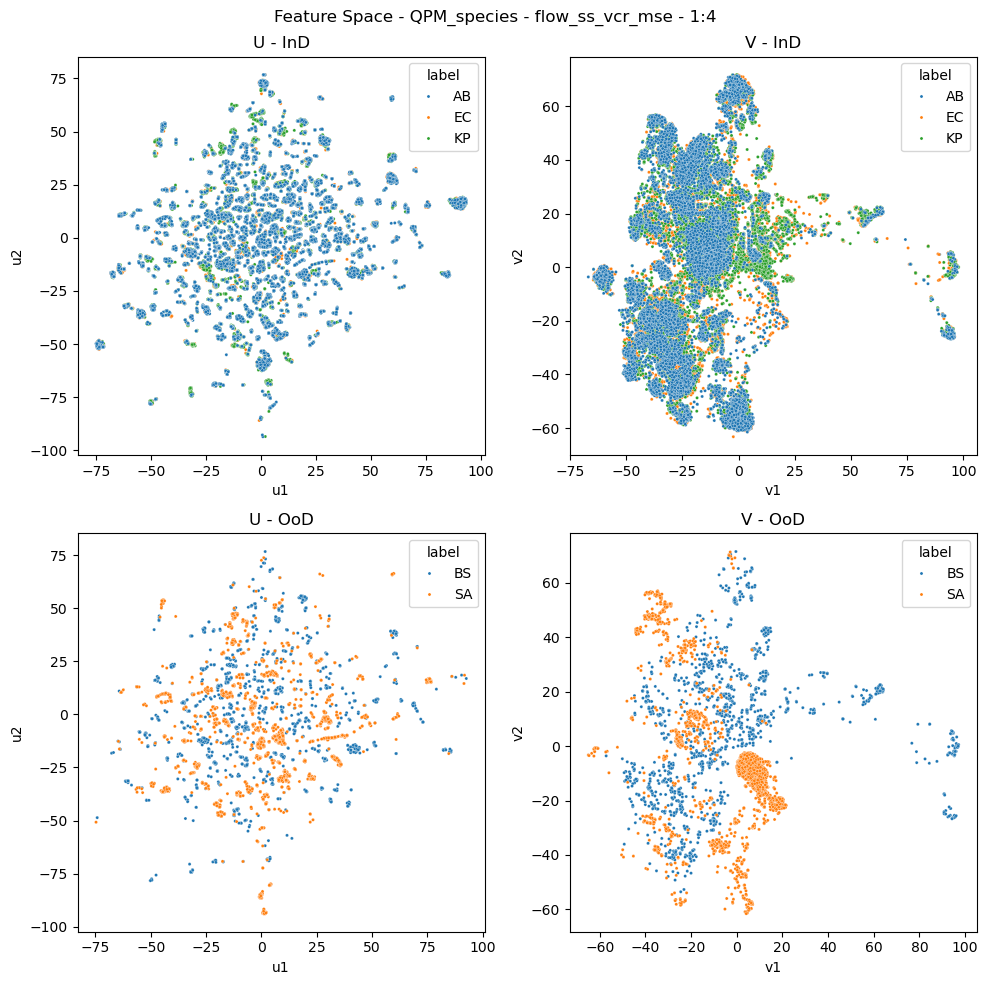

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:14<00:44, 14.78s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:29<00:29, 14.83s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:44<00:14, 14.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 15.07s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.99s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [01:35<04:46, 95.62s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [03:11<03:11, 95.67s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [04:47<01:35, 95.79s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 96.01s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:23<00:00, 95.90s/it]

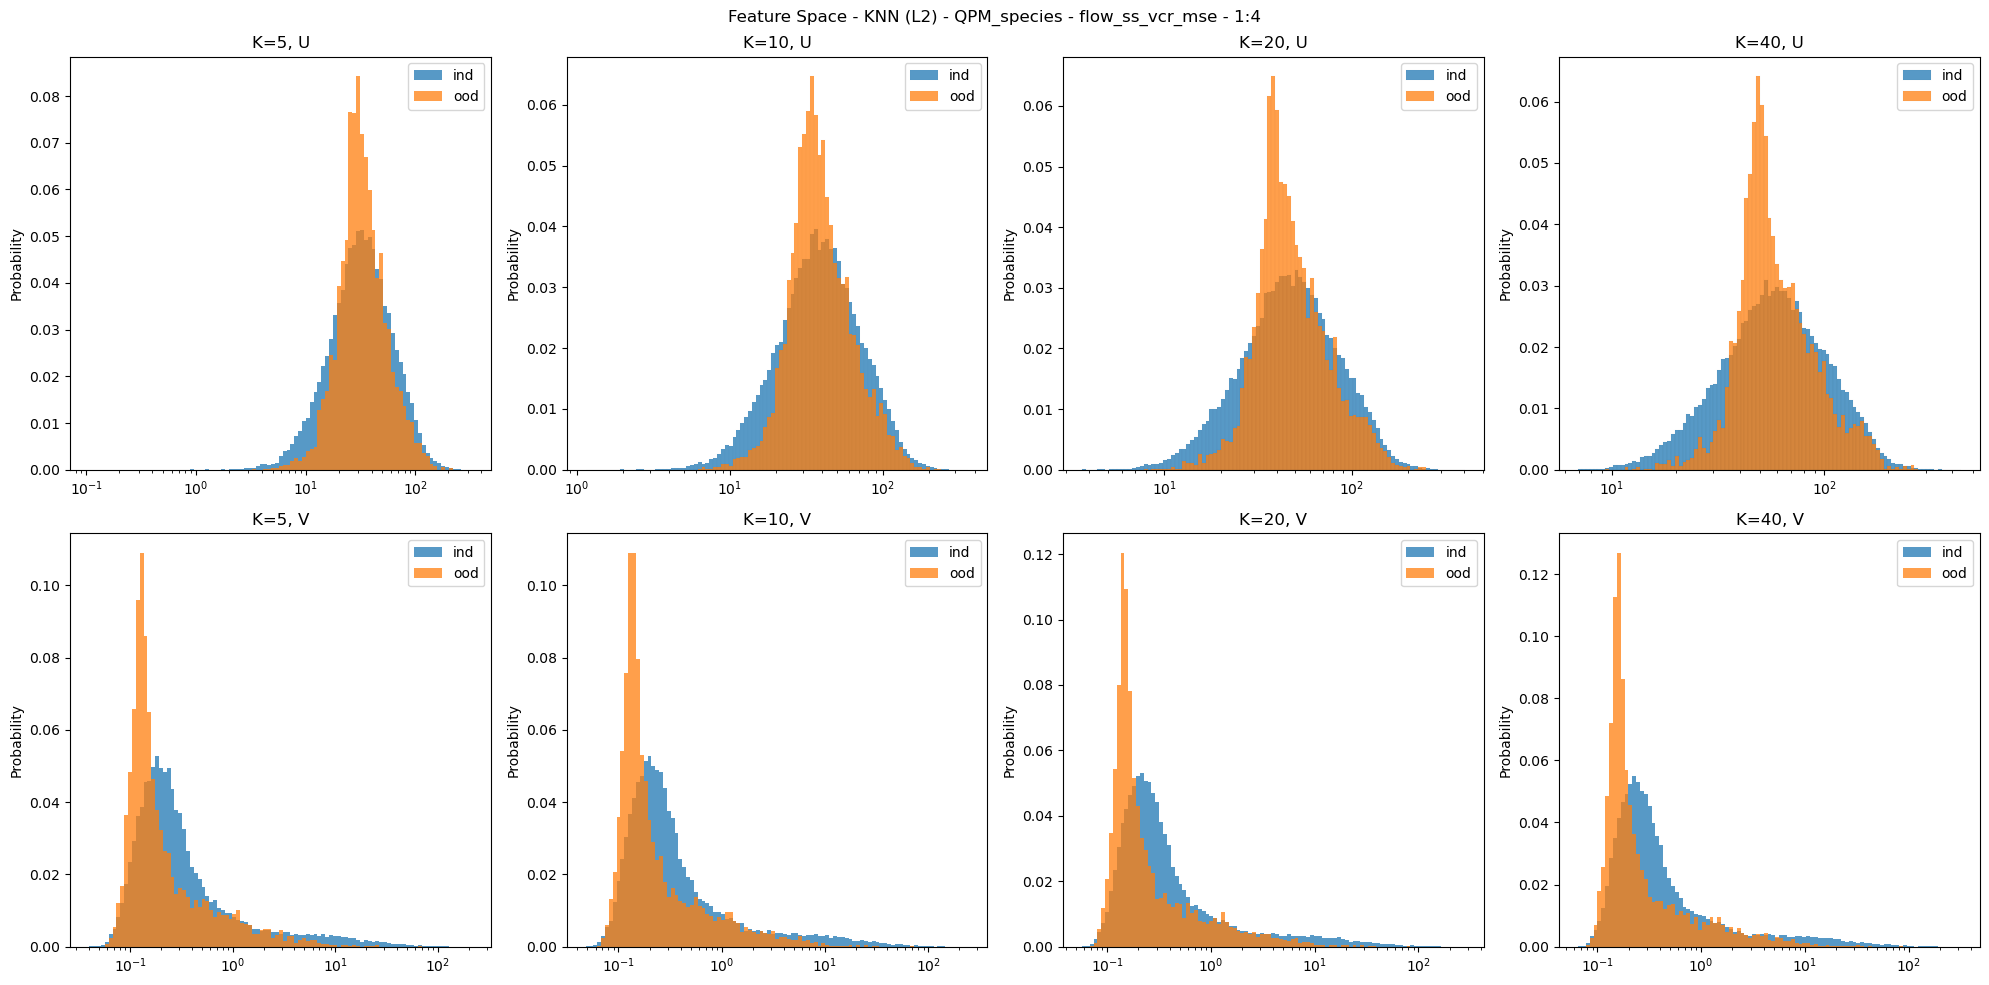

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:14<00:43, 14.52s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:29<00:29, 14.61s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:44<00:14, 14.72s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.79s/it]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [01:35<04:45, 95.10s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [03:10<03:10, 95.29s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [04:45<01:35, 95.32s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:21<00:00, 95.46s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:21<00:00, 95.39s/it]

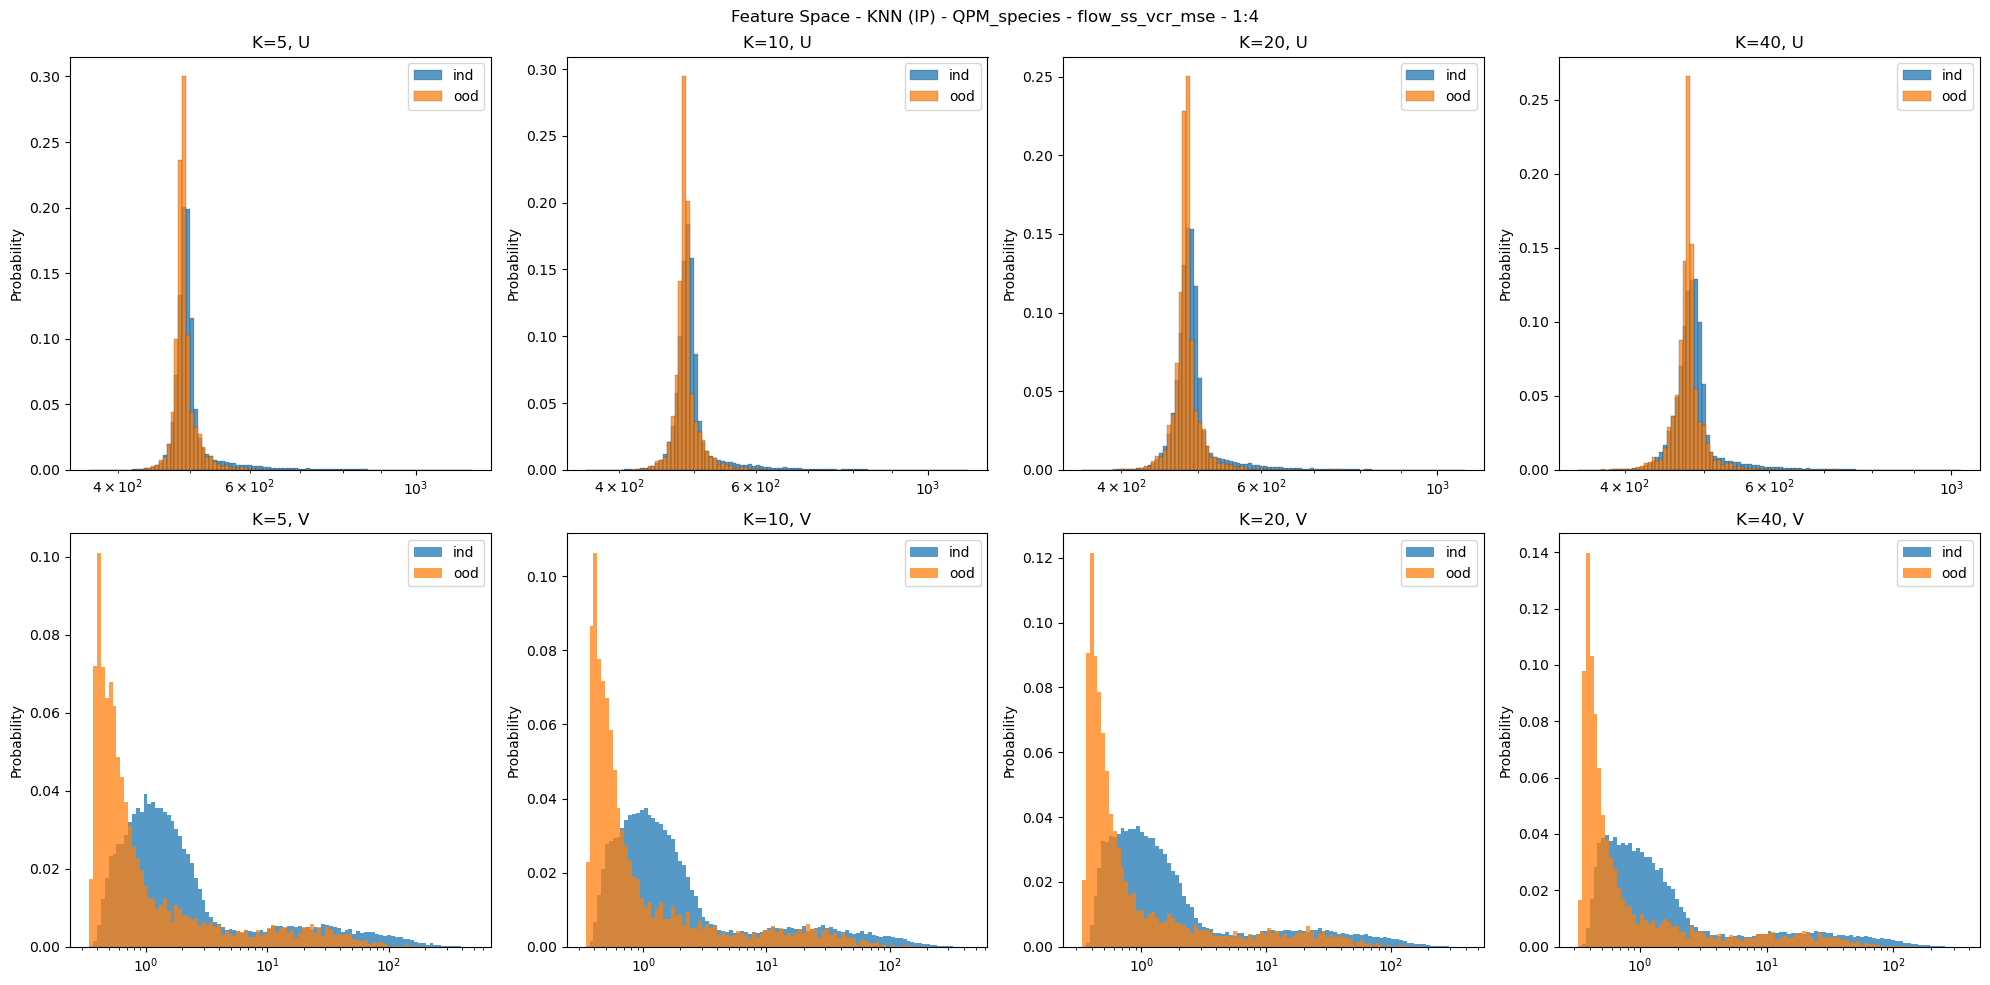

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.726313 0.6907675 1.4496739 1.6621497
22.684023 0.62525463 1.347364 1.5071396
22.76629 0.7697413 1.5448488 1.837158
22.573174 0.35660487 1.0626931 1.0273799
33.403915 0.8896777 54.168358 0.73959595


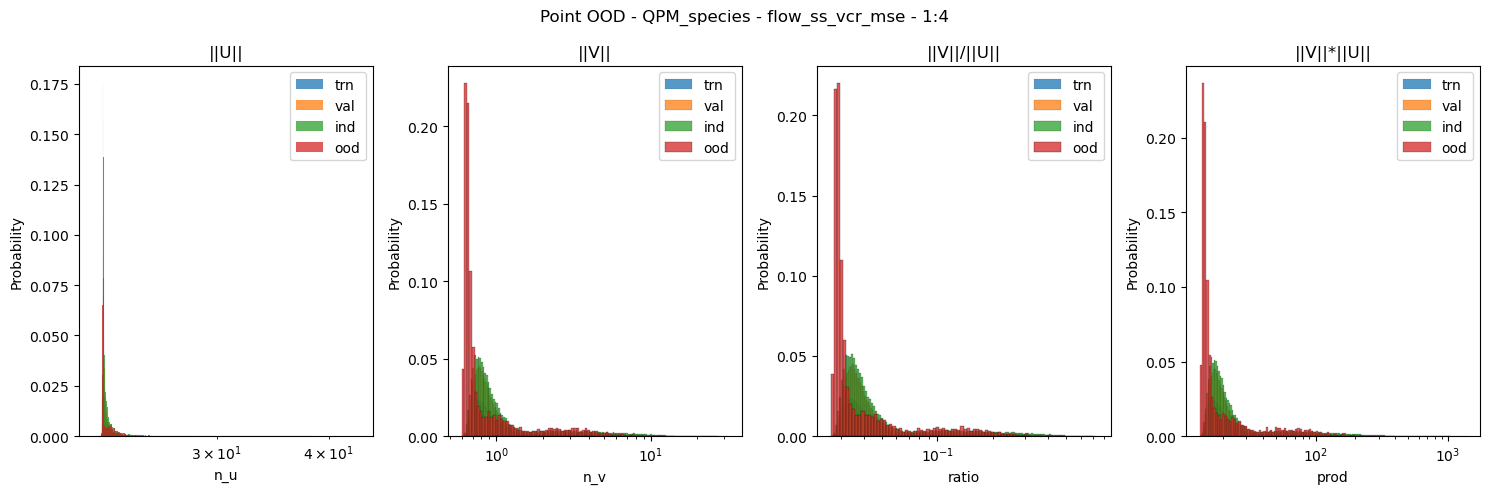

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


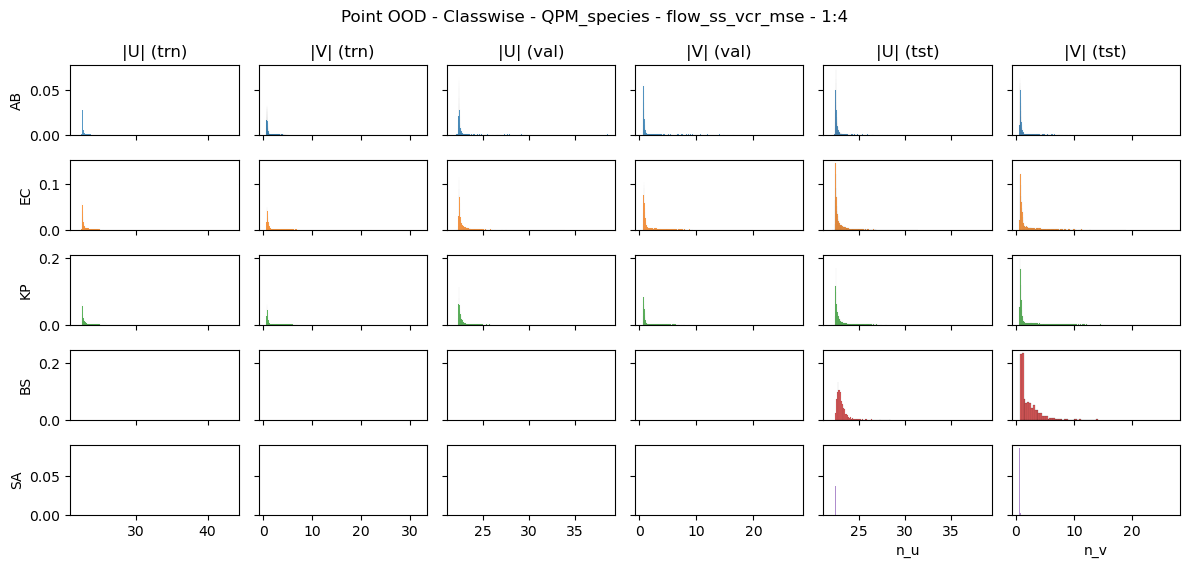

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

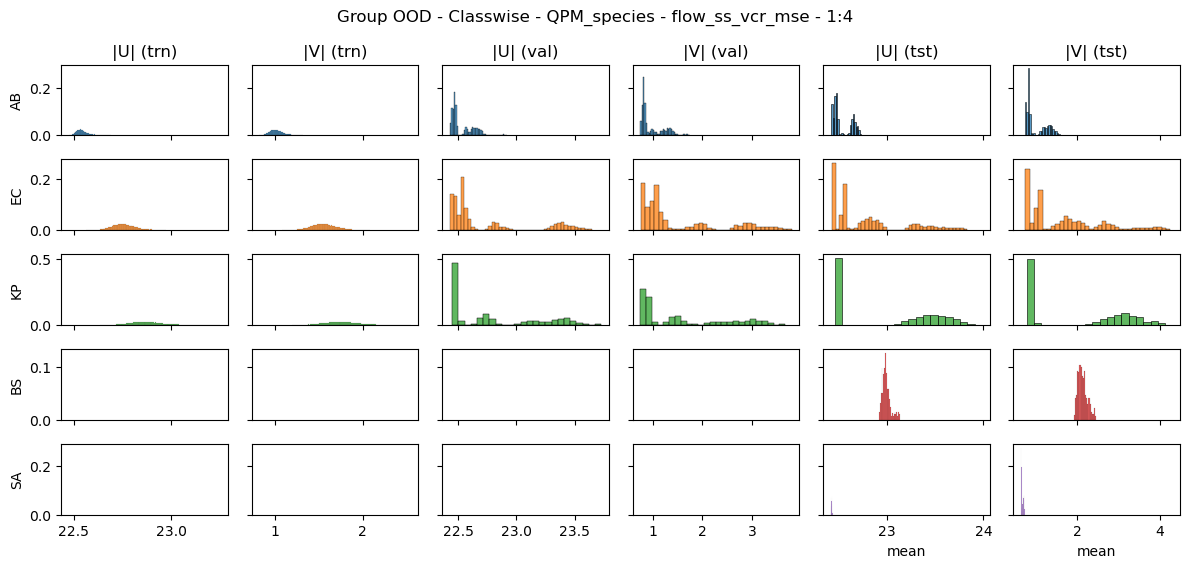

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

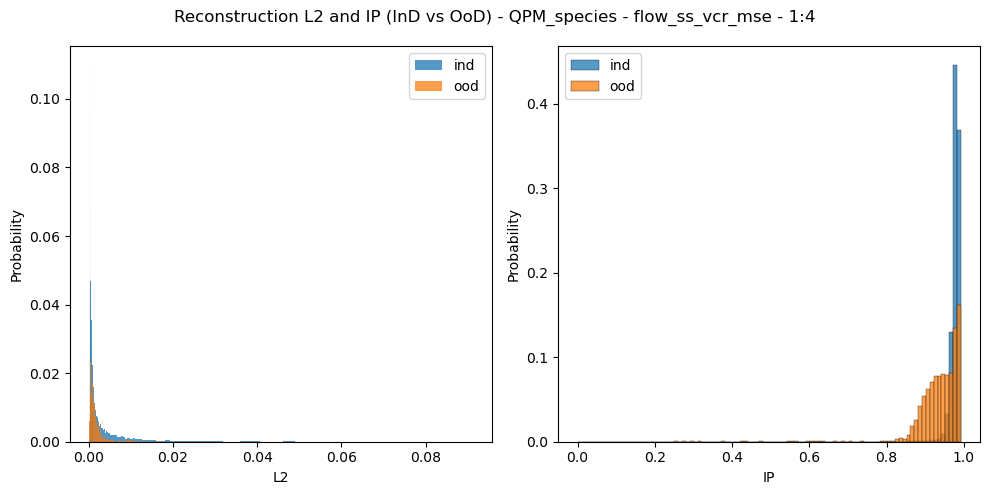

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()